In [ ]:
pip install filterpy

     |████████████████████████████████| 184kB 2.8MB/s 
  Created wheel for filterpy: filename=filterpy-1.4.5-cp36-none-any.whl size=110450 sha256=d33e659c6389603d11fb4147695cfbf339f26021206f95dbb79d527e71a8ffb3
  Stored in directory: /root/.cache/pip/wheels/c3/0c/dd/e92392c3f38a41371602d99fc77d6c1d42aadbf0c6afccdd02
Successfully built filterpy


In [ ]:
from filterpy.kalman import ExtendedKalmanFilter as EKF
import numpy as np
from numpy import dot, array, sqrt
from numpy.random import randn
from math import atan2, sqrt
import sympy
from sympy import symbols, Matrix
from sympy.abc import beta, x, y, v, R, theta

# class of Extended Kalman Filter and helping methods
# all angles are in the range [-pi, pi)
class RobotEKF(EKF):
    def __init__(self, dt, std_vel, std_steer, init_var, std_range, std_bearing):
        EKF.__init__(self, 3, 2, 2)
        self.dt = dt
        self.std_vel = std_vel
        self.std_steer = std_steer
        self.std_range = std_range
        self.std_bearing = std_bearing

        # initialize state variance P and measurement variance R
        self.P = np.diag([init_var[0], init_var[1], init_var[2]])
        self.R = np.diag([std_range**2, std_range**2, std_bearing**2])

        beta, x, y, v, theta, time = symbols(
            'beta, x, y, v, theta, t')
        d = v*time
    
        self.fxu = Matrix([[x + d*sympy.sin(theta+beta)],
                           [y + d*sympy.cos(theta+beta)],
                           [theta+beta]])

        self.F_j = self.fxu.jacobian(Matrix([x, y, theta]))
        self.V_j = self.fxu.jacobian(Matrix([v, beta]))

        # save dictionary and its variables for later use
        self.subs = {x: 0, y: 0, v:0, beta:0, 
                     time:dt, theta:0}
        self.x_x, self.x_y, = x, y 
        self.v, self.beta, self.theta = v, beta, theta

    def predict(self, u=0):
        self.x = self.move(self.x, u, self.dt)
        self.subs[self.theta] = self.x[2, 0]
        self.subs[self.v] = u[0]
        self.subs[self.beta] = u[1]

        F = array(self.F_j.evalf(subs=self.subs)).astype(float)
        V = array(self.V_j.evalf(subs=self.subs)).astype(float)

        # covariance of motion noise in control space
        M = array([[self.std_vel**2, 0], 
                   [0, self.std_steer**2]])

        self.P = dot(F, self.P).dot(F.T) + dot(V, M).dot(V.T)

    def move(self, x, u, dt):
        theta = x[2, 0]
        vel = u[0]
        beta = u[1]
        dist = vel * dt
        new_theta = (theta + beta) % (2 * np.pi)
        # move to [-pi, pi)
        if new_theta > np.pi:             
            new_theta -= 2 * np.pi

        new_x = np.array([[x[0, 0] + dist*sin(new_theta)], 
                          [x[1, 0] + dist*cos(new_theta)], 
                          [new_theta]])
        return new_x

# helping methods for RobotEKF class
def H_of(x):
    """ compute Jacobian of H matrix where h(x) computes 
    the range and bearing to a landmark for state x """
    H = array(
        [[1, 0, 0],
         [0, 1, 0],
         [0, 0, 1],])
    
    return H

def Hx(x):
    """ takes a state variable and returns the measurement
    that would correspond to that state. """
    Hx = array([[x[0, 0]],
                [x[1, 0]],
                [x[2, 0]]])
    
    return Hx

def residual(a, b):
    """ compute residual (a-b) between computed measurement and 
    machine measurement containing [range, bearing]. 
    Bearing is normalized to [-pi, pi)"""
    y = a - b
    y[2] = y[2] % (2 * np.pi)    # force in range [0, 2 pi)
    if y[2] > np.pi:             # move to [-pi, pi)
        y[2] -= 2 * np.pi
    return y

In [ ]:
#@title
from math import sqrt, tan, cos, sin, atan2
import matplotlib.pyplot as plt
import random

def run_navigation(ekf, destination_coordinates, obstacle_coordinates, tol, u, ideal_track, ekf_track):

    ideal_state = ekf.x.copy() # simulated position
    
    # simulated movement, i.e. half circle
    while 1 :
    #for i in range(20):
        current_coordinates = ekf.x.T[0]
        if reach_goal(current_coordinates, destination_coordinates, tol=tol):
            return 0
        if reach_goal(current_coordinates, obstacle_coordinates, tol=1.0):
            return 1
        # ideal movement of robot
        ideal_state = ekf.move(ideal_state, u, dt)
        # keep track of the ideal path
        ideal_track.append(ideal_state)

        # apply noise to control and measurement with EKF
        ekf.predict(u=u)
        z = get_measurement(ekf.x, ekf.std_range, ekf.std_bearing)
        ekf.update(z, HJacobian=H_of, Hx=Hx, residual=residual)
        # keep track of the EKF path
        ekf_track.append(ekf.x)

    return -1

def get_angle(point_a, point_b):
    return atan2(point_b[0]-point_a[0], point_b[1]-point_a[1])

def get_sq_dist(point_a, point_b):
    return (point_a[0]-point_b[0])**2 + (point_a[1]-point_b[1])**2

def compute_coordinates(point, angle, distance):
    target_x = point[0] + sin(angle)*distance
    target_y = point[1] + cos(angle)*distance
    return [target_x, target_y]

def boundary_following_next_point(current_coordinates, closest_point, left_or_right, distance):
    angle_to_closest_point = get_angle(current_coordinates, closest_point)
    angle_to_go = angle_to_closest_point + left_or_right
    return compute_coordinates(current_coordinates, angle_to_go, distance)

def fake_real_time_obstacle_detection(current_coordinates, obstacle_coordinates):
    if get_sq_dist(current_coordinates, obstacle_coordinates) < 1.5:
      return True
    return False

def find_closest_point_on_obstacle_to_rover(facing_angle, closest_points_on_obstacle, index):
    # if there is more than one, return the leftmost point
    return closest_points_on_obstacle[index]

def turn_camera(angle):
    return
    

In [ ]:
#@title
# BugX algorithm

dt = 0.1
std_vel = 0.5
std_steer = 0.05
std_range=0.5
std_bearing=0.05
start_state = array([[6.0, 2.0, 0.0]]).T
goal_state = array([[15.0, 16.0]]).T
goal_coordinates = goal_state.T[0]
init_var = [0.1, 0.1, 0.01]   # initial std for state variables x, y and theta

rover = RobotEKF(dt, std_vel=std_vel, std_steer=std_steer, init_var=init_var, std_range=std_range, std_bearing=std_bearing)
rover.x = start_state         # x, y, steer angle

# two modes, motion_to_goal and boundary_following

movement_buffer = 1.0
# closest the rover can get to the obstacle, a buffer to avoid collision
min_dist_to_obstacle = 1.0
camera_max_range = 3.0
tol = 0.5

motion_to_go = []
boundary_following = []
ideal_track = []
ekf_track = []
ideal_bf = []
ekf_bf = []

sensor_readings = [3.0, 2.0, 2.0, 3.0, 2.5, 3.0]
sensor_reading_index = 0
control = [[1.0, 0.0],[1.0, 0.02]]
control_index = 1
obstacle_discontinuity_points = [[[5.5,6.5],[9.5,6.5]], [[14,13],[17,10]]]
obstacle_discontinuity_points_index = 0
closest_dist_to_obstacle = [2.0, 0.5, 2.5]
closest_dist_index = 0
boundary_following_next_point = [[15,7]]
next_point_index = 0


# while not reach_goal(rover.x, goal_state, tol=tol):
for i in range(6):
    current_coordinates = rover.x.T[0]
    angle_robot_to_goal = get_angle(current_coordinates, goal_coordinates)
    # camera_reading is a dictionary, "angle" : sensed_range
    range_towards_goal = sensor_readings[sensor_reading_index]
    sensor_reading_index += 1

    if range_towards_goal == camera_max_range:
        next_point = compute_coordiates(current_coordinates, angle_robot_to_goal, min(camera_max_range,get_sq_dist(current_coordinates, goal_coordinates))*movement_buffer)
        next_point = array([next_point]).T
        motion_to_go.append(next_point)
        rover.x[2, 0] = angle_robot_to_goal
        u = array(control[0])
        control_index += 1
        run_navigation(rover, next_point, tol, u, ideal_track, ekf_track)
    elif closest_dist_to_obstacle[closest_dist_index] > min_dist_to_obstacle:
        closest_dist_index += 1
        # find obstacle corners within range, return coordinates
        discontinuity_points = obstacle_discontinuity_points[obstacle_discontinuity_points_index] # detect_obstacle_end_points(angle_robot_to_goal)
        obstacle_discontinuity_points_index += 1
        # if no corner in range, find the discontinuity points
        next_point = discontinuity_points[0]
        if len(discontinuity_points) == 2 and get_sq_dist(discontinuity_points[0], goal_coordinates) > get_sq_dist(discontinuity_points[1], goal_coordinates):
           next_point = discontinuity_points[1]
        rover.x[2, 0] = get_angle(current_coordinates, next_point)
        u = array(control[0])
        control_index += 1
        next_point = array([next_point]).T
        motion_to_go.append(next_point)
        run_navigation(rover, next_point, tol, u, ideal_track, ekf_track)
    else: # boundary following
        closest_dist_index += 1
        next_point = boundary_following_next_point[next_point_index]
        next_point_index += 1
        rover.x[2, 0] = get_angle(current_coordinates, next_point)
        next_point = array([next_point]).T
        boundary_following.append(next_point)
        u = array(control[0])
        run_navigation(rover, next_point, tol, u, ideal_bf, ekf_bf)

obstacles = np.array([[2,3],[2,4],[3,2],[3,3],[3,4],[3,5],[4,3],[4,4],[5,8],[6,7],[6,8],[7,6],[7,7],[8,6],[9,7],[10,8],[11,9],[12,10],[13,9],[14,8],
                  [4,15],[5,14],[5,15],[5,16],[6,13],[6,14],[6,15],[6,16],[6,17],[7,13],[7,14],[7,15],[7,16],[7,17],[8,14],[8,15],[8,16],[9,15],
                  [12,2],[12,3],[13,2],[13,3],[14,2],[14,3],[15,2],[15,3],[15,13],[16,12],[16,13],[16,14],[17,11],[17,12],[17,13],[17,14],[17,15],
                  [18,12],[18,13],[18,14],[18,15],[18,16],[19,13],[19,14],[19,15],[19,16],[19,17]])

start = start_state.T
goal = goal_state.T
ideal_track = np.array(ideal_track)
ekf_track = np.array(ekf_track)
ideal_bf = np.array(ideal_bf)
ekf_bf = np.array(ekf_bf)
motion_to_go = np.array(motion_to_go)
boundary_following = np.array(boundary_following)

plt.figure()
plt.scatter(obstacles[:, 0], obstacles[:, 1], c='black', marker='s', s=60)
plt.scatter(start[0, 0], start[0, 1], c='red', marker='o', s=60)
plt.scatter(goal[0, 0], goal[0, 1], c='blue', marker='o', s=60)
plt.scatter(motion_to_go[:, 0], motion_to_go[:, 1], c='green', marker='^', s=60)
plt.scatter(boundary_following[:, 0], boundary_following[:, 1], c='green', marker='o', s=60)
plt.plot(ideal_track[:,0], ideal_track[:,1], color='b', lw=2)
plt.plot(ekf_track[:, 0], ekf_track[:,1], color='r', lw=2)
plt.plot(ideal_bf[:,0], ideal_bf[:,1], color='g', linestyle='dashed', lw=2)
#plt.plot(ekf_bf[:, 0], ekf_bf[:,1], color='r', lw=2)
plt.axis('equal')
plt.title("EKF Rover Autonomous Navigation")
plt.show()

In [ ]:
#@title

# BugX algorithm

dt = 0.1
std_vel = 0.1
std_steer = 0.01
std_range=0.1
std_bearing=0.01
start_state = array([[0.0, 16.0, 0.0]]).T
goal_state = array([[20.0, 15.0]]).T
goal_coordinates = goal_state.T[0]
init_var = [0.1, 0.1, 0.01]   # initial std for state variables x, y and theta

rover = RobotEKF(dt, std_vel=std_vel, std_steer=std_steer, init_var=init_var, std_range=std_range, std_bearing=std_bearing)
rover.x = start_state         # x, y, steer angle

# two modes, motion_to_goal and boundary_following
movement_buffer = 1.0
# closest the rover can get to the obstacle, a buffer to avoid collision
min_dist_to_obstacle = 1.0
camera_max_range = 3.0
tol = 0.3

path_planning = []

ideal_track = []
ekf_track = []

sensor_readings = [3.0, 1.0, 3.0, 3.0, 3.0, 1.0, 3.0]
sensor_reading_index = 0
control = [[1.0, 0.0],[1.0, 0.02]]
control_index = 1
obstacle_discontinuity_points = [[[5.5,6.5],[9.5,6.5]], [[14,13],[17,10]]]
obstacle_discontinuity_points_index = 0
closest_dist_to_obstacle = [1.0, 0.5]
closest_dist_index = 0
boundary_following_next_point = [[6,12],[20,18]]
next_point_index = 0


# while not reach_goal(rover.x, goal_state, tol=tol):
for i in range(7):
    current_coordinates = rover.x.T[0]
    angle_robot_to_goal = get_angle(current_coordinates, goal_coordinates)
    # camera_reading is a dictionary, "angle" : sensed_range
    range_towards_goal = sensor_readings[sensor_reading_index]
    sensor_reading_index += 1
    dist_to_goal = get_sq_dist(current_coordinates, goal_coordinates)

    if range_towards_goal > dist_to_goal or range_towards_goal == camera_max_range:
        next_point = compute_coordiates(current_coordinates, angle_robot_to_goal, min(range_towards_goal,dist_to_goal)*movement_buffer)
        next_point = array([next_point]).T
        path_planning.append(next_point)
        rover.x[2, 0] = angle_robot_to_goal
        u = array(control[0])
        control_index += 1
        run_navigation(rover, next_point, tol, u, ideal_track, ekf_track)
    elif closest_dist_to_obstacle[closest_dist_index] > min_dist_to_obstacle:
        closest_dist_index += 1
        # find obstacle corners within range, return coordinates
        discontinuity_points = obstacle_discontinuity_points[obstacle_discontinuity_points_index] # detect_obstacle_end_points(angle_robot_to_goal)
        obstacle_discontinuity_points_index += 1
        # if no corner in range, find the discontinuity points
        next_point = discontinuity_points[0]
        if len(discontinuity_points) == 2 and get_sq_dist(discontinuity_points[0], goal_coordinates) > get_sq_dist(discontinuity_points[1], goal_coordinates):
           next_point = discontinuity_points[1]
        rover.x[2, 0] = get_angle(current_coordinates, next_point)
        u = array(control[0])
        control_index += 1
        next_point = array([next_point]).T
        path_planning.append(next_point)
        run_navigation(rover, next_point, tol, u, ideal_track, ekf_track)
    else: # boundary following
        closest_dist_index += 1
        next_point = boundary_following_next_point[next_point_index]
        next_point_index += 1
        rover.x[2, 0] = get_angle(current_coordinates, next_point)
        next_point = array([next_point]).T
        path_planning.append(next_point)
        u = array(control[0])
        run_navigation(rover, next_point, tol, u, ideal_track, ekf_track)

obstacles = np.array([[2,3],[2,4],[3,2],[3,3],[3,4],[3,5],[4,3],[4,4],[5,8],[6,7],[6,8],[7,6],[7,7],[8,6],[9,7],[10,8],[11,9],[12,10],[13,9],[14,8],
                  [4,15],[5,14],[5,15],[5,16],[6,13],[6,14],[6,15],[6,16],[6,17],[7,13],[7,14],[7,15],[7,16],[7,17],[8,14],[8,15],[8,16],[9,15],
                  [12,2],[12,3],[13,2],[13,3],[14,2],[14,3],[15,2],[15,3],[15,13],[16,12],[16,13],[16,14],[17,11],[17,12],[17,13],[17,14],[17,15],
                  [18,12],[18,13],[18,14],[18,15],[18,16],[19,13],[19,14],[19,15],[19,16],[19,17]])

start = start_state.T
goal = goal_state.T
ideal_track = np.array(ideal_track)
ekf_track = np.array(ekf_track)
ideal_bf = np.array(ideal_bf)
ekf_bf = np.array(ekf_bf)
path_planning = np.array(path_planning)

plt.figure()
plt.scatter(obstacles[:, 0], obstacles[:, 1], c='black', marker='s', s=60)
plt.scatter(start[0, 0], start[0, 1], c='red', marker='o', s=60)
plt.scatter(goal[0, 0], goal[0, 1], c='blue', marker='o', s=60)
plt.scatter(path_planning[:, 0], path_planning[:, 1], c='green', marker='^', s=60)
plt.plot(ideal_track[:,0], ideal_track[:,1], color='b', lw=2)
plt.plot(ekf_track[:, 0], ekf_track[:,1], color='r', lw=2)
plt.axis('equal')
plt.title("EKF Rover Autonomous Navigation")
plt.show()

In [ ]:
#@title
# BugX algorithm
import math

dt = 0.1
std_vel = 0.1
std_steer = 0.01
std_range=0.5
std_bearing=0.05
start_state = array([[0.0, 16.0, 0.0]]).T
goal_state = array([[20.0, 15.0]]).T
goal_coordinates = goal_state.T[0]
init_var = [0.1, 0.1, 0.01]   # initial std for state variables x, y and theta

rover = RobotEKF(dt, std_vel=std_vel, std_steer=std_steer, init_var=init_var, std_range=std_range, std_bearing=std_bearing)
rover.x = start_state         # x, y, steer angle

# two modes, motion_to_goal and boundary_following
movement_buffer = 1.0
# closest the rover can get to the obstacle, a buffer to avoid collision
min_dist_to_obstacle = 1.0
camera_max_range = 3.0
tol = 0.3

path_planning = []
bf_track = []
ideal_track = []
ekf_track = []

sensor_readings = [3.0, 0.8, 3.0, 3.0, 3.0, 2.0, 3.0]
sensor_reading_index = 0
control = [[1.0, 0.0],[1.0, 0.02]]
control_index = 1
obstacle_discontinuity_points = [[[15,14],[17,16]], [[14,13],[17,10]]]
obstacle_discontinuity_points_index = 0
closest_dist_to_obstacle = [0.5, 1.5]
closest_dist_index = 0
#boundary_following_next_points = [[6,12],[20,18]]
next_point_index = 0
closest_point = [[4,15],[5,16],[6,17],[18,16],[19,17],[19,17]]
closest_point_index = 0

# while not reach_goal(rover.x, goal_state, tol=tol):
for i in range(6):
    current_coordinates = rover.x.T[0]
    angle_robot_to_goal = get_angle(current_coordinates, goal_coordinates)
    # camera_reading is a dictionary, "angle" : sensed_range
    range_towards_goal = sensor_readings[sensor_reading_index]
    sensor_reading_index += 1
    dist_to_goal = get_sq_dist(current_coordinates, goal_coordinates)

    if range_towards_goal > dist_to_goal or range_towards_goal == camera_max_range:
        next_point = compute_coordiates(current_coordinates, angle_robot_to_goal, min(range_towards_goal,dist_to_goal)*movement_buffer)
        next_point = array([next_point]).T
        path_planning.append(next_point)
        rover.x[2, 0] = angle_robot_to_goal
        u = array(control[0])
        control_index += 1
        run_navigation(rover, next_point, tol, u, ideal_track, ekf_track)
    elif closest_dist_to_obstacle[closest_dist_index] > min_dist_to_obstacle:
        closest_dist_index += 1
        # find obstacle corners within range, return coordinates
        discontinuity_points = obstacle_discontinuity_points[obstacle_discontinuity_points_index] # detect_obstacle_end_points(angle_robot_to_goal)
        obstacle_discontinuity_points_index += 1
        # if no corner in range, find the discontinuity points
        next_point = discontinuity_points[0]
        if len(discontinuity_points) == 2 and get_sq_dist(discontinuity_points[0], goal_coordinates) > get_sq_dist(discontinuity_points[1], goal_coordinates):
           next_point = discontinuity_points[1]
        rover.x[2, 0] = get_angle(current_coordinates, next_point)
        u = array(control[0])
        control_index += 1
        next_point = array([next_point]).T
        path_planning.append(next_point)
        run_navigation(rover, next_point, tol, u, ideal_track, ekf_track)
    else: # boundary following
        closest_dist_index += 1
        # while range_towards_goal < threshold:
        for i in range(3):
            current_coordinates = rover.x.T[0]
            next_point = boundary_following_next_point(current_coordinates, closest_point[closest_point_index], (-1)*math.pi/2, 2.0)
            closest_point_index += 1
            rover.x[2, 0] = get_angle(rover.x.T[0], next_point)
            next_point = array([next_point]).T
            bf_track.append(next_point)
            u = array(control[0])
            run_navigation(rover, next_point, tol, u, ideal_track, ekf_track)


obstacles = np.array([[2,3],[2,4],[3,2],[3,3],[3,4],[3,5],[4,3],[4,4],[5,8],[6,7],[6,8],[7,6],[7,7],[8,6],[9,7],[10,8],[11,9],[12,10],[13,9],[14,8],
                  [4,15],[5,14],[5,15],[5,16],[6,13],[6,14],[6,15],[6,16],[6,17],[7,13],[7,14],[7,15],[7,16],[7,17],[8,14],[8,15],[8,16],[9,15],
                  [12,2],[12,3],[13,2],[13,3],[14,2],[14,3],[15,2],[15,3],[15,13],[16,12],[16,13],[16,14],[17,11],[17,12],[17,13],[17,14],[17,15],
                  [18,12],[18,13],[18,14],[18,15],[18,16],[19,13],[19,14],[19,15],[19,16],[19,17]])

start = start_state.T
goal = goal_state.T
ideal_track = np.array(ideal_track)
ekf_track = np.array(ekf_track)
# ideal_bf = np.array(ideal_bf)
# ekf_bf = np.array(ekf_bf)
path_planning = np.array(path_planning)
bf_track = np.array(bf_track)

plt.figure()
plt.scatter(obstacles[:, 0], obstacles[:, 1], c='black', marker='s', s=60)
plt.scatter(start[0, 0], start[0, 1], c='red', marker='o', s=60)
plt.scatter(goal[0, 0], goal[0, 1], c='blue', marker='o', s=60)
plt.scatter(path_planning[:, 0], path_planning[:, 1], c='green', marker='^', s=60)
plt.scatter(bf_track[:, 0], bf_track[:, 1], c='green', marker='o', s=60)
plt.plot(ideal_track[:,0], ideal_track[:,1], color='b', lw=2)
plt.plot(ekf_track[:, 0], ekf_track[:,1], color='r', lw=2)
plt.axis('equal')
plt.title("EKF Rover Autonomous Navigation")
plt.show()

In [ ]:
#@title
# BugX algorithm
import math

dt = 0.1
std_vel = 0.1
std_steer = 0.01
std_range=0.1
std_bearing=0.01
start_state = array([[0.0, 16.0, 0.0]]).T
goal_state = array([[16.0, 16.0]]).T
goal_coordinates = goal_state.T[0]
init_var = [0.1, 0.1, 0.01]   # initial std for state variables x, y and theta

rover = RobotEKF(dt, std_vel=std_vel, std_steer=std_steer, init_var=init_var, std_range=std_range, std_bearing=std_bearing)
rover.x = start_state         # x, y, steer angle

# two modes, motion_to_goal and boundary_following
# movement_buffer = 0.9
# closest the rover can get to the obstacle, a buffer to avoid collision
# min_dist_to_obstacle = 1.0
camera_max_range = 3.0
rover_radius = 0.5
tol = 0.3
# gs_step_distance = 1.0
bf_step_distance = 1.0
u = [1.0, 0.0]

gs_track = []
bf_track = []
ideal_track = []
ekf_track = []

sensor_readings = [3.0]
sensor_reading_index = 0

closest_points_on_obstacle = [[4,15],[5,16],[5,16],[5,16],[6,17],[6,17],[6,17],[7,17],[7,17],[7,17],[7,17],[18,16]]
closest_point_index = 0
gs_hit_obstacles = [[4,15],[17,15]]
gs_hit_obstacles_index = 0
bf_hit_obstacles = [[100,100],[100,100],[100,100],[100,100],[100,100],[100,100],[100,100],[100,100],[100,100],[100,100],[100,100],[100,100],[100,100]]
bf_hit_obstacles_index = 0

current_coordinates = rover.x.T[0]
angle_robot_to_goal = get_angle(current_coordinates, goal_coordinates)

range_towards_goal = sensor_readings[sensor_reading_index]
sensor_reading_index += 1
go_straight_mode = 0
if range_towards_goal >= bf_step_distance + rover_radius:
    go_straight_mode = 1

# while not reach_goal(rover.x, goal_state, tol=tol):
for i in range(3):
    if go_straight_mode:  
        current_coordinates = rover.x.T[0]
        angle_robot_to_goal = get_angle(current_coordinates, goal_coordinates)
        rover.x[2, 0] = angle_robot_to_goal
        hit = run_navigation(rover, goal_coordinates, gs_hit_obstacles[gs_hit_obstacles_index], tol, u, ideal_track, ekf_track)
        gs_hit_obstacles_index += 1
        current_coordinates = rover.x.T[0]
        current_coordinates = array([current_coordinates]).T
        gs_track.append(current_coordinates)
        if hit == 0:
            break
        go_straight_mode = 0
    else: # boundary following
        current_coordinates = rover.x.T[0]
        camera_angle = get_angle(current_coordinates, goal_coordinates)
        closest_point_to_robot = find_closest_point_on_obstacle_to_rover(camera_angle, closest_points_on_obstacle, closest_point_index) # fake sensing
        closest_point_index += 1
        d_obstacle = get_sq_dist(closest_point_to_robot, goal_coordinates)
        d_rover = get_sq_dist(current_coordinates, goal_coordinates)
        while d_rover > d_obstacle:
        #for i in range(10):
            next_point = boundary_following_next_point(current_coordinates, closest_point_to_robot, (-1)*math.pi/2, bf_step_distance)
            rover.x[2, 0] = get_angle(current_coordinates, next_point)
            bf_track.append(array([next_point]).T)
            hit = run_navigation(rover, next_point, bf_hit_obstacles[bf_hit_obstacles_index], tol, u, ideal_track, ekf_track)
            bf_hit_obstacles_index += 1
            if hit == 0:
                camera_angle = rover.x[2, 0] + math.pi/2 # turn camera to be perpendicular to rover's steering angle
            if hit == 1:
                camera_angle = rover.x[2, 0] # turn camera to face the rover's steering angle
            current_coordinates = rover.x.T[0]
            closest_point_to_robot = find_closest_point_on_obstacle_to_rover(camera_angle, closest_points_on_obstacle, closest_point_index) # fake sensing
            closest_point_index += 1
            d_obstacle = min(d_obstacle, get_sq_dist(closest_point_to_robot, goal_coordinates))
            d_rover = get_sq_dist(current_coordinates, goal_coordinates)
        go_straight_mode = 1



obstacles = np.array([[2,3],[2,4],[3,2],[3,3],[3,4],[3,5],[4,3],[4,4],[5,8],[6,7],[6,8],[7,6],[7,7],[8,6],[9,7],[10,8],[11,9],[12,10],[13,9],[14,8],
                  [4,15],[5,14],[5,15],[5,16],[6,13],[6,14],[6,15],[6,16],[6,17],[7,13],[7,14],[7,15],[7,16],[7,17],[8,14],[8,15],[8,16],[9,15],
                  [12,2],[12,3],[13,2],[13,3],[14,2],[14,3],[15,2],[15,3],[15,13],[16,12],[16,13],[16,14],[17,11],[17,12],[17,13],[17,14],[17,15],
                  [18,12],[18,13],[18,14],[18,15],[18,16],[19,13],[19,14],[19,15],[19,16],[19,17]])

start = start_state.T
goal = goal_state.T
ideal_track = np.array(ideal_track)
ekf_track = np.array(ekf_track)
# ideal_bf = np.array(ideal_bf)
# ekf_bf = np.array(ekf_bf)
gs_track = np.array(gs_track)
bf_track = np.array(bf_track)

plt.figure()
plt.scatter(obstacles[:, 0], obstacles[:, 1], c='black', marker='s', s=60)
plt.scatter(start[0, 0], start[0, 1], c='red', marker='o', s=60)
plt.scatter(goal[0, 0], goal[0, 1], c='blue', marker='o', s=60)
plt.scatter(gs_track[:, 0], gs_track[:, 1], c='green', marker='^', s=60)
plt.scatter(bf_track[:, 0], bf_track[:, 1], c='green', marker='o', s=60)
plt.plot(ideal_track[:,0], ideal_track[:,1], color='b', lw=2)
plt.plot(ekf_track[:, 0], ekf_track[:,1], color='r', lw=2)
plt.axis('equal')
plt.title("EKF Rover Autonomous Navigation")
plt.show()

In [ ]:
#@title
# BugX algorithm
import math

dt = 0.1
std_vel = 0.1
std_steer = 0.01
std_range=0.1
std_bearing=0.01
start_state = array([[11.0, 4.0, 0.0]]).T
goal_state = array([[14.0, 12.0]]).T
goal_coordinates = goal_state.T[0]
init_var = [0.1, 0.1, 0.01]   # initial std for state variables x, y and theta

rover = RobotEKF(dt, std_vel=std_vel, std_steer=std_steer, init_var=init_var, std_range=std_range, std_bearing=std_bearing)
rover.x = start_state         # x, y, steer angle

# two modes, motion_to_goal and boundary_following
# movement_buffer = 0.9
# closest the rover can get to the obstacle, a buffer to avoid collision
# min_dist_to_obstacle = 1.0
camera_max_range = 3.0
rover_radius = 0.5
tol = 0.3
# gs_step_distance = 1.0
bf_step_distance = 2.0
u = [1.0, 0.0]

gs_track = []
bf_track = []
ideal_track = []
ekf_track = []

sensor_readings = [3.0]
sensor_reading_index = 0

closest_points_on_obstacle = [[13,9],[11,9],[10,8],[9,7],[8,6],[8,6],[7,6],[7,6],[7,6],[6,7],[5,8],[4,9],[7,17],[18,16]]
closest_point_index = 0
gs_hit_obstacles = [[13,9],[17,15]]
gs_hit_obstacles_index = 0
bf_hit_obstacles = [[11,9],[100,100],[100,100],[100,100],[100,100],[100,100],[4,4],[3,5],[100,100],[100,100],[100,100],[100,100],[100,100]]
bf_hit_obstacles_index = 0

current_coordinates = rover.x.T[0]
angle_robot_to_goal = get_angle(current_coordinates, goal_coordinates)

range_towards_goal = sensor_readings[sensor_reading_index]
sensor_reading_index += 1
go_straight_mode = 0
if range_towards_goal >= bf_step_distance + rover_radius:
    go_straight_mode = 1

# while not reach_goal(rover.x, goal_state, tol=tol):
for i in range(2):
    if go_straight_mode:  
        current_coordinates = rover.x.T[0]
        angle_robot_to_goal = get_angle(current_coordinates, goal_coordinates)
        rover.x[2, 0] = angle_robot_to_goal
        hit = run_navigation(rover, goal_coordinates, gs_hit_obstacles[gs_hit_obstacles_index], tol, u, ideal_track, ekf_track)
        gs_hit_obstacles_index += 1
        current_coordinates = rover.x.T[0]
        current_coordinates = array([current_coordinates]).T
        gs_track.append(current_coordinates)
        if hit == 0:
            break
        go_straight_mode = 0
    else: # boundary following
        current_coordinates = rover.x.T[0]
        camera_angle = get_angle(current_coordinates, goal_coordinates)
        closest_point_to_robot = find_closest_point_on_obstacle_to_rover(camera_angle, closest_points_on_obstacle, closest_point_index) # fake sensing
        closest_point_index += 1
        d_obstacle = get_sq_dist(closest_point_to_robot, goal_coordinates)
        d_rover = get_sq_dist(current_coordinates, goal_coordinates)
        #while d_rover > d_obstacle:
        for i in range(2):
            next_point = boundary_following_next_point(current_coordinates, closest_point_to_robot, (-1)*math.pi/2, bf_step_distance)
            rover.x[2, 0] = get_angle(current_coordinates, next_point)
            bf_track.append(array([next_point]).T)
            hit = run_navigation(rover, next_point, bf_hit_obstacles[bf_hit_obstacles_index], tol, u, ideal_track, ekf_track)
            bf_hit_obstacles_index += 1
            if hit == 0:
                camera_angle = rover.x[2, 0] + math.pi/2 # turn camera to be perpendicular to rover's steering angle
            if hit == 1:
                camera_angle = rover.x[2, 0] # turn camera to face the rover's steering angle
            current_coordinates = rover.x.T[0]
            closest_point_to_robot = find_closest_point_on_obstacle_to_rover(camera_angle, closest_points_on_obstacle, closest_point_index) # fake sensing
            closest_point_index += 1
            d_obstacle = min(d_obstacle, get_sq_dist(closest_point_to_robot, goal_coordinates))
            d_rover = get_sq_dist(current_coordinates, goal_coordinates)
        go_straight_mode = 1



obstacles = np.array([[2,3],[2,4],[3,2],[3,3],[3,4],[3,5],[4,3],[4,4],[5,8],[6,7],[6,8],[7,6],[7,7],[8,6],[9,7],[10,8],[11,9],[12,10],[13,9],[14,8],
                  [4,15],[5,14],[5,15],[5,16],[6,13],[6,14],[6,15],[6,16],[6,17],[7,13],[7,14],[7,15],[7,16],[7,17],[8,14],[8,15],[8,16],[9,15],
                  [12,2],[12,3],[13,2],[13,3],[14,2],[14,3],[15,2],[15,3],[15,13],[16,12],[16,13],[16,14],[17,11],[17,12],[17,13],[17,14],[17,15],
                  [18,12],[18,13],[18,14],[18,15],[18,16],[19,13],[19,14],[19,15],[19,16],[19,17]])

start = start_state.T
goal = goal_state.T
ideal_track = np.array(ideal_track)
ekf_track = np.array(ekf_track)
# ideal_bf = np.array(ideal_bf)
# ekf_bf = np.array(ekf_bf)
gs_track = np.array(gs_track)
bf_track = np.array(bf_track)

plt.figure()
plt.scatter(obstacles[:, 0], obstacles[:, 1], c='black', marker='s', s=60)
plt.scatter(start[0, 0], start[0, 1], c='red', marker='o', s=60)
plt.scatter(goal[0, 0], goal[0, 1], c='blue', marker='o', s=60)
plt.scatter(gs_track[:, 0], gs_track[:, 1], c='green', marker='^', s=60)
plt.scatter(bf_track[:, 0], bf_track[:, 1], c='green', marker='o', s=60)
plt.plot(ideal_track[:,0], ideal_track[:,1], color='b', lw=2)
plt.plot(ekf_track[:, 0], ekf_track[:,1], color='r', lw=2)
plt.axis('equal')
plt.title("EKF Rover Autonomous Navigation")
plt.show()

In [ ]:
#@title
# BugX algorithm
import math

dt = 0.1
std_vel = 0.1
std_steer = 0.01
std_range=0.1
std_bearing=0.01
start_state = array([[11.0, 4.0, 0.0]]).T
goal_state = array([[14.0, 12.0]]).T
goal_coordinates = goal_state.T[0]
init_var = [0.1, 0.1, 0.01]   # initial std for state variables x, y and theta

rover = RobotEKF(dt, std_vel=std_vel, std_steer=std_steer, init_var=init_var, std_range=std_range, std_bearing=std_bearing)
rover.x = start_state         # x, y, steer angle

# two modes, motion_to_goal and boundary_following
# movement_buffer = 0.9
# closest the rover can get to the obstacle, a buffer to avoid collision
# min_dist_to_obstacle = 1.0
camera_max_range = 3.0
rover_radius = 0.5
tol = 0.3
# gs_step_distance = 1.0
bf_step_distance = 1.0
u = [1.0, 0.0]

gs_track = []
bf_track = []
ideal_track = []
ekf_track = []

sensor_readings = [3.0]
sensor_reading_index = 0

closest_points_on_obstacle = [[13,9],[11,9],[11,9],[10,8],[10,8],[9,7],[9,7],[8,6],[8,6],[8,6],[8,6],[8,6],[7,6],[7,6],[7,6],[7,6],[7,6],[6,7],[6,7],
                              [5,8],[5,8],[5,8],[5,8],[5,8],[5,8],[6,8],[6,8],[6,8],[6,8],[7,7],[7,7],[9,7],[9,7],[10,8],[10,8],[11,9],[11,9],[11,9],[11,9],
                              [7,17],[18,16]]
closest_point_index = 0
gs_hit_obstacles = [[13,9],[17,15]]
gs_hit_obstacles_index = 0
bf_hit_obstacles = [[11,9],[100,100],[100,100],[100,100],[100,100],[100,100],[100,100],[100,100],[100,100],[100,100],[100,100],[100,100],[100,100],
                    [100,100],[100,100],[100,100],[100,100],[100,100],[100,100],[100,100],[100,100],[100,100],[100,100],[100,100],[100,100],[100,100],
                    [100,100],[100,100],[100,100],[100,100],[100,100],[100,100],[100,100],[100,100],[100,100],[100,100],[100,100],[100,100],[100,100],
                    [100,100],[100,100],[100,100],[100,100],[100,100],[100,100],[100,100],[100,100],[100,100],[100,100],[100,100],[100,100],[100,100],]
bf_hit_obstacles_index = 0

current_coordinates = rover.x.T[0]
angle_robot_to_goal = get_angle(current_coordinates, goal_coordinates)

range_towards_goal = sensor_readings[sensor_reading_index]
sensor_reading_index += 1
go_straight_mode = 0
if range_towards_goal >= bf_step_distance + rover_radius:
    go_straight_mode = 1

# while not reach_goal(rover.x, goal_state, tol=tol):
for i in range(3):
    if go_straight_mode:  
        current_coordinates = rover.x.T[0]
        angle_robot_to_goal = get_angle(current_coordinates, goal_coordinates)
        rover.x[2, 0] = angle_robot_to_goal
        hit = run_navigation(rover, goal_coordinates, gs_hit_obstacles[gs_hit_obstacles_index], tol, u, ideal_track, ekf_track)
        gs_hit_obstacles_index += 1
        current_coordinates = rover.x.T[0]
        current_coordinates = array([current_coordinates]).T
        gs_track.append(current_coordinates)
        if hit == 0:
            break
        go_straight_mode = 0
    else: # boundary following
        current_coordinates = rover.x.T[0]
        camera_angle = get_angle(current_coordinates, goal_coordinates)
        closest_point_to_robot = find_closest_point_on_obstacle_to_rover(camera_angle, closest_points_on_obstacle, closest_point_index) # fake sensing
        closest_point_index += 1
        d_obstacle = get_sq_dist(closest_point_to_robot, goal_coordinates)
        d_rover = get_sq_dist(current_coordinates, goal_coordinates)
        while d_rover > d_obstacle:
        #for i in range(36):
            next_point = boundary_following_next_point(current_coordinates, closest_point_to_robot, (-1)*math.pi/2, bf_step_distance)
            rover.x[2, 0] = get_angle(current_coordinates, next_point)
            bf_track.append(array([next_point]).T)
            hit = run_navigation(rover, next_point, bf_hit_obstacles[bf_hit_obstacles_index], tol, u, ideal_track, ekf_track)
            bf_hit_obstacles_index += 1
            if hit == 0:
                camera_angle = rover.x[2, 0] + math.pi/2 # turn camera to be perpendicular to rover's steering angle
            if hit == 1:
                camera_angle = rover.x[2, 0] # turn camera to face the rover's steering angle
            current_coordinates = rover.x.T[0]
            closest_point_to_robot = find_closest_point_on_obstacle_to_rover(camera_angle, closest_points_on_obstacle, closest_point_index) # fake sensing
            closest_point_index += 1
            d_obstacle = min(d_obstacle, get_sq_dist(closest_point_to_robot, goal_coordinates))
            d_rover = get_sq_dist(current_coordinates, goal_coordinates)
        go_straight_mode = 1



obstacles = np.array([[2,3],[2,4],[3,2],[3,3],[3,4],[3,5],[4,3],[4,4],[5,8],[6,7],[6,8],[7,6],[7,7],[8,6],[9,7],[10,8],[11,9],[12,10],[13,9],[14,8],
                  [4,15],[5,14],[5,15],[5,16],[6,13],[6,14],[6,15],[6,16],[6,17],[7,13],[7,14],[7,15],[7,16],[7,17],[8,14],[8,15],[8,16],[9,15],
                  [12,2],[12,3],[13,2],[13,3],[14,2],[14,3],[15,2],[15,3],[15,13],[16,12],[16,13],[16,14],[17,11],[17,12],[17,13],[17,14],[17,15],
                  [18,12],[18,13],[18,14],[18,15],[18,16],[19,13],[19,14],[19,15],[19,16],[19,17]])

start = start_state.T
goal = goal_state.T
ideal_track = np.array(ideal_track)
ekf_track = np.array(ekf_track)
# ideal_bf = np.array(ideal_bf)
# ekf_bf = np.array(ekf_bf)
gs_track = np.array(gs_track)
bf_track = np.array(bf_track)

plt.figure()
plt.scatter(obstacles[:, 0], obstacles[:, 1], c='black', marker='s', s=60)
plt.scatter(start[0, 0], start[0, 1], c='red', marker='o', s=60)
plt.scatter(goal[0, 0], goal[0, 1], c='blue', marker='o', s=60)
plt.scatter(gs_track[:, 0], gs_track[:, 1], c='green', marker='^', s=60)
plt.scatter(bf_track[:, 0], bf_track[:, 1], c='green', marker='o', s=60)
plt.plot(ideal_track[:,0], ideal_track[:,1], color='b', lw=2)
plt.plot(ekf_track[:, 0], ekf_track[:,1], color='r', lw=2)
plt.axis('equal')
plt.title("EKF Rover Autonomous Navigation")
plt.show()

In [ ]:
#@title
from math import floor, sqrt, tan, cos, sin, atan2
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import time

obstacles_dictionary = {2:{3,4}, 3:{2,3,4,5}, 4:{3,4,15}, 5:{8,14,15,16}, 6:{7,8,13,14,15,16,17}, 7:{6,7,13,14,15,16,17}, 8:{6,7,14,15,16}, 9:{7,8,15}, 
                        10:{8,9}, 11:{9,10}, 12:{2,3,10,11}, 13:{2,3,9,10}, 14:{2,3,8,9}, 15:{2,3,13}, 16:{12,13,14}, 17:{11,12,13,14,15}, 18:{12,13,14,15,16},
                        19:{13,14,15,16,17}}


# frames = []
# frame_list = []

def get_angle(point_a, point_b):
    return atan2(point_b[0]-point_a[0], point_b[1]-point_a[1])

def get_sq_dist(point_a, point_b):
    return (point_a[0]-point_b[0])**2 + (point_a[1]-point_b[1])**2

def compute_coordinates(point, angle, distance):
    target_x = point[0] + sin(angle)*distance
    target_y = point[1] + cos(angle)*distance
    return [target_x, target_y]

def boundary_following_next_point(current_coordinates, closest_point, left_or_right, distance):
    angle_to_closest_point = get_angle(current_coordinates, closest_point)
    angle_to_go = angle_to_closest_point + left_or_right*math.pi/2
    return compute_coordinates(current_coordinates, angle_to_go, distance)

def fake_find_closest_point_on_obstacle_to_rover(current_coordinates, camera_angle, left_or_right, detected_obstacles_map):
    # if there is more than one, return the leftmost point
    closest_point = [-1, -1]
    closest_dist = -1.0
    angle = camera_angle + left_or_right*math.pi/4
    for i in range(10):
        for j in range(3):
            x, y = current_coordinates[0], current_coordinates[1]
            new_x = math.floor(round(x + (j+1.0)*sin(angle)))
            new_y = math.floor(round(y + (j+1.0)*cos(angle)))
            if new_x in obstacles_dictionary and new_y in obstacles_dictionary[new_x]:
                if new_x in detected_obstacles_map:
                    detected_obstacles_map[new_x].add(new_y)
                else:
                    detected_obstacles_map[new_x] = {new_y}
                dist = get_sq_dist(current_coordinates, [new_x, new_y])
                if closest_dist < 0 or closest_dist > dist:
                    closest_dist = dist
                    closest_point[0] = new_x
                    closest_point[1] = new_y
        angle = angle - left_or_right*math.pi/20
    if closest_point[0] == -1:
        return []
    else:
        return closest_point

# fake turning camera
def fake_turn_camera(angle):
    return

def fake_real_time_collision_detection(current_state, detected_obstacles_map, tol_dist=0.5):
    x, y, theta = current_state[0, 0], current_state[1, 0], current_state[2, 0]
    hit = collision_detection(obstacles_dictionary, [x,y], theta, tol_dist, 1)
    if len(hit) == 2:
        new_x, new_y = hit[0], hit[1]
        if new_x in detected_obstacles_map:
            detected_obstacles_map[new_x].add(new_y)
        else:
            detected_obstacles_map[new_x] = {new_y}
    return hit

                      
def path_to_goal_collision_detection(current_coordinates, goal_coordinates, detected_obstacles_map):
    angle = get_angle(current_coordinates, goal_coordinates)
    dist =  math.sqrt(get_sq_dist(current_coordinates, goal_coordinates))
    hit_obstacle = goal_collision_detection(detected_obstacles_map, current_coordinates, angle, 0.5, math.floor(dist))
    return len(hit_obstacle) > 0

def collision_detection(Map, current_coordinates, angle, step_size, Range):
    x, y = current_coordinates[0], current_coordinates[1]
    for i in range(Range):
        x = math.floor(round(x + step_size*sin(angle)))
        y = math.floor(round(y + step_size*cos(angle)))
        if x in Map and y in Map[x]:
            return [x, y]
    return []

def goal_collision_detection(Map, current_coordinates, angle, step_size, Range):
    x, y = current_coordinates[0], current_coordinates[1]
    for i in range(Range):
        x = x + step_size*sin(angle)
        y = y + step_size*cos(angle)
        round_up_x = math.ceil(x)
        round_down_x = math.floor(x)
        round_up_y = math.ceil(y)
        round_down_y = math.floor(y)
        if round_up_x in Map and round_up_y in Map[round_up_x]:
            return [round_up_x, round_up_y]
        if round_up_x in Map and round_down_y in Map[round_up_x]:
            return [round_up_x, round_down_y]
        if round_down_x in Map and round_up_y in Map[round_down_x]:
            return [round_down_x, round_up_y]
        if round_down_x in Map and round_down_y in Map[round_down_x]:
            return [round_down_x, round_down_y]
    return []


def run_navigation(ekf, destination_coordinates, goal_coordinates, detected_obstacles_map, tol, u, ideal_track, ekf_track):
    ideal_state = ekf.x.copy() # simulated position
    i = 1
    while 1 :
    #for i in range(20):
        current_coordinates = ekf.x.T[0]
        if reach_goal(current_coordinates, goal_coordinates, tol=tol):
            return [0]
        if reach_goal(current_coordinates, destination_coordinates, tol=tol):
            return []
        # simulate real-time sensing
        hit_obstacle = fake_real_time_collision_detection(ekf.x, detected_obstacles_map)
        if len(hit_obstacle) == 2:
            return hit_obstacle
        # ideal movement of robot
        ideal_state = ekf.move(ideal_state, u, dt)
        # keep track of the ideal path
        # frame_list.append(plt.scatter(ideal_state[0,0], ideal_state[1,0], c='blue', marker='.', s=10))
        # frames.append(tuple(frame_list))
        ideal_track.append(ideal_state)

        # apply noise to control and measurement with EKF
        ekf.predict(u=u)
        z = get_measurement(ekf.x, ekf.std_range, ekf.std_bearing)
        ekf.update(z, HJacobian=H_of, Hx=Hx, residual=residual)
        # keep track of the EKF path
        # frame_list.append(plt.scatter(ekf.x[0,0], ekf.x[1,0], c='red', marker='.', s=10))
        # frames.append(tuple(frame_list))
        ekf_track.append(ekf.x)
        if i % 5 == 0:
            print('in motion ', ekf.x[0,0], ekf.x[1,0])
        i += 1
    return [0,0,0]

# BugX algorithm
import math
import random

dt = 0.1
std_vel = 0.1
std_steer = 0.01
std_range=0.1
std_bearing=0.01
start_state = array([[15.0, 0.0, 0.0]]).T
goal_state = array([[4.0, 16.0]]).T
goal_coordinates = goal_state.T[0]
init_var = [0.1, 0.1, 0.01]   # initial std for state variables x, y and theta

obstacles = np.array([[2,3],[2,4],[3,2],[3,3],[3,4],[3,5],[4,3],[4,4],[5,8],[6,7],[6,8],[7,6],[7,7],[8,6],[8,7],[9,7],[9,8],[10,8],[10,9],[11,9],[11,10],[12,10],[12,11],[13,9],[13,10],[14,8],[14,9],
                  [4,15],[5,14],[5,15],[5,16],[6,13],[6,14],[6,15],[6,16],[6,17],[7,13],[7,14],[7,15],[7,16],[7,17],[8,14],[8,15],[8,16],[9,15],
                  [12,2],[12,3],[13,2],[13,3],[14,2],[14,3],[15,2],[15,3],[15,13],[16,12],[16,13],[16,14],[17,11],[17,12],[17,13],[17,14],[17,15],
                  [18,12],[18,13],[18,14],[18,15],[18,16],[19,13],[19,14],[19,15],[19,16],[19,17]])

start = start_state.T
goal = goal_state.T

# fig = plt.figure()
# frame_list.append(plt.scatter(obstacles[:, 0], obstacles[:, 1], c='black', marker='s', s=60))
# frames.append(tuple(frame_list))
# frame_list.append(plt.scatter(start[0, 0], start[0, 1], c='red', marker='o', s=60))
# frames.append(tuple(frame_list))
# frame_list.append(plt.scatter(goal[0, 0], goal[0, 1], c='blue', marker='o', s=60))
# frames.append(tuple(frame_list))

# frames.append((plt.scatter(obstacles[:, 0], obstacles[:, 1], c='black', marker='s', s=60),
#                plt.scatter(start[0, 0], start[0, 1], c='red', marker='o', s=60),
#                plt.scatter(goal[0, 0], goal[0, 1], c='blue', marker='o', s=60),))

rover = RobotEKF(dt, std_vel=std_vel, std_steer=std_steer, init_var=init_var, std_range=std_range, std_bearing=std_bearing)
rover.x = start_state         # x, y, steer angle

camera_max_range = 3.0
rover_radius = 0.5
tol = 0.3

bf_step_distance = 1.0
u = [1.0, 0.0]

gs_track = []
bf_track = []
ideal_track = []
ekf_track = []

# sensor_readings = [3.0]
# sensor_reading_index = 0

current_coordinates = rover.x.T[0]
angle_robot_to_goal = get_angle(current_coordinates, goal_coordinates)

go_straight_mode = 1

# range_towards_goal = collision_detection(obstacles_dictionary, current_coordinates, angle_robot_to_goal, 1.0, math.floor(camera_max_range))
# if range_towards_goal >= bf_step_distance + rover_radius:
#     go_straight_mode = 1


detected_obstacles_map = {}
tangent_point_on_obstacle = [0.0, 0.0]

while 1:
#for i in range(10):

    if go_straight_mode == -1:
        #print('break A ', i, current_coordinates)
        break
    elif go_straight_mode == 1:  
        while 1:
            current_coordinates = rover.x.T[0]
            angle_robot_to_goal = get_angle(current_coordinates, goal_coordinates)
            rover.x[2, 0] = angle_robot_to_goal
            next_gs_point = compute_coordinates(current_coordinates, angle_robot_to_goal, camera_max_range)
            hit = run_navigation(rover, next_gs_point, goal_coordinates, detected_obstacles_map, tol, u, ideal_track, ekf_track)
            # frame_list.append(plt.scatter(rover.x[0, 0], rover.x[1, 0], c='green', marker='^', s=60))
            # frames.append(tuple(frame_list))
            if len(hit) == 1:
                go_straight_mode = -1
                break
            if len(hit) == 2:
                camera_angle = get_angle(current_coordinates, hit)
                fake_turn_camera(camera_angle)
                tangent_point_on_obstacle[0] = hit[0]
                tangent_point_on_obstacle[1] = hit[1]
                go_straight_mode = 0
                print('gs_hit_obstacle ', hit)
                break
        print('gs_stop_point ', current_coordinates[0:2])
        current_coordinates = rover.x.T[0]
        current_coordinates = array([current_coordinates]).T
        gs_track.append(current_coordinates)
    else: # boundary following
        left_or_right = -1
        current_coordinates = rover.x.T[0]

        while 1:
        #for i in range(36):
            print('tangent point ', tangent_point_on_obstacle)              
            next_point = boundary_following_next_point(current_coordinates, tangent_point_on_obstacle, left_or_right, bf_step_distance)
            # frame_list.append(plt.scatter(next_point[0], next_point[1], c='green', marker='o', s=60))
            # frames.append(tuple(frame_list))
            bf_track.append(array([next_point]).T)
            print('bf_point ', next_point)
            print('position before bf ', rover.x.T[0])
            rover.x[2, 0] = get_angle(current_coordinates, next_point)           
            hit = run_navigation(rover, next_point, goal_coordinates, detected_obstacles_map, tol, u, ideal_track, ekf_track)
            current_coordinates = rover.x.T[0]

            if not path_to_goal_collision_detection(current_coordinates, goal_coordinates, detected_obstacles_map):
                go_straight_mode = 1
                print('path to goal')
                break
            if len(hit) == 1:
                go_straight_mode == -1
                #print('break D ', i, current_coordinates)
                break
            if len(hit) == 0:
                camera_angle = rover.x[2, 0] + math.pi/2 # turn camera to be perpendicular to rover's steering angle
                fake_turn_camera(camera_angle)
                point = fake_find_closest_point_on_obstacle_to_rover(current_coordinates, camera_angle, left_or_right, detected_obstacles_map)
                if len(point) != 0:
                    tangent_point_on_obstacle[0] = point[0]
                    tangent_point_on_obstacle[1] = point[1]
            if len(hit) == 2:
                print('bf_hit_obstacle ', hit)
                tangent_point_on_obstacle[0] = hit[0]
                tangent_point_on_obstacle[1] = hit[1]

ideal_track = np.array(ideal_track)
ekf_track = np.array(ekf_track)
gs_track = np.array(gs_track)
bf_track = np.array(bf_track)
plt.figure(figsize=(8.,6.))
plt.scatter(obstacles[:, 0], obstacles[:, 1], c='black', marker='s', s=90)
plt.scatter(start[0, 0], start[0, 1], c='red', marker='o', s=60)
plt.scatter(goal[0, 0], goal[0, 1], c='blue', marker='o', s=60)
plt.scatter(gs_track[:, 0], gs_track[:, 1], c='green', marker='^', s=60)
plt.scatter(bf_track[:, 0], bf_track[:, 1], c='green', marker='o', s=60)
plt.plot(ideal_track[:,0], ideal_track[:,1], color='b', lw=2)
plt.plot(ekf_track[:, 0], ekf_track[:,1], color='r', lw=2)
plt.axis('equal')
plt.title("EKF Rover Autonomous Navigation")
plt.show()

# anime = animation.ArtistAnimation(fig, frames, interval=100, repeat=False, blit=True)
# anime.save("/content/drive/My Drive/anime4.mp4")
# plt.show()

In [ ]:
#@title
from math import floor, sqrt, tan, cos, sin, atan2
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import time

# obstacles = np.array([[2,3],[2,4],[3,2],[3,3],[3,4],[3,5],[4,3],[4,4],[5,8],[6,7],[6,8],[7,6],[7,7],[8,6],[8,7],[9,7],[9,8],[9,9],[9,10],[10,8],[10,9],[10,10],[11,8],[11,9],[11,10],
#                       [12,10],[12,11],[13,8],[13,9],[13,10],[14,8],[14,9],[4,15],[5,9],[5,10],[5,14],[5,15],[5,16],[6,9],[6,10],[6,14],[6,15],[6,16],[6,17],[7,14],[7,15],[7,16],
#                       [7,17],[8,14],[8,15],[8,16],[9,15],[12,2],[12,3],[13,2],[13,3],[14,2],[14,3],[15,2],[15,3],[15,7],[15,8],[15,13],[16,12],[16,13],[16,14],[17,11],[17,12],
#                       [17,13],[17,14],[17,15],[18,12],[18,13],[18,14],[18,15],[18,16],[19,13],[19,14],[19,15],[19,16],[19,17]])

obstacles_dictionary = {2:{3,4}, 3:{2,3,4,5}, 4:{3,4,15}, 5:{8,9,10,14,15,16}, 6:{7,8,9,10,14,15,16,17}, 7:{6,7,14,15,16,17}, 8:{6,7,14,15,16}, 9:{7,8,9,10,15}, 
                        10:{8,9,10}, 11:{8,9,10}, 12:{2,3,10,11}, 13:{2,3,8,9,10}, 14:{2,3,8,9}, 15:{2,3,7,8,13}, 16:{12,13,14}, 17:{11,12,13,14,15}, 18:{12,13,14,15,16},
                        19:{13,14,15,16,17}}

# obstacles = np.array([[2,3],[2,4],[3,2],[3,3],[3,4],[3,5],[4,3],[4,4],[5,8],[6,7],[6,8],[7,6],[7,7],[8,6],[8,7],[9,7],[9,8],[10,8],[10,9],[11,9],[11,10],[12,10],[12,11],[13,9],[13,10],[14,8],[14,9],
#                   [4,15],[5,14],[5,15],[5,16],[6,13],[6,14],[6,15],[6,16],[6,17],[7,13],[7,14],[7,15],[7,16],[7,17],[8,14],[8,15],[8,16],[9,15],
#                   [12,2],[12,3],[13,2],[13,3],[14,2],[14,3],[15,2],[15,3],[15,13],[16,12],[16,13],[16,14],[17,11],[17,12],[17,13],[17,14],[17,15],
#                   [18,12],[18,13],[18,14],[18,15],[18,16],[19,13],[19,14],[19,15],[19,16],[19,17]])

# obstacles = np.array([[0,0],[0,1],[0,2],[0,3],[0,4],[0,5],[0,6],[0,7],[0,8],[0,9],[0,10],[0,11],[0,12],[0,13],[0,14],[0,15],[0,16],[0,17],[0,18],[0,19],[0,20],
#                       [20,0],[20,1],[20,2],[20,3],[20,4],[20,5],[20,6],[20,7],[20,8],[20,9],[20,10],[20,11],[20,12],[20,13],[20,14],[20,15],[20,16],[20,17],[20,18],[20,19],[20,20],
#                       [1,0],[2,0],[3,0],[4,0],[5,0],[6,0],[7,0],[8,0],[9,0],[10,0],[11,0],[12,0],[13,0],[14,0],[15,0],
#                       [1,1],[2,1],[3,1],[4,1],[5,1],[6,1],[7,1],[8,1],[9,1],[10,1],[11,1],[12,1],[13,1],[14,1],[15,1],
#                       [1,10],[2,10],[3,10],[4,10],[5,10],[6,10],[7,10],[8,10],[9,10],[10,10],[11,10],[12,10],[13,10],[14,10],[15,10],
#                       [1,11],[2,11],[3,11],[4,11],[5,11],[6,11],[7,11],[8,11],[9,11],[10,11],[11,11],[12,11],[13,11],[14,11],[15,11],
#                       [1,20],[2,20],[3,20],[4,20],[5,20],[6,20],[7,20],[8,20],[9,20],[10,20],[11,20],[12,20],[13,20],[14,20],[15,20],
#                       [1,21],[2,21],[3,21],[4,21],[5,21],[6,21],[7,21],[8,21],[9,21],[10,21],[11,21],[12,21],[13,21],[14,21],[15,21],
#                       [5,5],[6,5],[7,5],[8,5],[9,5],[10,5],[11,5],[12,5],[13,5],[14,5],[15,5],[16,5],[17,5],[18,5],[19,5],
#                       [5,6],[6,6],[7,6],[8,6],[9,6],[10,6],[11,6],[12,6],[13,6],[14,6],[15,6],[16,6],[17,6],[18,6],[19,6],
#                       [5,15],[6,15],[7,15],[8,15],[9,15],[10,15],[11,15],[12,15],[13,15],[14,15],[15,15],[16,15],[17,15],[18,15],[19,15],
#                       [5,16],[6,16],[7,16],[8,16],[9,16],[10,16],[11,16],[12,16],[13,16],[14,16],[15,16],[16,16],[17,16],[18,16],[19,16]])

# obstacles_dictionary = {2:{3,4}, 3:{2,3,4,5}, 4:{3,4,15}, 5:{8,14,15,16}, 6:{7,8,13,14,15,16,17}, 7:{6,7,13,14,15,16,17}, 8:{6,7,14,15,16}, 9:{7,8,15}, 
#                         10:{8,9}, 11:{9,10}, 12:{2,3,10,11}, 13:{2,3,9,10}, 14:{2,3,8,9}, 15:{2,3,13}, 16:{12,13,14}, 17:{11,12,13,14,15}, 18:{12,13,14,15,16},
#                         19:{13,14,15,16,17}}

# obstacles_dictionary = {0:{0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20}, 20:{0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20}, 
#                         1:{0,1,10,11,20,21}, 2:{0,1,10,11,20,21}, 3:{0,1,10,11,20,21}, 4:{0,1,10,11,20,21}, 5:{5,6,15,16, 0,1,10,11,20,21}, 6:{5,6,15,16, 0,1,10,11,20,21}, 
#                         7:{5,6,15,16,0,1,10,11,20,21}, 8:{5,6,15,16,0,1,10,11,20,21}, 9:{5,6,15,16, 0,1,10,11,20,21}, 10:{5,6,15,16,0,1,10,11,20,21},11:{5,6,15,16,0,1,10,11,20,21}, 12:{5,6,15,16,0,1,10,11,20,21}, 
#                         13:{5,6,15,16,0,1,10,11,20,21}, 14:{5,6,15,16,0,1,10,11,20,21}, 15:{5,6,15,16,0,1,10,11,20,21}, 16:{5,6,15,16},17:{5,6,15,16},18:{5,6,15,16},19:{5,6,15,16}}

obstacles_temp = []
for i in obstacles_dictionary:
    for j in obstacles_dictionary[i]:
        obstacles_temp.append([i, j])
obstacles = np.array(obstacles_temp)

frames = []
frame_list = []

dt = 0.1

def get_angle(point_a, point_b):
    return atan2(point_b[0]-point_a[0], point_b[1]-point_a[1])

def get_sq_dist(point_a, point_b):
    return (point_a[0]-point_b[0])**2 + (point_a[1]-point_b[1])**2

def compute_coordinates(point, angle, distance):
    target_x = point[0] + sin(angle)*distance
    target_y = point[1] + cos(angle)*distance
    return [target_x, target_y]

def boundary_following_next_point(current_coordinates, closest_point, left_or_right, distance):
    angle_to_closest_point = get_angle(current_coordinates, closest_point)
    angle_to_go = angle_to_closest_point + left_or_right*math.pi/2
    return compute_coordinates(current_coordinates, angle_to_go, distance)

def fake_find_closest_point_on_obstacle_to_rover(current_coordinates, camera_angle, left_or_right, detected_obstacles_map):
    # if there is more than one, return the leftmost/rightmost point
    closest_point = [-1, -1]
    closest_dist = -1.0
    angle = camera_angle + left_or_right*math.pi/4
    for i in range(10):
        for j in range(2):
            x, y = current_coordinates[0], current_coordinates[1]
            new_x = math.floor(round(x + (j+1.0)*sin(angle)))
            new_y = math.floor(round(y + (j+1.0)*cos(angle)))
            if new_x in obstacles_dictionary and new_y in obstacles_dictionary[new_x]:
                if new_x in detected_obstacles_map:
                    # if new_y not in detected_obstacles_map[new_x]:
                    #     print(new_x, new_y)
                    detected_obstacles_map[new_x].add(new_y)
                else:
                    detected_obstacles_map[new_x] = {new_y}
                    # print(new_x, new_y)
                dist = get_sq_dist(current_coordinates, [new_x, new_y])
                if closest_dist < 0 or closest_dist > dist:
                    closest_dist = dist
                    closest_point[0] = new_x
                    closest_point[1] = new_y
        angle = angle - left_or_right*math.pi/20
    if closest_point[0] == -1:
        return []
    else:
        return closest_point

# fake turning camera
def fake_turn_camera(angle):
    return

def fake_real_time_collision_detection(current_state, detected_obstacles_map, tol_dist=0.5):
    x, y, theta = current_state[0, 0], current_state[1, 0], current_state[2, 0]
    hit = collision_detection(obstacles_dictionary, [x,y], theta, tol_dist, 1)
    if len(hit) == 2:
        new_x, new_y = hit[0], hit[1]
        if new_x in detected_obstacles_map:
            # if new_y not in detected_obstacles_map[new_x]:
            #     print(new_x, new_y)
            detected_obstacles_map[new_x].add(new_y) 
        else:
            detected_obstacles_map[new_x] = {new_y}
            # print(new_x, new_y)
    return hit

                      
def path_to_goal_collision_detection(current_coordinates, goal_coordinates, detected_obstacles_map):
    angle = get_angle(current_coordinates, goal_coordinates)
    # dist =  math.sqrt(get_sq_dist(current_coordinates, goal_coordinates))
    hit_obstacle = goal_collision_detection(detected_obstacles_map, current_coordinates, goal_coordinates, angle, 0.2)
    # print('to_goal_hit_obstacle ', hit_obstacle, current_coordinates)
    return len(hit_obstacle) > 0

def collision_detection(Map, current_coordinates, angle, step_size, Range):
    x, y = current_coordinates[0], current_coordinates[1]
    for i in range(Range):
        x = math.floor(round(x + step_size*sin(angle)))
        y = math.floor(round(y + step_size*cos(angle)))
        if x in Map and y in Map[x]:
            return [x, y]
        # x = x + step_size*sin(angle)
        # y = y + step_size*cos(angle)
        # round_up_x = math.ceil(x)
        # round_down_x = math.floor(x)
        # round_up_y = math.ceil(y)
        # round_down_y = math.floor(y)
        # if round_up_x in Map and round_up_y in Map[round_up_x]:
        #     return [round_up_x, round_up_y]
        # if round_up_x in Map and round_down_y in Map[round_up_x]:
        #     return [round_up_x, round_down_y]
        # if round_down_x in Map and round_up_y in Map[round_down_x]:
        #     return [round_down_x, round_up_y]
        # if round_down_x in Map and round_down_y in Map[round_down_x]:
        #     return [round_down_x, round_down_y]
    return []

def goal_collision_detection(Map, current_coordinates, goal_coordinates, angle, step_size):
    real_x, real_y = current_coordinates[0], current_coordinates[1]
    while not reach_goal([real_x,real_y], goal_coordinates, tol=1.0):
        real_x = real_x + step_size*sin(angle)
        real_y = real_y + step_size*cos(angle)
        x = math.floor(round(real_x))
        y = math.floor(round(real_y))
        if x in Map and y in Map[x]:
            return [x, y]
        x = x + step_size*sin(angle)
        y = y + step_size*cos(angle)
        round_up_x = math.ceil(x)
        round_down_x = math.floor(x)
        round_up_y = math.ceil(y)
        round_down_y = math.floor(y)
        if round_up_x in Map and round_up_y in Map[round_up_x]:
            return [round_up_x, round_up_y]
        if round_up_x in Map and round_down_y in Map[round_up_x]:
            return [round_up_x, round_down_y]
        if round_down_x in Map and round_up_y in Map[round_down_x]:
            return [round_down_x, round_up_y]
        if round_down_x in Map and round_down_y in Map[round_down_x]:
            return [round_down_x, round_down_y]
    return []


def run_navigation(ekf, destination_coordinates, goal_coordinates, detected_obstacles_map, tol, u, ideal_track, ekf_track):
    ideal_state = ekf.x.copy() # simulated position
    while 1 :
    #for i in range(20):
        current_coordinates = ekf.x.T[0]
        if reach_goal(current_coordinates, goal_coordinates, tol=tol):
            return [0]
        if reach_goal(current_coordinates, destination_coordinates, tol=tol):
            return []
        # simulate real-time sensing
        hit_obstacle = fake_real_time_collision_detection(ekf.x, detected_obstacles_map)
        if len(hit_obstacle) == 2:
            return hit_obstacle
        # ideal movement of robot
        ideal_state = ekf.move(ideal_state, u, dt)
        ideal_track.append(ideal_state)
        # keep track of the ideal path
        frame_list.append(plt.scatter(ideal_state[0,0], ideal_state[1,0], c='blue', marker='.', s=10))
        frames.append(tuple(frame_list))

        # apply noise to control and measurement with EKF
        ekf.predict(u=u)
        z = get_measurement(ekf.x, ekf.std_range, ekf.std_bearing)
        ekf.update(z, HJacobian=H_of, Hx=Hx, residual=residual)
        # keep track of the EKF path
        ekf_track.append(ekf.x)
        frame_list.append(plt.scatter(ekf.x[0,0], ekf.x[1,0], c='red', marker='.', s=10))
        frames.append(tuple(frame_list))
        
    return [0,0,0]

# BugX algorithm
import math
import random

def path_planning(start_state, goal_state):
    std_vel = 0.1
    std_steer = 0.01
    std_range=0.1
    std_bearing=0.01

    goal_coordinates = goal_state.T[0]
    init_var = [0.1, 0.1, 0.01]   # initial std for state variables x, y and theta


    start = start_state.T
    goal = goal_state.T

    fig = plt.figure(figsize=(8.,6.))
    frame_list.append(plt.scatter(obstacles[:, 0], obstacles[:, 1], c='black', marker='s', s=90))
    frames.append(tuple(frame_list))
    frame_list.append(plt.scatter(start[0, 0], start[0, 1], c='red', marker='o', s=60))
    frames.append(tuple(frame_list))
    frame_list.append(plt.scatter(goal[0, 0], goal[0, 1], c='blue', marker='o', s=60))
    frames.append(tuple(frame_list))

    # frames.append((plt.scatter(obstacles[:, 0], obstacles[:, 1], c='black', marker='s', s=60),
    #                plt.scatter(start[0, 0], start[0, 1], c='red', marker='o', s=60),
    #                plt.scatter(goal[0, 0], goal[0, 1], c='blue', marker='o', s=60),))

    rover = RobotEKF(dt, std_vel=std_vel, std_steer=std_steer, init_var=init_var, std_range=std_range, std_bearing=std_bearing)
    rover.x = start_state         # x, y, steer angle

    camera_max_range = 3.0
    rover_radius = 0.5
    tol = 0.3

    bf_step_distance = 0.5
    u = [1.0, 0.0]

    gs_track = []
    bf_track = []
    ideal_track = []
    ekf_track = []


    current_coordinates = rover.x.T[0]
    angle_robot_to_goal = get_angle(current_coordinates, goal_coordinates)

    go_straight_mode = 1

    detected_obstacles_map = {}
    tangent_point_on_obstacle = [0.0, 0.0]

    while 1:
    #for i in range(10):

        if go_straight_mode == -1:
            break
        elif go_straight_mode == 1:  
            while 1:
                current_coordinates = rover.x.T[0]
                angle_robot_to_goal = get_angle(current_coordinates, goal_coordinates)
                rover.x[2, 0] = angle_robot_to_goal
                next_gs_point = compute_coordinates(current_coordinates, angle_robot_to_goal, camera_max_range)
                hit = run_navigation(rover, next_gs_point, goal_coordinates, detected_obstacles_map, tol, u, ideal_track, ekf_track)
                
                if len(hit) == 1:
                    go_straight_mode = -1
                    break
                if len(hit) == 2:
                    camera_angle = get_angle(current_coordinates, hit)
                    fake_turn_camera(camera_angle)
                    tangent_point_on_obstacle[0] = hit[0]
                    tangent_point_on_obstacle[1] = hit[1]
                    go_straight_mode = 0
                    #print('gs_hit_obstacle ', hit)
                    break
            # print('gs_stop_point ', current_coordinates[0:2])
            current_coordinates = rover.x.T[0]
            current_coordinates = array([current_coordinates]).T
            gs_track.append(current_coordinates)
            frame_list.append(plt.scatter(rover.x[0, 0], rover.x[1, 0], c='green', marker='^', s=60))
            frames.append(tuple(frame_list))
        else: # boundary following
            left_or_right = 1 #random.choice([-1,1])
            current_coordinates = rover.x.T[0]
            first_tangent_point = tangent_point_on_obstacle
            while 1:
            #for i in range(36):
                # print('tangent point ', tangent_point_on_obstacle)              
                next_point = boundary_following_next_point(current_coordinates, tangent_point_on_obstacle, left_or_right, bf_step_distance)
                
                bf_track.append(array([next_point]).T)
                frame_list.append(plt.scatter(next_point[0], next_point[1], c='green', marker='o', s=60))
                frames.append(tuple(frame_list))

                # print('bf_point ', next_point)
                # print('position before bf ', rover.x.T[0])
                rover.x[2, 0] = get_angle(current_coordinates, next_point)           
                hit = run_navigation(rover, next_point, goal_coordinates, detected_obstacles_map, tol, u, ideal_track, ekf_track)
                current_coordinates = rover.x.T[0]

                if not path_to_goal_collision_detection(current_coordinates, goal_coordinates, detected_obstacles_map):
                    go_straight_mode = 1
                    #print('path to goal')
                    break
                if len(hit) == 1:
                    go_straight_mode == -1
                    #print('break D ', i, current_coordinates)
                    break
                if len(hit) == 0:
                    camera_angle = rover.x[2, 0] - left_or_right*math.pi/2 # turn camera to be perpendicular to rover's steering angle
                    fake_turn_camera(camera_angle)
                    point = fake_find_closest_point_on_obstacle_to_rover(current_coordinates, camera_angle, left_or_right, detected_obstacles_map)
                    if len(point) != 0:
                        tangent_point_on_obstacle[0] = point[0]
                        tangent_point_on_obstacle[1] = point[1]
                if len(hit) == 2:
                    #print('bf_hit_obstacle ', hit)
                    tangent_point_on_obstacle[0] = hit[0]
                    tangent_point_on_obstacle[1] = hit[1]

    print('reach here')
    # anime = animation.ArtistAnimation(fig, frames, interval=50, repeat=False, blit=True)
    # anime.save("/content/drive/My Drive/test4_right.mp4")
    plt.show()

    ideal_track = np.array(ideal_track)
    ekf_track = np.array(ekf_track)
    gs_track = np.array(gs_track)
    bf_track = np.array(bf_track)
    plt.figure(figsize=(8.,6.))
    plt.scatter(obstacles[:, 0], obstacles[:, 1], c='black', marker='s', s=90)
    plt.scatter(start[0, 0], start[0, 1], c='red', marker='o', s=90)
    plt.scatter(goal[0, 0], goal[0, 1], c='blue', marker='o', s=90)
    plt.scatter(gs_track[:, 0], gs_track[:, 1], c='green', marker='^', s=60)
    plt.scatter(bf_track[:, 0], bf_track[:, 1], c='green', marker='o', s=40)
    plt.plot(ideal_track[:,0], ideal_track[:,1], color='b', lw=2)
    plt.plot(ekf_track[:, 0], ekf_track[:,1], color='r', lw=2)
    plt.axis('equal')
    plt.title("EKF Rover Autonomous Navigation")
    plt.show()



In [ ]:
#@title
start_state = array([[8.0, 8.0, 0.0]]).T
goal_state = array([[12.0, 9.0]]).T
path_planning(start_state, goal_state)

In [ ]:
#@title
# boundary following: tangent point, discontinuity points to choose left or right 
# step_size = 0.5

from math import floor, sqrt, tan, cos, sin, atan2
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import time

# obstacles = np.array([[2,3],[2,4],[3,2],[3,3],[3,4],[3,5],[4,3],[4,4],[5,8],[6,7],[6,8],[7,6],[7,7],[8,6],[8,7],[9,7],[9,8],[9,9],[9,10],[10,8],[10,9],[10,10],[11,8],[11,9],[11,10],
#                       [12,10],[12,11],[13,8],[13,9],[13,10],[14,8],[14,9],[4,15],[5,9],[5,10],[5,14],[5,15],[5,16],[6,9],[6,10],[6,14],[6,15],[6,16],[6,17],[7,14],[7,15],[7,16],
#                       [7,17],[8,14],[8,15],[8,16],[9,15],[12,2],[12,3],[13,2],[13,3],[14,2],[14,3],[15,2],[15,3],[15,7],[15,8],[15,13],[16,12],[16,13],[16,14],[17,11],[17,12],
#                       [17,13],[17,14],[17,15],[18,12],[18,13],[18,14],[18,15],[18,16],[19,13],[19,14],[19,15],[19,16],[19,17]])

# obstacles_dictionary = {2:{3,4}, 3:{2,3,4,5}, 4:{3,4,15}, 5:{8,9,10,14,15,16}, 6:{7,8,9,10,14,15,16,17}, 7:{6,7,14,15,16,17}, 8:{6,7,14,15,16}, 9:{7,8,9,10,15}, 
#                         10:{8,9,10}, 11:{8,9,10}, 12:{2,3,10,11}, 13:{2,3,8,9,10}, 14:{2,3,8,9}, 15:{2,3,7,8,13}, 16:{12,13,14}, 17:{11,12,13,14,15}, 18:{12,13,14,15,16},
#                         19:{13,14,15,16,17}}

# obstacles = np.array([[2,3],[2,4],[3,2],[3,3],[3,4],[3,5],[4,3],[4,4],[5,8],[6,7],[6,8],[7,6],[7,7],[8,6],[8,7],[9,7],[9,8],[10,8],[10,9],[11,9],[11,10],[12,10],[12,11],[13,9],[13,10],[14,8],[14,9],
#                   [4,15],[5,14],[5,15],[5,16],[6,13],[6,14],[6,15],[6,16],[6,17],[7,13],[7,14],[7,15],[7,16],[7,17],[8,14],[8,15],[8,16],[9,15],
#                   [12,2],[12,3],[13,2],[13,3],[14,2],[14,3],[15,2],[15,3],[15,13],[16,12],[16,13],[16,14],[17,11],[17,12],[17,13],[17,14],[17,15],
#                   [18,12],[18,13],[18,14],[18,15],[18,16],[19,13],[19,14],[19,15],[19,16],[19,17]])

# obstacles = np.array([[0,0],[0,1],[0,2],[0,3],[0,4],[0,5],[0,6],[0,7],[0,8],[0,9],[0,10],[0,11],[0,12],[0,13],[0,14],[0,15],[0,16],[0,17],[0,18],[0,19],[0,20],
#                       [20,0],[20,1],[20,2],[20,3],[20,4],[20,5],[20,6],[20,7],[20,8],[20,9],[20,10],[20,11],[20,12],[20,13],[20,14],[20,15],[20,16],[20,17],[20,18],[20,19],[20,20],
#                       [1,0],[2,0],[3,0],[4,0],[5,0],[6,0],[7,0],[8,0],[9,0],[10,0],[11,0],[12,0],[13,0],[14,0],[15,0],
#                       [1,1],[2,1],[3,1],[4,1],[5,1],[6,1],[7,1],[8,1],[9,1],[10,1],[11,1],[12,1],[13,1],[14,1],[15,1],
#                       [1,10],[2,10],[3,10],[4,10],[5,10],[6,10],[7,10],[8,10],[9,10],[10,10],[11,10],[12,10],[13,10],[14,10],[15,10],
#                       [1,11],[2,11],[3,11],[4,11],[5,11],[6,11],[7,11],[8,11],[9,11],[10,11],[11,11],[12,11],[13,11],[14,11],[15,11],
#                       [1,20],[2,20],[3,20],[4,20],[5,20],[6,20],[7,20],[8,20],[9,20],[10,20],[11,20],[12,20],[13,20],[14,20],[15,20],
#                       [1,21],[2,21],[3,21],[4,21],[5,21],[6,21],[7,21],[8,21],[9,21],[10,21],[11,21],[12,21],[13,21],[14,21],[15,21],
#                       [5,5],[6,5],[7,5],[8,5],[9,5],[10,5],[11,5],[12,5],[13,5],[14,5],[15,5],[16,5],[17,5],[18,5],[19,5],
#                       [5,6],[6,6],[7,6],[8,6],[9,6],[10,6],[11,6],[12,6],[13,6],[14,6],[15,6],[16,6],[17,6],[18,6],[19,6],
#                       [5,15],[6,15],[7,15],[8,15],[9,15],[10,15],[11,15],[12,15],[13,15],[14,15],[15,15],[16,15],[17,15],[18,15],[19,15],
#                       [5,16],[6,16],[7,16],[8,16],[9,16],[10,16],[11,16],[12,16],[13,16],[14,16],[15,16],[16,16],[17,16],[18,16],[19,16]])

# obstacles_dictionary = {2:{3,4}, 3:{2,3,4,5}, 4:{3,4,15}, 5:{8,14,15,16}, 6:{7,8,13,14,15,16,17}, 7:{6,7,13,14,15,16,17}, 8:{6,7,14,15,16}, 9:{7,8,15}, 
#                         10:{8,9}, 11:{9,10}, 12:{2,3,10,11}, 13:{2,3,9,10}, 14:{2,3,8,9}, 15:{2,3,13}, 16:{12,13,14}, 17:{11,12,13,14,15}, 18:{12,13,14,15,16},
#                         19:{13,14,15,16,17}}

# obstacles_dictionary = {0:{0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20}, 20:{0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20}, 
#                         1:{0,1,10,11,20,21}, 2:{0,1,10,11,20,21}, 3:{0,1,10,11,20,21}, 4:{0,1,10,11,20,21}, 5:{5,6,15,16, 0,1,10,11,20,21}, 6:{5,6,15,16, 0,1,10,11,20,21}, 
#                         7:{5,6,15,16,0,1,10,11,20,21}, 8:{5,6,15,16,0,1,10,11,20,21}, 9:{5,6,15,16, 0,1,10,11,20,21}, 10:{5,6,15,16,0,1,10,11,20,21},11:{5,6,15,16,0,1,10,11,20,21}, 12:{5,6,15,16,0,1,10,11,20,21}, 
#                         13:{5,6,15,16,0,1,10,11,20,21}, 14:{5,6,15,16,0,1,10,11,20,21}, 15:{5,6,15,16,0,1,10,11,20,21}, 16:{5,6,15,16},17:{5,6,15,16},18:{5,6,15,16},19:{5,6,15,16}}

obstacles_dictionary = {0:{0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20}, 20:{0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20}, 
                        1:{0,1,10,11,20,21}, 2:{0,1,10,11,20,21}, 3:{0,1,10,11,20,21}, 4:{0,1,10,11,20,21}, 5:{5,6, 0,1,10,11,20,21}, 6:{5,6, 0,1,10,11,20,21}, 
                        7:{5,6,0,1,10,11,20,21}, 8:{5,6,0,1,10,11,20,21}, 9:{5,6, 0,1,10,11,20,21}, 10:{5,6,0,1,10,11,20,21},11:{5,6,0,1,10,11,20,21}, 12:{5,6,0,1,10,11,20,21}, 
                        13:{5,6,0,1,10,11,20,21}, 14:{5,6,0,1,10,11,20,21}, 15:{5,6,0,1,10,11,20,21}, 16:{5,6},17:{5,6},18:{5,6},19:{5,6}}

obstacles_temp = []
for i in obstacles_dictionary:
    for j in obstacles_dictionary[i]:
        obstacles_temp.append([i, j])
obstacles = np.array(obstacles_temp)

frames = []
frame_list = []

dt = 0.1

def get_angle(point_a, point_b):
    return atan2(point_b[0]-point_a[0], point_b[1]-point_a[1])

def get_sq_dist(point_a, point_b):
    return (point_a[0]-point_b[0])**2 + (point_a[1]-point_b[1])**2

def compute_coordinates(point, angle, distance):
    target_x = point[0] + sin(angle)*distance
    target_y = point[1] + cos(angle)*distance
    return [target_x, target_y]

def boundary_following_next_point(current_coordinates, closest_point, left_or_right, distance):
    angle_to_closest_point = get_angle(current_coordinates, closest_point)
    angle_to_go = angle_to_closest_point + left_or_right*math.pi/2
    return compute_coordinates(current_coordinates, angle_to_go, distance)

def fake_find_closest_point_on_obstacle_to_rover(current_coordinates, camera_angle, left_or_right, detected_obstacles_map):
    # if there is more than one, return the leftmost/rightmost point
    closest_point = [-1, -1]
    closest_dist = -1.0
    angle = camera_angle + left_or_right*math.pi/4
    for i in range(10):
        for j in range(2):
            x, y = current_coordinates[0], current_coordinates[1]
            new_x = math.floor(round(x + (j+1.0)*sin(angle)))
            new_y = math.floor(round(y + (j+1.0)*cos(angle)))
            if new_x in obstacles_dictionary and new_y in obstacles_dictionary[new_x]:
                if new_x in detected_obstacles_map and new_y not in detected_obstacles_map[new_x]:
                    detected_obstacles_map[new_x].add(new_y)
                    # print(new_x, new_y)
                elif new_x not in detected_obstacles_map:
                    detected_obstacles_map[new_x] = {new_y}
                dist = get_sq_dist(current_coordinates, [new_x, new_y])
                if closest_dist < 0 or closest_dist > dist:
                    closest_dist = dist
                    closest_point[0] = new_x
                    closest_point[1] = new_y
        angle = angle - left_or_right*math.pi/20
    if closest_point[0] == -1:
        return []
    else:
        return closest_point

def fake_find_discontinuity_points_on_obstacle(current_coordinates, tangent_point, camera_angle, camera_range, detected_obstacles_map):
    # print('tangent point ', tangent_point)
    # print('camera_angle', camera_angle)
    left_discontinuity_point = [tangent_point[0], tangent_point[1]]
    right_discontinuity_point = [tangent_point[0], tangent_point[1]]
    left_or_right = -1
    
    for i in range(2):
        angle = camera_angle
        for j in range(20):
            angle = angle + left_or_right*math.pi/20
            x, y = current_coordinates[0], current_coordinates[1]
            k = 1
            num_of_steps = round(camera_range)
            while k <= num_of_steps:
                # print(left_or_right, j, k)
                new_x = round(x + k*sin(angle))
                new_y = round(y + k*cos(angle))
                if new_x in obstacles_dictionary and new_y in obstacles_dictionary[new_x]:
                    if new_x in detected_obstacles_map and new_y not in detected_obstacles_map[new_x]:
                        detected_obstacles_map[new_x].add(new_y)
                    elif new_x not in detected_obstacles_map:
                        detected_obstacles_map[new_x] = {new_y}
                    if left_or_right == -1:
                        left_discontinuity_point[0], left_discontinuity_point[1] = new_x, new_y
                        # print('update left ', left_discontinuity_point)
                    else:
                        right_discontinuity_point[0], right_discontinuity_point[1] = new_x, new_y
                        # print('update right ', right_discontinuity_point)
                    break
                k += 1
            if k > num_of_steps:
              left_or_right = 1
              break
        left_or_right = 1
                    
    return left_discontinuity_point, right_discontinuity_point
    

# fake turning camera
def fake_turn_camera(angle):
    return

def fake_real_time_collision_detection(current_state, detected_obstacles_map, tol_dist=0.5):
    x, y, theta = current_state[0, 0], current_state[1, 0], current_state[2, 0]
    hit = collision_detection(obstacles_dictionary, [x,y], theta, tol_dist, 1)
    if len(hit) == 2:
        new_x, new_y = hit[0], hit[1]
        if new_x in detected_obstacles_map and new_y not in obstacles_dictionary[new_x]:
            # if new_y not in detected_obstacles_map[new_x]:
            # print(new_x, new_y)
            detected_obstacles_map[new_x].add(new_y) 
        elif new_x not in detected_obstacles_map:
            detected_obstacles_map[new_x] = {new_y}
            # print(new_x, new_y)
    return hit

                      
def path_to_goal_collision_detection(current_coordinates, goal_coordinates, detected_obstacles_map):
    angle = get_angle(current_coordinates, goal_coordinates)
    # dist =  math.sqrt(get_sq_dist(current_coordinates, goal_coordinates))
    hit_obstacle = goal_collision_detection(detected_obstacles_map, current_coordinates, goal_coordinates, angle, 0.2)
    # print('to_goal_hit_obstacle ', hit_obstacle, current_coordinates)
    return len(hit_obstacle) > 0

def collision_detection(Map, current_coordinates, angle, step_size, Range):
    x, y = current_coordinates[0], current_coordinates[1]
    for i in range(Range):
        x = math.floor(round(x + step_size*sin(angle)))
        y = math.floor(round(y + step_size*cos(angle)))
        if x in Map and y in Map[x]:
            return [x, y]
        # x = x + step_size*sin(angle)
        # y = y + step_size*cos(angle)
        # round_up_x = math.ceil(x)
        # round_down_x = math.floor(x)
        # round_up_y = math.ceil(y)
        # round_down_y = math.floor(y)
        # if round_up_x in Map and round_up_y in Map[round_up_x]:
        #     return [round_up_x, round_up_y]
        # if round_up_x in Map and round_down_y in Map[round_up_x]:
        #     return [round_up_x, round_down_y]
        # if round_down_x in Map and round_up_y in Map[round_down_x]:
        #     return [round_down_x, round_up_y]
        # if round_down_x in Map and round_down_y in Map[round_down_x]:
        #     return [round_down_x, round_down_y]
    return []

def goal_collision_detection(Map, current_coordinates, goal_coordinates, angle, step_size):
    real_x, real_y = current_coordinates[0], current_coordinates[1]
    while not reach_goal([real_x,real_y], goal_coordinates, tol=1.0):
        real_x = real_x + step_size*sin(angle)
        real_y = real_y + step_size*cos(angle)
        x = math.floor(round(real_x))
        y = math.floor(round(real_y))
        if x in Map and y in Map[x]:
            return [x, y]
        x = x + step_size*sin(angle)
        y = y + step_size*cos(angle)
        round_up_x = math.ceil(x)
        round_down_x = math.floor(x)
        round_up_y = math.ceil(y)
        round_down_y = math.floor(y)
        if round_up_x in Map and round_up_y in Map[round_up_x]:
            return [round_up_x, round_up_y]
        if round_up_x in Map and round_down_y in Map[round_up_x]:
            return [round_up_x, round_down_y]
        if round_down_x in Map and round_up_y in Map[round_down_x]:
            return [round_down_x, round_up_y]
        if round_down_x in Map and round_down_y in Map[round_down_x]:
            return [round_down_x, round_down_y]
    return []


def run_navigation(ekf, destination_coordinates, goal_coordinates, detected_obstacles_map, tol, u, ideal_track, ekf_track):
    ideal_state = ekf.x.copy() # simulated position
    while 1 :
    #for i in range(20):
        current_coordinates = ekf.x.T[0]
        if reach_goal(current_coordinates, goal_coordinates, tol=tol):
            return [0]
        if reach_goal(current_coordinates, destination_coordinates, tol=tol):
            return []
        # simulate real-time sensing
        hit_obstacle = fake_real_time_collision_detection(ekf.x, detected_obstacles_map)
        if len(hit_obstacle) == 2:
            return hit_obstacle
        # ideal movement of robot
        ideal_state = ekf.move(ideal_state, u, dt)
        ideal_track.append(ideal_state)
        # keep track of the ideal path
        frame_list.append(plt.scatter(ideal_state[0,0], ideal_state[1,0], c='blue', marker='.', s=10))
        frames.append(tuple(frame_list))

        # apply noise to control and measurement with EKF
        ekf.predict(u=u)
        z = get_measurement(ekf.x, ekf.std_range, ekf.std_bearing)
        ekf.update(z, HJacobian=H_of, Hx=Hx, residual=residual)
        # keep track of the EKF path
        ekf_track.append(ekf.x)
        frame_list.append(plt.scatter(ekf.x[0,0], ekf.x[1,0], c='red', marker='.', s=10))
        frames.append(tuple(frame_list))
        
    return [0,0,0]

# BugX algorithm
import math
import random

def path_planning(start_state, goal_state):
    std_vel = 0.1
    std_steer = 0.01
    std_range=0.1
    std_bearing=0.01

    goal_coordinates = goal_state.T[0]
    init_var = [0.1, 0.1, 0.01]   # initial std for state variables x, y and theta


    start = start_state.T
    goal = goal_state.T

    fig = plt.figure(figsize=(8.,6.))
    frame_list.append(plt.scatter(obstacles[:, 0], obstacles[:, 1], c='black', marker='s', s=90))
    frames.append(tuple(frame_list))
    frame_list.append(plt.scatter(start[0, 0], start[0, 1], c='red', marker='o', s=60))
    frames.append(tuple(frame_list))
    frame_list.append(plt.scatter(goal[0, 0], goal[0, 1], c='blue', marker='o', s=60))
    frames.append(tuple(frame_list))

    # frames.append((plt.scatter(obstacles[:, 0], obstacles[:, 1], c='black', marker='s', s=60),
    #                plt.scatter(start[0, 0], start[0, 1], c='red', marker='o', s=60),
    #                plt.scatter(goal[0, 0], goal[0, 1], c='blue', marker='o', s=60),))

    rover = RobotEKF(dt, std_vel=std_vel, std_steer=std_steer, init_var=init_var, std_range=std_range, std_bearing=std_bearing)
    rover.x = start_state         # x, y, steer angle

    camera_max_range = 3.0
    rover_radius = 0.5
    tol = 0.3

    bf_step_distance = 0.5
    u = [1.0, 0.0]

    gs_track = []
    bf_track = []
    ideal_track = []
    ekf_track = []


    current_coordinates = rover.x.T[0]
    angle_robot_to_goal = get_angle(current_coordinates, goal_coordinates)

    go_straight_mode = 1

    detected_obstacles_map = {}
    tangent_point_on_obstacle = [0.0, 0.0]

    while 1:
    #for i in range(3):
        if go_straight_mode == -1:
            break
        elif go_straight_mode == 1:  
            while 1:
                current_coordinates = rover.x.T[0]
                angle_robot_to_goal = get_angle(current_coordinates, goal_coordinates)
                rover.x[2, 0] = angle_robot_to_goal
                next_gs_point = compute_coordinates(current_coordinates, angle_robot_to_goal, camera_max_range)
                hit = run_navigation(rover, next_gs_point, goal_coordinates, detected_obstacles_map, tol, u, ideal_track, ekf_track)
                
                if len(hit) == 1:
                    go_straight_mode = -1
                    break
                if len(hit) == 2:
                    tangent_point_on_obstacle[0] = hit[0]
                    tangent_point_on_obstacle[1] = hit[1]
                    go_straight_mode = 0
                    #print('gs_hit_obstacle ', hit)
                    break
            # print('gs_stop_point ', current_coordinates[0:2])
            current_coordinates = rover.x.T[0]
            current_coordinates = array([current_coordinates]).T
            gs_track.append(current_coordinates)
            frame_list.append(plt.scatter(rover.x[0, 0], rover.x[1, 0], c='green', marker='^', s=60))
            frames.append(tuple(frame_list))
        else: # boundary following
            current_coordinates = rover.x.T[0]
            camera_angle = get_angle(current_coordinates, tangent_point_on_obstacle)
            fake_turn_camera(camera_angle)
            left_discontinuity_point, right_discontinuity_point = fake_find_discontinuity_points_on_obstacle(current_coordinates, tangent_point_on_obstacle, 
                                                                                                             camera_angle, camera_max_range, detected_obstacles_map)
            left_discontinuity_point_to_goal_dist = get_sq_dist(left_discontinuity_point, goal_coordinates)
            right_discontinuity_point_to_goal_dist = get_sq_dist(right_discontinuity_point, goal_coordinates)
            left_or_right = -1
            if right_discontinuity_point_to_goal_dist < left_discontinuity_point_to_goal_dist:
                left_or_right = 1
            if right_discontinuity_point_to_goal_dist == left_discontinuity_point_to_goal_dist:
                left_or_right = random.choice([-1, 1])
                print('random')
            print('tangent point ', tangent_point_on_obstacle)
            print(left_discontinuity_point, right_discontinuity_point)
            print('direction ', left_or_right)
            first_tangent_point = tangent_point_on_obstacle
            while 1:
            #for i in range(36):
                # print('tangent point ', tangent_point_on_obstacle)              
                next_point = boundary_following_next_point(current_coordinates, tangent_point_on_obstacle, left_or_right, bf_step_distance)
                
                bf_track.append(array([next_point]).T)
                frame_list.append(plt.scatter(next_point[0], next_point[1], c='green', marker='o', s=60))
                frames.append(tuple(frame_list))

                # print('bf_point ', next_point)
                # print('position before bf ', rover.x.T[0])
                rover.x[2, 0] = get_angle(current_coordinates, next_point)           
                hit = run_navigation(rover, next_point, goal_coordinates, detected_obstacles_map, tol, u, ideal_track, ekf_track)
                current_coordinates = rover.x.T[0]

                if not path_to_goal_collision_detection(current_coordinates, goal_coordinates, detected_obstacles_map):
                    go_straight_mode = 1
                    #print('path to goal')
                    break
                if len(hit) == 1:
                    go_straight_mode == -1
                    #print('break D ', i, current_coordinates)
                    break
                if len(hit) == 0:
                    camera_angle = rover.x[2, 0] - left_or_right*math.pi/2 # turn camera to be perpendicular to rover's steering angle
                    fake_turn_camera(camera_angle)
                    point = fake_find_closest_point_on_obstacle_to_rover(current_coordinates, camera_angle, left_or_right, detected_obstacles_map)
                    if len(point) != 0:
                        tangent_point_on_obstacle[0] = point[0]
                        tangent_point_on_obstacle[1] = point[1]
                if len(hit) == 2:
                    #print('bf_hit_obstacle ', hit)
                    tangent_point_on_obstacle[0] = hit[0]
                    tangent_point_on_obstacle[1] = hit[1]

    print('reach here')
    # anime = animation.ArtistAnimation(fig, frames, interval=50, repeat=False, blit=True)
    # anime.save("/content/drive/My Drive/test4_right.mp4")
    plt.show()

    ideal_track = np.array(ideal_track)
    ekf_track = np.array(ekf_track)
    gs_track = np.array(gs_track)
    bf_track = np.array(bf_track)
    plt.figure(figsize=(8.,6.))
    plt.scatter(obstacles[:, 0], obstacles[:, 1], c='black', marker='s', s=90)
    plt.scatter(start[0, 0], start[0, 1], c='red', marker='o', s=90)
    plt.scatter(goal[0, 0], goal[0, 1], c='blue', marker='o', s=90)
    plt.scatter(gs_track[:, 0], gs_track[:, 1], c='green', marker='^', s=60)
    plt.scatter(bf_track[:, 0], bf_track[:, 1], c='green', marker='o', s=40)
    plt.plot(ideal_track[:,0], ideal_track[:,1], color='b', lw=2)
    plt.plot(ekf_track[:, 0], ekf_track[:,1], color='r', lw=2)
    plt.axis('equal')
    plt.title("EKF Rover Autonomous Navigation")
    plt.show()



In [ ]:
#@title
start_state = array([[10.0, 3.0, 0.0]]).T
goal_state = array([[5.0, 22.0]]).T
path_planning(start_state, goal_state)

In [ ]:
#@title
# boundary following: discontinuity points for every step, tangent point when hit obstacle
# there is no step size

from math import floor, sqrt, tan, cos, sin, atan2
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import time

# obstacles = np.array([[2,3],[2,4],[3,2],[3,3],[3,4],[3,5],[4,3],[4,4],[5,8],[6,7],[6,8],[7,6],[7,7],[8,6],[8,7],[9,7],[9,8],[9,9],[9,10],[10,8],[10,9],[10,10],[11,8],[11,9],[11,10],
#                       [12,10],[12,11],[13,8],[13,9],[13,10],[14,8],[14,9],[4,15],[5,9],[5,10],[5,14],[5,15],[5,16],[6,9],[6,10],[6,14],[6,15],[6,16],[6,17],[7,14],[7,15],[7,16],
#                       [7,17],[8,14],[8,15],[8,16],[9,15],[12,2],[12,3],[13,2],[13,3],[14,2],[14,3],[15,2],[15,3],[15,7],[15,8],[15,13],[16,12],[16,13],[16,14],[17,11],[17,12],
#                       [17,13],[17,14],[17,15],[18,12],[18,13],[18,14],[18,15],[18,16],[19,13],[19,14],[19,15],[19,16],[19,17]])

# obstacles_dictionary = {2:{3,4}, 3:{2,3,4,5}, 4:{3,4,15}, 5:{8,9,10,14,15,16}, 6:{7,8,9,10,14,15,16,17}, 7:{6,7,14,15,16,17}, 8:{6,7,14,15,16}, 9:{7,8,9,10,15}, 
#                         10:{8,9,10}, 11:{8,9,10}, 12:{2,3,10,11}, 13:{2,3,8,9,10}, 14:{2,3,8,9}, 15:{2,3,7,8,13}, 16:{12,13,14}, 17:{11,12,13,14,15}, 18:{12,13,14,15,16},
#                         19:{13,14,15,16,17}}

# obstacles = np.array([[2,3],[2,4],[3,2],[3,3],[3,4],[3,5],[4,3],[4,4],[5,8],[6,7],[6,8],[7,6],[7,7],[8,6],[8,7],[9,7],[9,8],[10,8],[10,9],[11,9],[11,10],[12,10],[12,11],[13,9],[13,10],[14,8],[14,9],
#                   [4,15],[5,14],[5,15],[5,16],[6,13],[6,14],[6,15],[6,16],[6,17],[7,13],[7,14],[7,15],[7,16],[7,17],[8,14],[8,15],[8,16],[9,15],
#                   [12,2],[12,3],[13,2],[13,3],[14,2],[14,3],[15,2],[15,3],[15,13],[16,12],[16,13],[16,14],[17,11],[17,12],[17,13],[17,14],[17,15],
#                   [18,12],[18,13],[18,14],[18,15],[18,16],[19,13],[19,14],[19,15],[19,16],[19,17]])

# obstacles = np.array([[0,0],[0,1],[0,2],[0,3],[0,4],[0,5],[0,6],[0,7],[0,8],[0,9],[0,10],[0,11],[0,12],[0,13],[0,14],[0,15],[0,16],[0,17],[0,18],[0,19],[0,20],
#                       [20,0],[20,1],[20,2],[20,3],[20,4],[20,5],[20,6],[20,7],[20,8],[20,9],[20,10],[20,11],[20,12],[20,13],[20,14],[20,15],[20,16],[20,17],[20,18],[20,19],[20,20],
#                       [1,0],[2,0],[3,0],[4,0],[5,0],[6,0],[7,0],[8,0],[9,0],[10,0],[11,0],[12,0],[13,0],[14,0],[15,0],
#                       [1,1],[2,1],[3,1],[4,1],[5,1],[6,1],[7,1],[8,1],[9,1],[10,1],[11,1],[12,1],[13,1],[14,1],[15,1],
#                       [1,10],[2,10],[3,10],[4,10],[5,10],[6,10],[7,10],[8,10],[9,10],[10,10],[11,10],[12,10],[13,10],[14,10],[15,10],
#                       [1,11],[2,11],[3,11],[4,11],[5,11],[6,11],[7,11],[8,11],[9,11],[10,11],[11,11],[12,11],[13,11],[14,11],[15,11],
#                       [1,20],[2,20],[3,20],[4,20],[5,20],[6,20],[7,20],[8,20],[9,20],[10,20],[11,20],[12,20],[13,20],[14,20],[15,20],
#                       [1,21],[2,21],[3,21],[4,21],[5,21],[6,21],[7,21],[8,21],[9,21],[10,21],[11,21],[12,21],[13,21],[14,21],[15,21],
#                       [5,5],[6,5],[7,5],[8,5],[9,5],[10,5],[11,5],[12,5],[13,5],[14,5],[15,5],[16,5],[17,5],[18,5],[19,5],
#                       [5,6],[6,6],[7,6],[8,6],[9,6],[10,6],[11,6],[12,6],[13,6],[14,6],[15,6],[16,6],[17,6],[18,6],[19,6],
#                       [5,15],[6,15],[7,15],[8,15],[9,15],[10,15],[11,15],[12,15],[13,15],[14,15],[15,15],[16,15],[17,15],[18,15],[19,15],
#                       [5,16],[6,16],[7,16],[8,16],[9,16],[10,16],[11,16],[12,16],[13,16],[14,16],[15,16],[16,16],[17,16],[18,16],[19,16]])

# obstacles_dictionary = {2:{3,4}, 3:{2,3,4,5}, 4:{3,4,15}, 5:{8,14,15,16}, 6:{7,8,13,14,15,16,17}, 7:{6,7,13,14,15,16,17}, 8:{6,7,14,15,16}, 9:{7,8,15}, 
#                         10:{8,9}, 11:{9,10}, 12:{2,3,10,11}, 13:{2,3,9,10}, 14:{2,3,8,9}, 15:{2,3,13}, 16:{12,13,14}, 17:{11,12,13,14,15}, 18:{12,13,14,15,16},
#                         19:{13,14,15,16,17}}

# obstacles_dictionary = {0:{0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20}, 20:{0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20}, 
#                         1:{0,1,10,11,20,21}, 2:{0,1,10,11,20,21}, 3:{0,1,10,11,20,21}, 4:{0,1,10,11,20,21}, 5:{5,6,15,16, 0,1,10,11,20,21}, 6:{5,6,15,16, 0,1,10,11,20,21}, 
#                         7:{5,6,15,16,0,1,10,11,20,21}, 8:{5,6,15,16,0,1,10,11,20,21}, 9:{5,6,15,16, 0,1,10,11,20,21}, 10:{5,6,15,16,0,1,10,11,20,21},11:{5,6,15,16,0,1,10,11,20,21}, 12:{5,6,15,16,0,1,10,11,20,21}, 
#                         13:{5,6,15,16,0,1,10,11,20,21}, 14:{5,6,15,16,0,1,10,11,20,21}, 15:{5,6,15,16,0,1,10,11,20,21}, 16:{5,6,15,16},17:{5,6,15,16},18:{5,6,15,16},19:{5,6,15,16}}

# obstacles_dictionary = {0:{0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20}, 20:{0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20}, 
#                         1:{0,1,10,11,20,21}, 2:{0,1,10,11,20,21}, 3:{0,1,10,11,20,21}, 4:{0,1,10,11,20,21}, 5:{5,6, 0,1,10,11,20,21}, 6:{5,6, 0,1,10,11,20,21}, 
#                         7:{5,6,0,1,10,11,20,21}, 8:{5,6,0,1,10,11,20,21}, 9:{5,6, 0,1,10,11,20,21}, 10:{5,6,0,1,10,11,20,21},11:{5,6,0,1,10,11,20,21}, 12:{5,6,0,1,10,11,20,21}, 
#                         13:{5,6,0,1,10,11,20,21}, 14:{5,6,0,1,10,11,20,21}, 15:{5,6,0,1,10,11,20,21}, 16:{5,6},17:{5,6},18:{5,6},19:{5,6}}

obstacles_dictionary = {0:{0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20}, 20:{0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20}, 
                        1:{0,1,10,11,20,21}, 2:{0,1,10,11,20,21}, 3:{0,1,10,11,20,21}, 4:{0,1,10,11,20,21}, 5:{5,6,15,16, 0,1,10,11,20,21}, 6:{5,6,15,16, 0,1,10,11,20,21}, 
                        7:{5,6,15,16,0,1,10,11,20,21}, 8:{5,6,15,16,0,1,10,11,20,21}, 9:{5,6,15,16, 0,1,10,11,20,21}, 10:{5,6,15,16,0,1,10,11,20,21},11:{5,6,15,16,0,1,10,11,20,21}, 12:{5,6,15,16,0,1,10,11,20,21}, 
                        13:{5,6,15,16,0,1,10,11,20,21}, 14:{5,6,15,16,0,1,10,11,20,21}, 15:{5,6,15,16,0,1,10,11,20,21}, 16:{5,6,15,16,20,21},17:{5,6,15,16,20,21},18:{5,6,15,16,20,21},19:{5,6,15,16,20,21}}


obstacles_temp = []
for i in obstacles_dictionary:
    for j in obstacles_dictionary[i]:
        obstacles_temp.append([i, j])
obstacles = np.array(obstacles_temp)

frames = []
frame_list = []

dt = 0.1

def get_angle(point_a, point_b):
    return atan2(point_b[0]-point_a[0], point_b[1]-point_a[1])

def get_sq_dist(point_a, point_b):
    return (point_a[0]-point_b[0])**2 + (point_a[1]-point_b[1])**2

def compute_coordinates(point, angle, distance):
    target_x = point[0] + sin(angle)*distance
    target_y = point[1] + cos(angle)*distance
    return [target_x, target_y]

# fake turning camera
def fake_turn_camera(angle):
    return

def boundary_following_next_point(current_coordinates, closest_point, left_or_right, distance):
    angle_to_closest_point = get_angle(current_coordinates, closest_point)
    angle_to_go = angle_to_closest_point + left_or_right*math.pi/2
    return compute_coordinates(current_coordinates, angle_to_go, distance)

def fake_find_closest_point_on_obstacle_to_rover(current_coordinates, camera_angle, left_or_right, detected_obstacles_map):
    # if there is more than one, return the leftmost/rightmost point
    closest_point = [-1, -1]
    closest_dist = -1.0
    angle = camera_angle + left_or_right*math.pi/4
    for i in range(10):
        for j in range(2):
            x, y = current_coordinates[0], current_coordinates[1]
            new_x = math.floor(round(x + (j+1.0)*sin(angle)))
            new_y = math.floor(round(y + (j+1.0)*cos(angle)))
            if new_x in obstacles_dictionary and new_y in obstacles_dictionary[new_x]:
                if new_x in detected_obstacles_map and new_y not in detected_obstacles_map[new_x]:
                    detected_obstacles_map[new_x].add(new_y)
                    # print(new_x, new_y)
                elif new_x not in detected_obstacles_map:
                    detected_obstacles_map[new_x] = {new_y}
                dist = get_sq_dist(current_coordinates, [new_x, new_y])
                if closest_dist < 0 or closest_dist > dist:
                    closest_dist = dist
                    closest_point[0] = new_x
                    closest_point[1] = new_y
        angle = angle - left_or_right*math.pi/20
    if closest_point[0] == -1:
        return []
    else:
        return closest_point

def fake_find_discontinuity_points_on_obstacle(current_coordinates, camera_angle, check_one_or_both_sides, left_or_right, camera_range, detected_obstacles_map):
    # print('start point ', start_point)
    # print('camera_angle', camera_angle)
    left_discontinuity_point = [current_coordinates[0], current_coordinates[1]]
    right_discontinuity_point = [current_coordinates[0], current_coordinates[1]]
    if left_or_right == 0:
        left_or_right = -1
    num_of_angle_intervals = 40
    if check_one_or_both_sides == 2:
        num_of_angle_intervals = 20
    new_x = current_coordinates[0]
    new_y = current_coordinates[1]

    x, y = current_coordinates[0], current_coordinates[1]
    
    for i in range(check_one_or_both_sides):
        angle = camera_angle
        prev_x = -1000
        prev_y = -1000
        # count = 0
        # prev_k = 0
        for j in range(num_of_angle_intervals):
            angle = angle + left_or_right*math.pi/20
            k = 1
            num_of_steps = round(camera_range)
            while k <= num_of_steps:
                # print(left_or_right, j, k)
                new_x = round(x + k*sin(angle))
                new_y = round(y + k*cos(angle))
                if new_x in obstacles_dictionary and new_y in obstacles_dictionary[new_x]:
                    if new_x in detected_obstacles_map and new_y not in detected_obstacles_map[new_x]:
                        detected_obstacles_map[new_x].add(new_y)
                        frame_list.append(plt.scatter(new_x, new_y, c='pink', marker='s', s=90))
                        frames.append(tuple(frame_list))
                    elif new_x not in detected_obstacles_map:
                        detected_obstacles_map[new_x] = {new_y}
                        frame_list.append(plt.scatter(new_x, new_y, c='pink', marker='s', s=90))
                        frames.append(tuple(frame_list))
                    break
                k += 1
            if prev_x == -1000 and prev_y == -1000:
                prev_x = new_x
                prev_y = new_y
            if k <= num_of_steps and get_sq_dist([new_x, new_y], [prev_x, prev_y]) <= 2.0:
                # prev_k = k
                prev_x = new_x
                prev_y = new_y
            else:
                if left_or_right == -1:
                    left_discontinuity_point[0] = prev_x
                    left_discontinuity_point[1] = prev_y
                    # print('update left ', left_discontinuity_point)
                else:
                    right_discontinuity_point[0] = prev_x
                    right_discontinuity_point[1] = prev_y
                    # print('update right ', right_discontinuity_point)
                left_or_right = 1
                break
    
    # print('left and right ', left_discontinuity_point, right_discontinuity_point)
                    
    return left_discontinuity_point, right_discontinuity_point

def get_bf_point(current_coordinates, visibility_point, left_or_right, angle_change):
    angle = get_angle(current_coordinates, visibility_point) + left_or_right*angle_change
    dist = sqrt(get_sq_dist(current_coordinates, visibility_point))
    return compute_coordinates(current_coordinates, angle, dist)
    

def fake_real_time_collision_detection(current_state, detected_obstacles_map, tol_dist=0.5):
    x, y, theta = current_state[0, 0], current_state[1, 0], current_state[2, 0]
    hit = collision_detection(obstacles_dictionary, [x,y], theta, tol_dist, 1)
    if len(hit) == 2:
        new_x, new_y = hit[0], hit[1]
        if new_x in detected_obstacles_map and new_y not in obstacles_dictionary[new_x]:
            # if new_y not in detected_obstacles_map[new_x]:
            # print(new_x, new_y)
            detected_obstacles_map[new_x].add(new_y)
            frame_list.append(plt.scatter(new_x, new_y, c='pink', marker='s', s=90))
            frames.append(tuple(frame_list))
        elif new_x not in detected_obstacles_map:
            detected_obstacles_map[new_x] = {new_y}
            frame_list.append(plt.scatter(new_x, new_y, c='pink', marker='s', s=90))
            frames.append(tuple(frame_list))
            # print(new_x, new_y)
    return hit

                      
def path_to_goal_collision_detection(current_coordinates, goal_coordinates, detected_obstacles_map):
    angle = get_angle(current_coordinates, goal_coordinates)
    # dist =  math.sqrt(get_sq_dist(current_coordinates, goal_coordinates))
    hit_obstacle = goal_collision_detection(detected_obstacles_map, current_coordinates, goal_coordinates, angle, 0.2)
    # print('to_goal_hit_obstacle ', hit_obstacle, current_coordinates)
    return len(hit_obstacle) > 0

def collision_detection(Map, current_coordinates, angle, step_size, Range):
    x, y = current_coordinates[0], current_coordinates[1]
    for i in range(Range):
        x = math.floor(round(x + step_size*sin(angle)))
        y = math.floor(round(y + step_size*cos(angle)))
        if x in Map and y in Map[x]:
            return [x, y]
        # x = x + step_size*sin(angle)
        # y = y + step_size*cos(angle)
        # round_up_x = math.ceil(x)
        # round_down_x = math.floor(x)
        # round_up_y = math.ceil(y)
        # round_down_y = math.floor(y)
        # if round_up_x in Map and round_up_y in Map[round_up_x]:
        #     return [round_up_x, round_up_y]
        # if round_up_x in Map and round_down_y in Map[round_up_x]:
        #     return [round_up_x, round_down_y]
        # if round_down_x in Map and round_up_y in Map[round_down_x]:
        #     return [round_down_x, round_up_y]
        # if round_down_x in Map and round_down_y in Map[round_down_x]:
        #     return [round_down_x, round_down_y]
    return []

def goal_collision_detection(Map, current_coordinates, goal_coordinates, angle, step_size):
    real_x, real_y = current_coordinates[0], current_coordinates[1]
    while not reach_goal([real_x,real_y], goal_coordinates, tol=1.0):
        real_x = real_x + step_size*sin(angle)
        real_y = real_y + step_size*cos(angle)
        x = math.floor(round(real_x))
        y = math.floor(round(real_y))
        if x in Map and y in Map[x]:
            return [x, y]
        x = x + step_size*sin(angle)
        y = y + step_size*cos(angle)
        round_up_x = math.ceil(x)
        round_down_x = math.floor(x)
        round_up_y = math.ceil(y)
        round_down_y = math.floor(y)
        if round_up_x in Map and round_up_y in Map[round_up_x]:
            return [round_up_x, round_up_y]
        if round_up_x in Map and round_down_y in Map[round_up_x]:
            return [round_up_x, round_down_y]
        if round_down_x in Map and round_up_y in Map[round_down_x]:
            return [round_down_x, round_up_y]
        if round_down_x in Map and round_down_y in Map[round_down_x]:
            return [round_down_x, round_down_y]
    return []


def run_navigation(ekf, destination_coordinates, goal_coordinates, detected_obstacles_map, tol, u, ideal_track, ekf_track):
    ideal_state = ekf.x.copy() # simulated position
    while 1 :
    #for i in range(20):
        current_coordinates = ekf.x.T[0]
        if reach_goal(current_coordinates, goal_coordinates, tol=tol):
            return [0]
        if reach_goal(current_coordinates, destination_coordinates, tol=tol):
            return []
        # simulate real-time sensing
        hit_obstacle = fake_real_time_collision_detection(ekf.x, detected_obstacles_map)
        if len(hit_obstacle) == 2:
            return hit_obstacle
        # ideal movement of robot
        ideal_state = ekf.move(ideal_state, u, dt)
        ideal_track.append(ideal_state)
        # keep track of the ideal path
        frame_list.append(plt.scatter(ideal_state[0,0], ideal_state[1,0], c='blue', marker='.', s=10))
        frames.append(tuple(frame_list))

        # apply noise to control and measurement with EKF
        ekf.predict(u=u)
        z = get_measurement(ekf.x, ekf.std_range, ekf.std_bearing)
        ekf.update(z, HJacobian=H_of, Hx=Hx, residual=residual)
        # keep track of the EKF path
        ekf_track.append(ekf.x)
        frame_list.append(plt.scatter(ekf.x[0,0], ekf.x[1,0], c='red', marker='.', s=10))
        frames.append(tuple(frame_list))
        
    return [0,0,0]

# BugX algorithm
import math
import random

def path_planning(start_state, goal_state):
    std_vel = 0.1
    std_steer = 0.01
    std_range=0.1
    std_bearing=0.01

    goal_coordinates = goal_state.T[0]
    init_var = [0.1, 0.1, 0.01]   # initial std for state variables x, y and theta


    start = start_state.T
    goal = goal_state.T

    fig = plt.figure(figsize=(8.,6.))
    frame_list.append(plt.scatter(obstacles[:, 0], obstacles[:, 1], c='black', marker='s', s=90))
    frames.append(tuple(frame_list))
    frame_list.append(plt.scatter(start[0, 0], start[0, 1], c='red', marker='o', s=60))
    frames.append(tuple(frame_list))
    frame_list.append(plt.scatter(goal[0, 0], goal[0, 1], c='blue', marker='o', s=60))
    frames.append(tuple(frame_list))

    # frames.append((plt.scatter(obstacles[:, 0], obstacles[:, 1], c='black', marker='s', s=60),
    #                plt.scatter(start[0, 0], start[0, 1], c='red', marker='o', s=60),
    #                plt.scatter(goal[0, 0], goal[0, 1], c='blue', marker='o', s=60),))

    rover = RobotEKF(dt, std_vel=std_vel, std_steer=std_steer, init_var=init_var, std_range=std_range, std_bearing=std_bearing)
    rover.x = start_state         # x, y, steer angle

    camera_max_range = 5.0
    rover_radius = 1.0
    tol = 0.3

    bf_step_distance = 1.0
    u = [1.0, 0.0]

    gs_track = []
    bf_track = []
    ideal_track = []
    ekf_track = []


    current_coordinates = rover.x.T[0]
    angle_robot_to_goal = get_angle(current_coordinates, goal_coordinates)

    go_straight_mode = 1

    detected_obstacles_map = {}
    visibility_point = [0.0, 0.0]

    while 1:
    #for i in range(4):
        if go_straight_mode == -1:
            break
        elif go_straight_mode == 1:  
            while 1:
                current_coordinates = rover.x.T[0]
                angle_robot_to_goal = get_angle(current_coordinates, goal_coordinates)
                rover.x[2, 0] = angle_robot_to_goal
                next_gs_point = compute_coordinates(current_coordinates, angle_robot_to_goal, camera_max_range)
                hit = run_navigation(rover, next_gs_point, goal_coordinates, detected_obstacles_map, tol, u, ideal_track, ekf_track)
                
                if len(hit) == 1:
                    go_straight_mode = -1
                    break
                if len(hit) == 2:
                    visibility_point[0] = hit[0]
                    visibility_point[1] = hit[1]
                    go_straight_mode = 0
                    #print('gs_hit_obstacle ', hit)
                    break
            print('gs_stop_point ', current_coordinates[0:2])
            current_coordinates = rover.x.T[0]
            current_coordinates = array([current_coordinates]).T
            gs_track.append(current_coordinates)
            frame_list.append(plt.scatter(rover.x[0, 0], rover.x[1, 0], c='green', marker='^', s=60))
            frames.append(tuple(frame_list))
        else: # boundary following
            current_coordinates = rover.x.T[0]
            camera_angle = get_angle(current_coordinates, visibility_point)
            left_discontinuity_point, right_discontinuity_point = fake_find_discontinuity_points_on_obstacle(current_coordinates, camera_angle, 2, 0, 
                                                                                                             camera_max_range, detected_obstacles_map)
            left_discontinuity_point_to_goal_dist = get_sq_dist(left_discontinuity_point, goal_coordinates)
            right_discontinuity_point_to_goal_dist = get_sq_dist(right_discontinuity_point, goal_coordinates)
            left_or_right = -1
            visibility_point[0], visibility_point[1] = left_discontinuity_point[0], left_discontinuity_point[1]
            if right_discontinuity_point_to_goal_dist < left_discontinuity_point_to_goal_dist:
                left_or_right = 1
                visibility_point[0], visibility_point[1] = right_discontinuity_point[0], right_discontinuity_point[1]
            if right_discontinuity_point_to_goal_dist == left_discontinuity_point_to_goal_dist:
                left_or_right = random.choice([-1, 1])
                if left_or_right == 1:
                    visibility_point[0], visibility_point[1] = right_discontinuity_point[0], right_discontinuity_point[1]
                # print('random')
            # print('tangent point ', tangent_point_on_obstacle)
            print('after gs discon points ', left_discontinuity_point, right_discontinuity_point)
            print('after gs v point ', visibility_point)
            # print('direction ', left_or_right)
            angle_buffer = atan2(rover_radius, sqrt(get_sq_dist(current_coordinates, visibility_point)))
            bf_point = get_bf_point(current_coordinates, visibility_point, left_or_right, angle_buffer)
            
            while 1:
            #for i in range(36):
                # print('tangent point ', tangent_point_on_obstacle)              
                bf_track.append(array([bf_point]).T)
                frame_list.append(plt.scatter(bf_point[0], bf_point[1], c='green', marker='o', s=60))
                frames.append(tuple(frame_list))

                print('bf_point ', bf_point)
                # print('position before bf ', rover.x.T[0])
                rover.x[2, 0] = get_angle(current_coordinates, bf_point)           
                hit = run_navigation(rover, bf_point, goal_coordinates, detected_obstacles_map, tol, u, ideal_track, ekf_track)
                previous_coordinates = current_coordinates
                current_coordinates = rover.x.T[0]

                if not path_to_goal_collision_detection(current_coordinates, goal_coordinates, detected_obstacles_map):
                    go_straight_mode = 1
                    #print('path to goal')
                    break
                if len(hit) == 1:
                    go_straight_mode == -1
                    #print('break D ', i, current_coordinates)
                    break
                elif len(hit) == 0:
                    # camera_angle = rover.x[2, 0] - left_or_right*math.pi/2 # turn camera to be perpendicular to rover's steering angle
                    camera_angle = get_angle(current_coordinates, visibility_point)
                    left_discontinuity_point, right_discontinuity_point = fake_find_discontinuity_points_on_obstacle(current_coordinates, camera_angle, 1, left_or_right, 
                                                                                                                     camera_max_range, detected_obstacles_map)
                    if left_or_right == -1:
                        visibility_point[0], visibility_point[1] = left_discontinuity_point[0], left_discontinuity_point[1]
                    else:
                        visibility_point[0], visibility_point[1] = right_discontinuity_point[0], right_discontinuity_point[1]
                    angle_buffer = atan2(rover_radius, sqrt(get_sq_dist(current_coordinates, visibility_point)))
                    bf_point = get_bf_point(current_coordinates, visibility_point, left_or_right, angle_buffer)
                    
                elif len(hit) == 2:
                    #print('bf_hit_obstacle ', hit)
                    # if current_coordinates[0] == previous_coordinates[0] and current_coordinates[1] == previous_coordinates[1]:
                    # bf_point = get_bf_point(current_coordinates, hit, left_or_right, math.pi/2)
                    bf_point = boundary_following_next_point(current_coordinates, hit, left_or_right, bf_step_distance)
                    visibility_point[0], visibility_point[1] = hit[0], hit[1]                
                

    print('reach here')
    # anime = animation.ArtistAnimation(fig, frames, interval=50, repeat=False, blit=True)
    # anime.save("/content/drive/My Drive/test1_visibility_tangent.mp4")
    plt.show()

    ideal_track = np.array(ideal_track)
    ekf_track = np.array(ekf_track)
    gs_track = np.array(gs_track)
    bf_track = np.array(bf_track)
    plt.figure(figsize=(8.,6.))
    plt.scatter(obstacles[:, 0], obstacles[:, 1], c='black', marker='s', s=90)
    plt.scatter(start[0, 0], start[0, 1], c='red', marker='o', s=90)
    plt.scatter(goal[0, 0], goal[0, 1], c='blue', marker='o', s=90)
    plt.scatter(gs_track[:, 0], gs_track[:, 1], c='green', marker='^', s=60)
    plt.scatter(bf_track[:, 0], bf_track[:, 1], c='green', marker='o', s=40)
    plt.plot(ideal_track[:,0], ideal_track[:,1], color='b', lw=2)
    plt.plot(ekf_track[:, 0], ekf_track[:,1], color='r', lw=2)
    plt.axis('equal')
    plt.title("EKF Rover Autonomous Navigation")
    plt.show()



In [ ]:
#@title
# path collision detection scanning 90 degrees using permanent map

from math import floor, sqrt, tan, cos, sin, atan2, asin
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import time

# obstacles = np.array([[2,3],[2,4],[3,2],[3,3],[3,4],[3,5],[4,3],[4,4],[5,8],[6,7],[6,8],[7,6],[7,7],[8,6],[8,7],[9,7],[9,8],[9,9],[9,10],[10,8],[10,9],[10,10],[11,8],[11,9],[11,10],
#                       [12,10],[12,11],[13,8],[13,9],[13,10],[14,8],[14,9],[4,15],[5,9],[5,10],[5,14],[5,15],[5,16],[6,9],[6,10],[6,14],[6,15],[6,16],[6,17],[7,14],[7,15],[7,16],
#                       [7,17],[8,14],[8,15],[8,16],[9,15],[12,2],[12,3],[13,2],[13,3],[14,2],[14,3],[15,2],[15,3],[15,7],[15,8],[15,13],[16,12],[16,13],[16,14],[17,11],[17,12],
#                       [17,13],[17,14],[17,15],[18,12],[18,13],[18,14],[18,15],[18,16],[19,13],[19,14],[19,15],[19,16],[19,17]])

# obstacles_dictionary = {2:{3,4}, 3:{2,3,4,5}, 4:{3,4,15}, 5:{8,9,10,14,15,16}, 6:{7,8,9,10,14,15,16,17}, 7:{6,7,14,15,16,17}, 8:{6,7,14,15,16}, 9:{7,8,9,10,15}, 
#                         10:{8,9,10}, 11:{8,9,10}, 12:{2,3,10,11}, 13:{2,3,8,9,10}, 14:{2,3,8,9}, 15:{2,3,7,8,13}, 16:{12,13,14}, 17:{11,12,13,14,15}, 18:{12,13,14,15,16},
#                         19:{13,14,15,16,17}}

obstacles_dictionary = {2:{3,4}, 3:{2,3,4,5}, 4:{3,4,5,15}, 5:{3,4,8,9,10,14,15,16}, 6:{2,3,7,8,9,10,14,15,16,17}, 7:{2,6,7,14,15,16,17}, 8:{6,7,14,15,16}, 9:{7,8,9,10,15}, 
                        10:{8,9,10}, 11:{8,9,10}, 12:{2,3,10,11}, 13:{2,3,8,9,10}, 14:{2,3,8,9}, 15:{2,3,7,8,13}, 16:{12,13,14}, 17:{11,12,13,14,15}, 18:{12,13,14,15,16},
                        19:{13,14,15,16,17}}

# obstacles = np.array([[2,3],[2,4],[3,2],[3,3],[3,4],[3,5],[4,3],[4,4],[5,8],[6,7],[6,8],[7,6],[7,7],[8,6],[8,7],[9,7],[9,8],[10,8],[10,9],[11,9],[11,10],[12,10],[12,11],[13,9],[13,10],[14,8],[14,9],
#                   [4,15],[5,14],[5,15],[5,16],[6,13],[6,14],[6,15],[6,16],[6,17],[7,13],[7,14],[7,15],[7,16],[7,17],[8,14],[8,15],[8,16],[9,15],
#                   [12,2],[12,3],[13,2],[13,3],[14,2],[14,3],[15,2],[15,3],[15,13],[16,12],[16,13],[16,14],[17,11],[17,12],[17,13],[17,14],[17,15],
#                   [18,12],[18,13],[18,14],[18,15],[18,16],[19,13],[19,14],[19,15],[19,16],[19,17]])


# obstacles_dictionary = {0:{0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20}, 20:{0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20}, 
#                         1:{0,1,10,11,20,21}, 2:{0,1,10,11,20,21}, 3:{0,1,10,11,20,21}, 4:{0,1,10,11,20,21}, 5:{5,6,15,16, 0,1,10,11,20,21}, 6:{5,6,15,16, 0,1,10,11,20,21}, 
#                         7:{5,6,15,16,0,1,10,11,20,21}, 8:{5,6,15,16,0,1,10,11,20,21}, 9:{5,6,15,16, 0,1,10,11,20,21}, 10:{5,6,15,16,0,1,10,11,20,21},11:{5,6,15,16,0,1,10,11,20,21}, 12:{5,6,15,16,0,1,10,11,20,21}, 
#                         13:{5,6,15,16,0,1,10,11,20,21}, 14:{5,6,15,16,0,1,10,11,20,21}, 15:{5,6,15,16,0,1,10,11,20,21}, 16:{5,6,15,16},17:{5,6,15,16},18:{5,6,15,16},19:{5,6,15,16}}

# obstacles_dictionary = {0:{0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20}, 20:{0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20}, 
#                         1:{0,1,10,11,20,21}, 2:{0,1,10,11,20,21}, 3:{0,1,10,11,20,21}, 4:{0,1,10,11,20,21}, 5:{5,6, 0,1,10,11,20,21}, 6:{5,6, 0,1,10,11,20,21}, 
#                         7:{5,6,0,1,10,11,20,21}, 8:{5,6,0,1,10,11,20,21}, 9:{5,6, 0,1,10,11,20,21}, 10:{5,6,0,1,10,11,20,21},11:{5,6,0,1,10,11,20,21}, 12:{5,6,0,1,10,11,20,21}, 
#                         13:{5,6,0,1,10,11,20,21}, 14:{5,6,0,1,10,11,20,21}, 15:{5,6,0,1,10,11,20,21}, 16:{5,6},17:{5,6},18:{5,6},19:{5,6}}

# obstacles_dictionary = {0:{0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20}, 20:{0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20}, 
#                         1:{0,1,10,11,20,21}, 2:{0,1,10,11,20,21}, 3:{0,1,10,11,20,21}, 4:{0,1,10,11,20,21}, 5:{5,6,15,16, 0,1,10,11,20,21}, 6:{5,6,15,16, 0,1,10,11,20,21}, 
#                         7:{5,6,15,16,0,1,10,11,20,21}, 8:{5,6,15,16,0,1,10,11,20,21}, 9:{5,6,15,16, 0,1,10,11,20,21}, 10:{5,6,15,16,0,1,10,11,20,21},11:{5,6,15,16,0,1,10,11,20,21}, 12:{5,6,15,16,0,1,10,11,20,21}, 
#                         13:{5,6,15,16,0,1,10,11,20,21}, 14:{5,6,15,16,0,1,10,11,20,21}, 15:{5,6,15,16,0,1,10,11,20,21}, 16:{5,6,15,16,20,21},17:{5,6,15,16,20,21},18:{5,6,15,16,20,21},19:{5,6,15,16,20,21}}


obstacles_temp = []
for i in obstacles_dictionary:
    for j in obstacles_dictionary[i]:
        obstacles_temp.append([i, j])
obstacles = np.array(obstacles_temp)

frames = []
frame_list = []

dt = 0.1

def get_angle(point_a, point_b):
    return atan2(point_b[0]-point_a[0], point_b[1]-point_a[1])

def get_sq_dist(point_a, point_b):
    return (point_a[0]-point_b[0])**2 + (point_a[1]-point_b[1])**2

def compute_coordinates(point, angle, distance):
    target_x = point[0] + sin(angle)*distance
    target_y = point[1] + cos(angle)*distance
    return [target_x, target_y]

# fake turning camera
def fake_turn_camera(angle):
    return

def boundary_following_next_point(current_coordinates, closest_point, left_or_right, distance):
    angle_to_closest_point = get_angle(current_coordinates, closest_point)
    angle_to_go = angle_to_closest_point + left_or_right*math.pi/2
    return compute_coordinates(current_coordinates, angle_to_go, distance)

def get_bf_point(current_coordinates, visibility_point, left_or_right, angle_buffer):
    angle = get_angle(current_coordinates, visibility_point) + left_or_right*angle_buffer
    #dist = sqrt(get_sq_dist(current_coordinates, visibility_point))
    dist = 1.0
    return compute_coordinates(current_coordinates, angle, dist)

def fake_find_closest_point_on_obstacle_to_rover(current_coordinates, camera_angle, left_or_right, detected_obstacles_map):
    # if there is more than one, return the leftmost/rightmost point
    closest_point = [-1, -1]
    closest_dist = -1.0
    angle = camera_angle + left_or_right*math.pi/4
    for i in range(10):
        for j in range(2):
            x, y = current_coordinates[0], current_coordinates[1]
            new_x = math.floor(round(x + (j+1.0)*sin(angle)))
            new_y = math.floor(round(y + (j+1.0)*cos(angle)))
            if new_x in obstacles_dictionary and new_y in obstacles_dictionary[new_x]:
                if new_x in detected_obstacles_map and new_y not in detected_obstacles_map[new_x]:
                    detected_obstacles_map[new_x].add(new_y)
                    # print(new_x, new_y)
                elif new_x not in detected_obstacles_map:
                    detected_obstacles_map[new_x] = {new_y}
                dist = get_sq_dist(current_coordinates, [new_x, new_y])
                if closest_dist < 0 or closest_dist > dist:
                    closest_dist = dist
                    closest_point[0] = new_x
                    closest_point[1] = new_y
        angle = angle - left_or_right*math.pi/20
    if closest_point[0] == -1:
        return []
    else:
        return closest_point


# def find_discontinuity_points_on_obstacle(current_coordinates, start_point, rover_radius, left_or_right, camera_range, detected_obstacles_map):
#     direction = -1
#     if left_or_right == 1:
#         direction = 1
#     discontinuity_points_to_go, discontinuity_points_on_obstacle = fake_scan_for_path_collision_detection(current_coordinates, start_point, rover_radius, 
#                                                                                                           direction, camera_range, detected_obstacles_map)
#     # print('scan_start_point ', start_point)
#     # print('on_obst_points ', discontinuity_points_on_obstacle)
#     # print('to_go_points ', discontinuity_points_to_go)
#     left_x, left_y = start_point[0], start_point[1]
#     right_x, right_y = start_point[0], start_point[1]

#     leftv_x, leftv_y = start_point[0], start_point[1]
#     rightv_x, rightv_y = start_point[0], start_point[1]

#     actual_rover_radius = 0.6
    
#     i = 0
#     while i < len(discontinuity_points_to_go):
#         discontinuity_point = discontinuity_points_to_go[i]
#         target_angle = get_angle(current_coordinates, discontinuity_point)
#         dist = round(sqrt(get_sq_dist(current_coordinates, discontinuity_point)))
#         left_start = compute_coordinates(current_coordinates, target_angle-math.pi/2, actual_rover_radius)
#         right_start = compute_coordinates(current_coordinates, target_angle+math.pi/2, actual_rover_radius)
#         left_hit = collision_detection(detected_obstacles_map, left_start, target_angle, 1.0, dist)
#         right_hit = collision_detection(detected_obstacles_map, right_start, target_angle, 1.0, dist)
#         # print('left_point_left_hit ', left_hit)
#         # print('left_point_right_hit', right_hit)
#         if len(left_hit) == 0 and len(right_hit) == 0:
#             if direction == -1:
#                 left_x, left_y = discontinuity_point[0], discontinuity_point[1]
#                 leftv_x, leftv_y = discontinuity_points_on_obstacle[i][0], discontinuity_points_on_obstacle[i][1]
#             else:
#                 right_x, right_y = discontinuity_point[0], discontinuity_point[1]
#                 rightv_x, rightv_y = discontinuity_points_on_obstacle[i][0], discontinuity_points_on_obstacle[i][1]
#             break
#         i += 1

#     if left_or_right == 0:
#         j = len(discontinuity_points_to_go) - 1
#         while j > i:
#             discontinuity_point = discontinuity_points_to_go[j]
#             target_angle = get_angle(current_coordinates, discontinuity_point)
#             dist = round(sqrt(get_sq_dist(current_coordinates, discontinuity_point)))
#             left_start = compute_coordinates(current_coordinates, target_angle-math.pi/2, actual_rover_radius)
#             right_start = compute_coordinates(current_coordinates, target_angle+math.pi/2, actual_rover_radius)
#             left_hit = collision_detection(detected_obstacles_map, left_start, target_angle, 1.0, dist)
#             right_hit = collision_detection(detected_obstacles_map, right_start, target_angle, 1.0, dist)
#             # print('right_point_left_hit ', left_hit)
#             # print('right_point_right_hit', right_hit)
#             if len(left_hit) == 0 and len(right_hit) == 0:
#                 right_x, right_y = discontinuity_point[0], discontinuity_point[1]
#                 break
#             rightv_x, rightv_y = discontinuity_points_on_obstacle[j][0], discontinuity_points_on_obstacle[j][1]
#             j -= 1
#         if j == i:
#             right_x, right_y = left_x, left_y
                    
#     return [left_x, left_y], [leftv_x, leftv_y], [right_x, right_y], [rightv_x, rightv_y]

def find_discontinuity_points_on_obstacle(current_coordinates, start_point, rover_radius, left_or_right, camera_range, detected_obstacles_map):
    if left_or_right == 1:
        right_target_point, right_point_on_obst = fake_scan_for_path_collision_detection(current_coordinates, start_point, rover_radius, 1, camera_range, 
                                                                                         detected_obstacles_map)
        return [], [], right_target_point, right_point_on_obst
    else:
        left_target_point, left_point_on_obst = fake_scan_for_path_collision_detection(current_coordinates, start_point, rover_radius, -1, camera_range, 
                                                                                       detected_obstacles_map)
        if left_or_right == -1:
            return left_target_point, left_point_on_obst, [], []
        else:
            right_target_point, right_point_on_obst = fake_scan_for_path_collision_detection(current_coordinates, start_point, rover_radius, 1, camera_range, 
                                                                                             detected_obstacles_map)
            return left_target_point, left_point_on_obst, right_target_point, right_point_on_obst
    
    

def fake_scan_for_path_collision_detection(current_coordinates, start_point, rover_radius, left_or_right, camera_range, detected_obstacles_map):
    angle = get_angle(current_coordinates, start_point)
    original_angle = angle
    step_size = 1.0
    actual_rover_radius = 0.2
    Range = round(camera_range/step_size)
    prev_reach_max = False
    angle_buffer = 0.0
    target_angle = angle
    target_point = start_point
    two_pi = 2*math.pi
    
    new_x = start_point[0]
    new_y = start_point[1]    
    previous_hit = [new_x, new_y]

    while abs(angle - original_angle) <= two_pi:
        # print('scan_angle ', i)
        angle = angle + left_or_right*math.pi/20
        hit = collision_detection(obstacles_dictionary, current_coordinates, angle, step_size, Range)
        # print('steps ', round(camera_range/step_size))
        # print('scanning_hit ', hit)
        if len(hit) == 0 and not prev_reach_max:
            angle_buffer = atan2(rover_radius, sqrt(get_sq_dist(current_coordinates, previous_hit)))
            target_angle = angle + left_or_right*angle_buffer
            target_point = compute_coordinates(current_coordinates, target_angle, sqrt(get_sq_dist(current_coordinates, previous_hit)))
            # frame_list.append(plt.scatter(target_point[0], target_point[1], c='yellow', marker='o', s=60))
            # frames.append(tuple(frame_list))

            scan_target_list, scan_target_hit_list = scan_360_degree(current_coordinates, previous_hit, angle, original_angle, True, left_or_right, 
                                                                    Range, step_size, rover_radius, detected_obstacles_map)
            left_hit, right_hit = rover_collision_detection(current_coordinates, target_point, target_angle, actual_rover_radius, detected_obstacles_map)

            if len(left_hit) == 0 and len(right_hit) == 0:
                return target_point, previous_hit
            else:
                for t in range(len(scan_target_list)):
                    left_hit, right_hit = rover_collision_detection(current_coordinates, scan_target_list[t], get_angle(current_coordinates, scan_target_list[t]), 
                                                                    actual_rover_radius, detected_obstacles_map)
                    if len(left_hit) == 0 and len(right_hit) == 0:
                        return scan_target_list[t], scan_target_hit_list[t]
            angle = angle + left_or_right*math.pi/2
            prev_reach_max = True
        elif len(hit) == 2:
            mapping(hit[0], hit[1], detected_obstacles_map)
            if prev_reach_max:
                angle_buffer = atan2(rover_radius, sqrt(get_sq_dist(current_coordinates, hit)))
                target_angle = angle + -1*left_or_right*angle_buffer
                target_point = compute_coordinates(current_coordinates, target_angle, sqrt(get_sq_dist(current_coordinates, hit)))
                # frame_list.append(plt.scatter(target_point[0], target_point[1], c='yellow', marker='o', s=60))
                # frames.append(tuple(frame_list))

                scan_target_list, scan_target_hit_list = scan_360_degree(current_coordinates, hit, angle, original_angle, False, left_or_right, 
                                                                        Range, step_size, rover_radius, detected_obstacles_map)
                left_hit, right_hit = rover_collision_detection(current_coordinates, target_point, target_angle, actual_rover_radius, detected_obstacles_map)

                if len(left_hit) == 0 and len(right_hit) == 0:
                    return target_point, hit
                else:
                    for t in range(len(scan_target_list)):
                        left_hit, right_hit = rover_collision_detection(current_coordinates, scan_target_list[t], get_angle(current_coordinates, scan_target_list[t]), 
                                                                        actual_rover_radius, detected_obstacles_map)
                        if len(left_hit) == 0 and len(right_hit) == 0:
                            return scan_target_list[t], scan_target_hit_list[t]
                angle = angle + left_or_right*math.pi/2
                prev_reach_max = False
            elif get_sq_dist(previous_hit, hit) > 2.0:
                if get_sq_dist(current_coordinates, previous_hit) < get_sq_dist(current_coordinates, hit):
                    angle_buffer = atan2(rover_radius, sqrt(get_sq_dist(current_coordinates, previous_hit)))
                    target_angle = angle + left_or_right*angle_buffer
                    target_point = compute_coordinates(current_coordinates, target_angle, sqrt(get_sq_dist(current_coordinates, previous_hit)))
                    # frame_list.append(plt.scatter(target_point[0], target_point[1], c='yellow', marker='o', s=60))
                    # frames.append(tuple(frame_list))
                    
                    scan_target_list, scan_target_hit_list = scan_360_degree(current_coordinates, previous_hit, angle, original_angle, False, left_or_right, 
                                                                            Range, step_size, rover_radius, detected_obstacles_map)
                    left_hit, right_hit = rover_collision_detection(current_coordinates, target_point, target_angle, actual_rover_radius, detected_obstacles_map)

                    if len(left_hit) == 0 and len(right_hit) == 0:
                        return target_point, previous_hit
                    else:
                        for t in range(len(scan_target_list)):
                            left_hit, right_hit = rover_collision_detection(current_coordinates, scan_target_list[t], get_angle(current_coordinates, scan_target_list[t]), 
                                                                            actual_rover_radius, detected_obstacles_map)
                            if len(left_hit) == 0 and len(right_hit) == 0:
                                return scan_target_list[t], scan_target_hit_list[t]
                else:
                    angle_buffer = atan2(rover_radius, sqrt(get_sq_dist(current_coordinates, hit)))
                    target_angle = angle + -1*left_or_right*angle_buffer
                    target_point = compute_coordinates(current_coordinates, target_angle, sqrt(get_sq_dist(current_coordinates, hit)))
                    # frame_list.append(plt.scatter(target_point[0], target_point[1], c='yellow', marker='o', s=60))
                    # frames.append(tuple(frame_list))
                    scan_target_list, scan_target_hit_list = scan_360_degree(current_coordinates, hit, angle, original_angle, False, left_or_right, 
                                                                            Range, step_size, rover_radius, detected_obstacles_map)
                    left_hit, right_hit = rover_collision_detection(current_coordinates, target_point, target_angle, actual_rover_radius, detected_obstacles_map)

                    if len(left_hit) == 0 and len(right_hit) == 0:
                        return target_point, hit
                    else:
                        for t in range(len(scan_target_list)):
                            left_hit, right_hit = rover_collision_detection(current_coordinates, scan_target_list[t], get_angle(current_coordinates, scan_target_list[t]), 
                                                                            actual_rover_radius, detected_obstacles_map)
                            if len(left_hit) == 0 and len(right_hit) == 0:
                                return scan_target_list[t], scan_target_hit_list[t]
                angle = angle + left_or_right*math.pi/2
            previous_hit[0], previous_hit[1] = hit[0], hit[1]
        
    return [], []

def rover_collision_detection(current_coordinates, target_point, target_angle, actual_rover_radius, detected_obstacles_map):
    # print('check potential vp ', target_point)   
    dist = round(sqrt(get_sq_dist(current_coordinates, target_point)))
    left_start = compute_coordinates(current_coordinates, target_angle-math.pi/2, actual_rover_radius)
    right_start = compute_coordinates(current_coordinates, target_angle+math.pi/2, actual_rover_radius)
    left_hit = collision_detection(detected_obstacles_map, left_start, target_angle, 1.0, dist)
    right_hit = collision_detection(detected_obstacles_map, right_start, target_angle, 1.0, dist)
    return left_hit, right_hit

def scan_360_degree(current_coordinates, last_hit, scan_start_angle, original_angle, start_reach_max, left_or_right, Range, step_size, rover_radius, detected_obstacles_map):
    angle = scan_start_angle
    scan_target_list = []
    scan_target_hit_list = []
    new_boundary_target_list = []
    new_boundary_hit_list = []
    scan_reach_max = start_reach_max
    previous_hit = last_hit
    two_pi = math.pi*2
    angle = angle + left_or_right*math.pi/20

    while abs(angle - original_angle) <= two_pi:
        hit = collision_detection(obstacles_dictionary, current_coordinates, angle, step_size, Range)
        if len(hit) == 0 and not scan_reach_max:
            angle_buffer = atan2(rover_radius, sqrt(get_sq_dist(current_coordinates, previous_hit)))
            target_angle = angle + left_or_right*angle_buffer
            target_point = compute_coordinates(current_coordinates, target_angle, sqrt(get_sq_dist(current_coordinates, previous_hit)))
            # frame_list.append(plt.scatter(target_point[0], target_point[1], c='yellow', marker='o', s=60))
            # frames.append(tuple(frame_list))
            scan_target_list.append(target_point)
            scan_target_hit_list.append(previous_hit)
            scan_reach_max = True
        elif len(hit) == 2:
            if mapping(hit[0], hit[1], detected_obstacles_map):
                
            if scan_reach_max:
                angle_buffer = atan2(rover_radius, sqrt(get_sq_dist(current_coordinates, hit)))
                target_angle = angle + -1*left_or_right*angle_buffer
                target_point = compute_coordinates(current_coordinates, target_angle, sqrt(get_sq_dist(current_coordinates, hit)))
                # frame_list.append(plt.scatter(target_point[0], target_point[1], c='yellow', marker='o', s=60))
                # frames.append(tuple(frame_list))
                scan_target_list.append(target_point)
                scan_target_hit_list.append(hit)
                scan_reach_max = False
            elif get_sq_dist(previous_hit, hit) > 4.0:
                if get_sq_dist(current_coordinates, previous_hit) < get_sq_dist(current_coordinates, hit):
                    angle_buffer = atan2(rover_radius, sqrt(get_sq_dist(current_coordinates, previous_hit)))
                    target_angle = angle + left_or_right*angle_buffer
                    target_point = compute_coordinates(current_coordinates, target_angle, sqrt(get_sq_dist(current_coordinates, previous_hit)))
                    # frame_list.append(plt.scatter(target_point[0], target_point[1], c='yellow', marker='o', s=60))
                    # frames.append(tuple(frame_list))
                    scan_target_list.append(target_point)
                    scan_target_hit_list.append(previous_hit)
                else:
                    angle_buffer = atan2(rover_radius, sqrt(get_sq_dist(current_coordinates, hit)))
                    target_angle = angle + -1*left_or_right*angle_buffer
                    target_point = compute_coordinates(current_coordinates, target_angle, sqrt(get_sq_dist(current_coordinates, hit)))
                    # frame_list.append(plt.scatter(target_point[0], target_point[1], c='yellow', marker='o', s=60))
                    # frames.append(tuple(frame_list))
                    scan_target_list.append(target_point)
                    scan_target_hit_list.append(hit)
            previous_hit = hit
        angle = angle + left_or_right*math.pi/20
    # print('scan_target_list ', scan_target_list)
    # print('scan_target_hit_list ', scan_target_hit_list)

    return scan_target_list, scan_target_hit_list

def scan_90_degree(current_coordinates, last_hit, scan_start_angle, original_angle, start_reach_max, left_or_right, Range, step_size, rover_radius, detected_obstacles_map):
    angle = scan_start_angle
    scan_target_list = []
    scan_target_hit_list = []
    scan_reach_max = start_reach_max
    previous_hit = last_hit
    two_pi = math.pi*2

    for i in range(10):
        angle = angle + left_or_right*math.pi/20
        if abs(angle - original_angle) > two_pi:
            break
        hit = collision_detection(obstacles_dictionary, current_coordinates, angle, step_size, Range)
        if len(hit) == 0 and not scan_reach_max:
            angle_buffer = atan2(rover_radius, sqrt(get_sq_dist(current_coordinates, previous_hit)))
            target_angle = angle + left_or_right*angle_buffer
            target_point = compute_coordinates(current_coordinates, target_angle, sqrt(get_sq_dist(current_coordinates, previous_hit)))
            # frame_list.append(plt.scatter(target_point[0], target_point[1], c='yellow', marker='o', s=60))
            # frames.append(tuple(frame_list))
            scan_target_list.append(target_point)
            scan_target_hit_list.append(previous_hit)
            scan_reach_max = True
        elif len(hit) == 2:
            mapping(hit[0], hit[1], detected_obstacles_map)
            if scan_reach_max:
                angle_buffer = atan2(rover_radius, sqrt(get_sq_dist(current_coordinates, hit)))
                target_angle = angle + -1*left_or_right*angle_buffer
                target_point = compute_coordinates(current_coordinates, target_angle, sqrt(get_sq_dist(current_coordinates, hit)))
                # frame_list.append(plt.scatter(target_point[0], target_point[1], c='yellow', marker='o', s=60))
                # frames.append(tuple(frame_list))
                scan_target_list.append(target_point)
                scan_target_hit_list.append(hit)
                scan_reach_max = False
            elif get_sq_dist(previous_hit, hit) > 4.0:
                if get_sq_dist(current_coordinates, previous_hit) < get_sq_dist(current_coordinates, hit):
                    angle_buffer = atan2(rover_radius, sqrt(get_sq_dist(current_coordinates, previous_hit)))
                    target_angle = angle + left_or_right*angle_buffer
                    target_point = compute_coordinates(current_coordinates, target_angle, sqrt(get_sq_dist(current_coordinates, previous_hit)))
                    # frame_list.append(plt.scatter(target_point[0], target_point[1], c='yellow', marker='o', s=60))
                    # frames.append(tuple(frame_list))
                    scan_target_list.append(target_point)
                    scan_target_hit_list.append(previous_hit)
                else:
                    angle_buffer = atan2(rover_radius, sqrt(get_sq_dist(current_coordinates, hit)))
                    target_angle = angle + -1*left_or_right*angle_buffer
                    target_point = compute_coordinates(current_coordinates, target_angle, sqrt(get_sq_dist(current_coordinates, hit)))
                    # frame_list.append(plt.scatter(target_point[0], target_point[1], c='yellow', marker='o', s=60))
                    # frames.append(tuple(frame_list))
                    scan_target_list.append(target_point)
                    scan_target_hit_list.append(hit)
            previous_hit = hit
    # print('scan_target_list ', scan_target_list)
    # print('scan_target_hit_list ', scan_target_hit_list)

    return scan_target_list, scan_target_hit_list

def mapping_scan_360(new_x, new_y, detected_obstacles_map):
    if new_x in obstacles_dictionary and new_y in obstacles_dictionary[new_x]:
        if new_x in detected_obstacles_map and new_y not in detected_obstacles_map[new_x]:
            detected_obstacles_map[new_x].add(new_y)
            frame_list.append(plt.scatter(new_x, new_y, c='pink', marker='s', s=90))
            frames.append(tuple(frame_list))
            return True
        elif new_x not in detected_obstacles_map:
            detected_obstacles_map[new_x] = {new_y}
            frame_list.append(plt.scatter(new_x, new_y, c='pink', marker='s', s=90))
            frames.append(tuple(frame_list))
            return True
    return False

def mapping(new_x, new_y, detected_obstacles_map):
    if new_x in obstacles_dictionary and new_y in obstacles_dictionary[new_x]:
        if new_x in detected_obstacles_map and new_y not in detected_obstacles_map[new_x]:
            detected_obstacles_map[new_x].add(new_y)
            frame_list.append(plt.scatter(new_x, new_y, c='pink', marker='s', s=90))
            frames.append(tuple(frame_list))
        elif new_x not in detected_obstacles_map:
            detected_obstacles_map[new_x] = {new_y}
            frame_list.append(plt.scatter(new_x, new_y, c='pink', marker='s', s=90))
            frames.append(tuple(frame_list))

# def fake_scan_for_path_collision_detection(current_coordinates, start_point, rover_radius, left_or_right, camera_range, detected_obstacles_map):
#     angle = get_angle(current_coordinates, start_point)
#     step_size = 1.0
#     new_x = start_point[0]
#     new_y = start_point[1]
    
#     discontinuity_points_to_go = []
#     discontinuity_points_on_obstacle = []
#     previous_hit = [new_x, new_y]
#     prev_reach_max = False

#     while 1:
#     #for i in range(39):
#         # print('scan_angle ', i)
#         angle = angle + left_or_right*math.pi/20
#         hit = collision_detection(obstacles_dictionary, current_coordinates, angle, step_size, round(camera_range/step_size))
#         # print('steps ', round(camera_range/step_size))
#         # print('scanning_hit ', hit)
#         if len(hit) == 0:
#             if not prev_reach_max:
#                 angle_buffer = atan2(rover_radius, sqrt(get_sq_dist(current_coordinates, previous_hit)))
#                 target_angle = angle + left_or_right*angle_buffer
#                 target_point = compute_coordinates(current_coordinates, target_angle, sqrt(get_sq_dist(current_coordinates, previous_hit)))
#                 discontinuity_points_to_go.append(target_point)
#                 # print('0 list_to_go ', discontinuity_points_to_go)
#                 discontinuity_points_on_obstacle.append([previous_hit[0], previous_hit[1]])
#                 # print('0 list_on_obst ', discontinuity_points_on_obstacle)
#                 prev_reach_max = True
#         if len(hit) == 2:
#             if prev_reach_max:
#                 angle_buffer = atan2(rover_radius, sqrt(get_sq_dist(current_coordinates, hit)))
#                 target_angle = angle + -1*left_or_right*angle_buffer
#                 target_point = compute_coordinates(current_coordinates, target_angle, sqrt(get_sq_dist(current_coordinates, hit)))
#                 discontinuity_points_to_go.append(target_point)
#                 # print('2 list_to_go ', discontinuity_points_to_go)
#                 discontinuity_points_on_obstacle.append(hit)
#                 # print('2 list_on_obst ', discontinuity_points_on_obstacle)
#                 prev_reach_max = False
#             elif get_sq_dist(previous_hit, hit) > 2.0:
#                 if get_sq_dist(current_coordinates, previous_hit) < get_sq_dist(current_coordinates, hit):
#                     angle_buffer = atan2(rover_radius, sqrt(get_sq_dist(current_coordinates, previous_hit)))
#                     target_angle = angle + left_or_right*angle_buffer
#                     target_point = compute_coordinates(current_coordinates, target_angle, sqrt(get_sq_dist(current_coordinates, previous_hit)))
#                     discontinuity_points_to_go.append(target_point)
#                     discontinuity_points_on_obstacle.append([previous_hit[0], previous_hit[1]])
#                 else:
#                     angle_buffer = atan2(rover_radius, sqrt(get_sq_dist(current_coordinates, hit)))
#                     target_angle = angle + -1*left_or_right*angle_buffer
#                     target_point = compute_coordinates(current_coordinates, target_angle, sqrt(get_sq_dist(current_coordinates, hit)))
#                     discontinuity_points_to_go.append(target_point)
#                     discontinuity_points_on_obstacle.append(hit)
#             previous_hit[0], previous_hit[1] = hit[0], hit[1]
#             # print('updated_previous_hit', previous_hit)
#             new_x = hit[0]
#             new_y = hit[1]
#             if new_x in obstacles_dictionary and new_y in obstacles_dictionary[new_x]:
#                 if new_x in detected_obstacles_map and new_y not in detected_obstacles_map[new_x]:
#                     detected_obstacles_map[new_x].add(new_y)
#                     frame_list.append(plt.scatter(new_x, new_y, c='pink', marker='s', s=90))
#                     frames.append(tuple(frame_list))
#                 elif new_x not in detected_obstacles_map:
#                     detected_obstacles_map[new_x] = {new_y}
#                     frame_list.append(plt.scatter(new_x, new_y, c='pink', marker='s', s=90))
#                     frames.append(tuple(frame_list))
#     # print('output_list_to_go ', discontinuity_points_to_go)
#     # print('output_list_on_obst ', discontinuity_points_on_obstacle)
#     return discontinuity_points_to_go, discontinuity_points_on_obstacle
   

def fake_real_time_collision_detection(current_state, detected_obstacles_map, tol_dist=0.5):
    x, y, theta = current_state[0, 0], current_state[1, 0], current_state[2, 0]
    hit = collision_detection(obstacles_dictionary, [x,y], theta, tol_dist, 1)
    if len(hit) == 2:
        new_x, new_y = hit[0], hit[1]
        if new_x in detected_obstacles_map and new_y not in obstacles_dictionary[new_x]:
            # if new_y not in detected_obstacles_map[new_x]:
            # print(new_x, new_y)
            detected_obstacles_map[new_x].add(new_y)
            frame_list.append(plt.scatter(new_x, new_y, c='pink', marker='s', s=90))
            frames.append(tuple(frame_list))
        elif new_x not in detected_obstacles_map:
            detected_obstacles_map[new_x] = {new_y}
            frame_list.append(plt.scatter(new_x, new_y, c='pink', marker='s', s=90))
            frames.append(tuple(frame_list))
            # print(new_x, new_y)
    return hit

                      
def path_to_goal_collision_detection(current_coordinates, goal_coordinates, detected_obstacles_map):
    angle = get_angle(current_coordinates, goal_coordinates)
    # dist =  math.sqrt(get_sq_dist(current_coordinates, goal_coordinates))
    hit_obstacle = goal_collision_detection(detected_obstacles_map, current_coordinates, goal_coordinates, angle, 0.2)
    # print('to_goal_hit_obstacle ', hit_obstacle, current_coordinates)
    return len(hit_obstacle) > 0

def collision_detection(Map, current_coordinates, angle, step_size, Range):
    x, y = current_coordinates[0], current_coordinates[1]
    for i in range(Range):
        x = x + step_size*sin(angle)
        y = y + step_size*cos(angle)
        # print('scan ', x, y)
        # frame_list.append(plt.scatter(x, y, c='gray', marker='.', s=10))
        # frames.append(tuple(frame_list))
        round_x = round(x)
        round_y = round(y)
        # print('scan ', round_x, round_y)
        # frame_list.append(plt.scatter(round_x, round_y, c='purple', marker='.', s=10))
        # frames.append(tuple(frame_list))
        if round_x in Map and round_y in Map[round_x]:          
            return [round_x, round_y]

    return []

# def fake_sensing(Map, current_coordinates, angle, step_size, Range):
#     x, y = current_coordinates[0], current_coordinates[1]
#     for i in range(Range):
#         x = x + step_size*sin(angle)
#         y = y + step_size*cos(angle)
#         # print('scan ', x, y)
#         frame_list.append(plt.scatter(x, y, c='gray', marker='.', s=10))
#         frames.append(tuple(frame_list))
#         round_x = round(x)
#         round_y = round(y)
#         # print('scan ', round_x, round_y)
#         # frame_list.append(plt.scatter(round_x, round_y, c='purple', marker='.', s=10))
#         # frames.append(tuple(frame_list))
#         if round_x in Map and round_y in Map[round_x]:          
#             return [round_x, round_y]
#     return []

# def path_sensing(Map, current_coordinates, angle, step_size, Range):
#     x, y = current_coordinates[0], current_coordinates[1]
#     for i in range(Range):
#         x = x + step_size*sin(angle)
#         y = y + step_size*cos(angle)
#         # print('scan ', x, y)
#         frame_list.append(plt.scatter(x, y, c='purple', marker='*', s=30))
#         frames.append(tuple(frame_list))
#         round_x = round(x)
#         round_y = round(y)
#         # print('scan ', round_x, round_y)
#         # frame_list.append(plt.scatter(round_x, round_y, c='purple', marker='.', s=10))
#         # frames.append(tuple(frame_list))
#         if round_x in Map and round_y in Map[round_x]:          
#             return [round_x, round_y]
#     return []

def goal_collision_detection(Map, current_coordinates, goal_coordinates, angle, step_size):
    real_x, real_y = current_coordinates[0], current_coordinates[1]
    while not reach_goal([real_x,real_y], goal_coordinates, tol=1.0):
        real_x = real_x + step_size*sin(angle)
        real_y = real_y + step_size*cos(angle)
        x = round(real_x)
        y = round(real_y)
        if x in Map and y in Map[x]:
            return [x, y]
        # x = x + step_size*sin(angle)
        # y = y + step_size*cos(angle)
        # round_up_x = math.ceil(x)
        # round_down_x = math.floor(x)
        # round_up_y = math.ceil(y)
        # round_down_y = math.floor(y)
        # if round_up_x in Map and round_up_y in Map[round_up_x]:
        #     return [round_up_x, round_up_y]
        # if round_up_x in Map and round_down_y in Map[round_up_x]:
        #     return [round_up_x, round_down_y]
        # if round_down_x in Map and round_up_y in Map[round_down_x]:
        #     return [round_down_x, round_up_y]
        # if round_down_x in Map and round_down_y in Map[round_down_x]:
        #     return [round_down_x, round_down_y]
    return []


def run_navigation(ekf, destination_coordinates, goal_coordinates, detected_obstacles_map, tol, u, ideal_track, ekf_track):
    ideal_state = ekf.x.copy() # simulated position
    while 1 :
    #for i in range(20):
        current_coordinates = ekf.x.T[0]
        if reach_goal(current_coordinates, goal_coordinates, tol=tol):
            return [0]
        if reach_goal(current_coordinates, destination_coordinates, tol=tol):
            return []
        # simulate real-time sensing
        hit_obstacle = fake_real_time_collision_detection(ekf.x, detected_obstacles_map)
        if len(hit_obstacle) == 2:
            return hit_obstacle
        # ideal movement of robot
        ideal_state = ekf.move(ideal_state, u, dt)
        ideal_track.append(ideal_state)
        # keep track of the ideal path
        frame_list.append(plt.scatter(ideal_state[0,0], ideal_state[1,0], c='blue', marker='.', s=10))
        frames.append(tuple(frame_list))

        # apply noise to control and measurement with EKF
        ekf.predict(u=u)
        z = get_measurement(ekf.x, ekf.std_range, ekf.std_bearing)
        ekf.update(z, HJacobian=H_of, Hx=Hx, residual=residual)
        # keep track of the EKF path
        ekf_track.append(ekf.x)
        frame_list.append(plt.scatter(ekf.x[0,0], ekf.x[1,0], c='red', marker='.', s=10))
        frames.append(tuple(frame_list))
        
    return [0,0,0]

# BugX algorithm
import math
import random

def path_planning(start_state, goal_state):
    std_vel = 0.1
    std_steer = 0.01
    std_range=0.1
    std_bearing=0.01

    goal_coordinates = goal_state.T[0]
    init_var = [0.1, 0.1, 0.01]   # initial std for state variables x, y and theta

    start = start_state.T
    goal = goal_state.T

    fig = plt.figure(figsize=(8.,6.))
    frame_list.append(plt.scatter(obstacles[:, 0], obstacles[:, 1], c='black', marker='s', s=90))
    frames.append(tuple(frame_list))
    frame_list.append(plt.scatter(start[0, 0], start[0, 1], c='red', marker='o', s=60))
    frames.append(tuple(frame_list))
    frame_list.append(plt.scatter(goal[0, 0], goal[0, 1], c='blue', marker='o', s=60))
    frames.append(tuple(frame_list))

    # frames.append((plt.scatter(obstacles[:, 0], obstacles[:, 1], c='black', marker='s', s=60),
    #                plt.scatter(start[0, 0], start[0, 1], c='red', marker='o', s=60),
    #                plt.scatter(goal[0, 0], goal[0, 1], c='blue', marker='o', s=60),))

    rover = RobotEKF(dt, std_vel=std_vel, std_steer=std_steer, init_var=init_var, std_range=std_range, std_bearing=std_bearing)
    rover.x = start_state         # x, y, steer angle

    camera_max_range = 5.0
    rover_radius = 0.5
    tol = 0.3

    bf_step_distance = 1.0
    u = [1.0, 0.0]

    gs_track = []
    bf_track = []
    ideal_track = []
    ekf_track = []


    current_coordinates = rover.x.T[0]
    angle_robot_to_goal = get_angle(current_coordinates, goal_coordinates)

    go_straight_mode = 1

    detected_obstacles_map = {}
    visibility_point = [0.0, 0.0]

    while 1:
    #for i in range(2):
        if go_straight_mode == -1:
            break
        elif go_straight_mode == 1:  
            while 1:
                current_coordinates = rover.x.T[0]
                angle_robot_to_goal = get_angle(current_coordinates, goal_coordinates)
                rover.x[2, 0] = angle_robot_to_goal
                next_gs_point = compute_coordinates(current_coordinates, angle_robot_to_goal, camera_max_range)
                hit = run_navigation(rover, next_gs_point, goal_coordinates, detected_obstacles_map, tol, u, ideal_track, ekf_track)
                
                if len(hit) == 1:
                    go_straight_mode = -1
                    break
                if len(hit) == 2:
                    visibility_point[0] = hit[0]
                    visibility_point[1] = hit[1]
                    go_straight_mode = 0
                    #print('gs_hit_obstacle ', hit)
                    break
                       
            current_coordinates = rover.x.T[0]
            print('gs_stop_point ', current_coordinates[0:2])
            current_coordinates = array([current_coordinates]).T
            gs_track.append(current_coordinates)
            frame_list.append(plt.scatter(rover.x[0, 0], rover.x[1, 0], c='green', marker='^', s=60))
            frames.append(tuple(frame_list))
        else: # boundary following
            current_coordinates = rover.x.T[0]
            # camera_angle = get_angle(current_coordinates, visibility_point)
            left_discontinuity_point, left_obst, right_discontinuity_point, right_obst = find_discontinuity_points_on_obstacle(current_coordinates, visibility_point, 
                                                                                                                               rover_radius, 0, camera_max_range, detected_obstacles_map)
            # print('left_and_right_points ', left_discontinuity_point, left_obst, right_discontinuity_point, right_obst)
            left_or_right = -1
            next_start_point = left_obst
            bf_point = left_discontinuity_point
            if len(left_obst) == 0 and len(right_obst) != 0:
                left_or_right = 1
                next_start_point = right_obst
                bf_point = right_discontinuity_point
            elif len(left_obst) == 0 and len(right_obst) == 0:
                left_or_right = random.choice([-1, 1])
                next_start_point = visibility_point
                bf_point = boundary_following_next_point(current_coordinates, visibility_point, left_or_right, bf_step_distance)
                print('cannot find visibility point, tangent bf point')
            elif len(left_obst) != 0 and len(right_obst) != 0:
                left_discontinuity_point_to_goal_dist = get_sq_dist(left_obst, goal_coordinates)
                right_discontinuity_point_to_goal_dist = get_sq_dist(right_obst, goal_coordinates)
                if right_discontinuity_point_to_goal_dist < left_discontinuity_point_to_goal_dist:
                    left_or_right = 1
                    next_start_point = right_obst
                    bf_point = right_discontinuity_point
                if right_discontinuity_point_to_goal_dist == left_discontinuity_point_to_goal_dist:
                    left_or_right = random.choice([-1, 1])
               
            # print('tangent point ', tangent_point_on_obstacle)
            # print('after gs discon points ', left_discontinuity_point, right_discontinuity_point)
            # print('after gs bf point ', bf_point)
            print('bf direction ', left_or_right)
            # angle_buffer = atan2(rover_radius, sqrt(get_sq_dist(current_coordinates, visibility_point)))
            # updated_angle_buffer = 0.0
            # bf_point = get_bf_point(current_coordinates, visibility_point, left_or_right, angle_buffer)
            
            while 1:
            #for i in range(1):
                # print('tangent point ', tangent_point_on_obstacle)              
                bf_track.append(array([bf_point]).T)
                frame_list.append(plt.scatter(bf_point[0], bf_point[1], c='green', marker='o', s=60))
                frames.append(tuple(frame_list))

                print('bf_point ', bf_point)
                # print('position before bf ', rover.x.T[0])
                rover.x[2, 0] = get_angle(current_coordinates, bf_point)           
                hit = run_navigation(rover, bf_point, goal_coordinates, detected_obstacles_map, tol, u, ideal_track, ekf_track)
                previous_coordinates = current_coordinates
                current_coordinates = rover.x.T[0]
               
                if not path_to_goal_collision_detection(current_coordinates, goal_coordinates, detected_obstacles_map):
                    go_straight_mode = 1
                    #print('path to goal')
                    break
                if len(hit) == 1:
                    go_straight_mode == -1
                    #print('break D ', i, current_coordinates)
                    break
                elif len(hit) == 0:
                    left_discontinuity_point, left_obst, right_discontinuity_point, right_obst = find_discontinuity_points_on_obstacle(current_coordinates, next_start_point, 
                                                                                                                                       rover_radius, left_or_right, camera_max_range, 
                                                                                                                                       detected_obstacles_map)
                    if left_or_right == -1:
                        if len(left_obst) != 0:
                            bf_point = left_discontinuity_point
                            next_start_point = left_obst
                        else:
                            bf_point = boundary_following_next_point(current_coordinates, next_start_point, left_or_right, bf_step_distance)
                            print('cannot find visibility point, tangent bf point')
                    else:
                        if len(right_obst) != 0:
                            bf_point = right_discontinuity_point
                            next_start_point = right_obst
                        else:
                            bf_point = boundary_following_next_point(current_coordinates, next_start_point, left_or_right, bf_step_distance)
                            print('cannot find visibility point, tangent bf point')                 
                elif len(hit) == 2:
                    #print('bf_hit_obstacle ', hit)
                    print('collision detection failed: hit obstacle on way to bf point')
                    bf_point = boundary_following_next_point(current_coordinates, hit, left_or_right, bf_step_distance)
                    next_start_point = hit                
                
    print('reach here')
    # anime = animation.ArtistAnimation(fig, frames, interval=200, repeat=False, blit=True)
    # anime.save("/content/drive/My Drive/collision_detection1.mp4")
    plt.show()

    ideal_track = np.array(ideal_track)
    ekf_track = np.array(ekf_track)
    gs_track = np.array(gs_track)
    bf_track = np.array(bf_track)
    plt.figure(figsize=(8.,6.))
    plt.scatter(obstacles[:, 0], obstacles[:, 1], c='black', marker='s', s=90)
    plt.scatter(start[0, 0], start[0, 1], c='red', marker='o', s=90)
    plt.scatter(goal[0, 0], goal[0, 1], c='blue', marker='o', s=90)
    plt.scatter(gs_track[:, 0], gs_track[:, 1], c='green', marker='^', s=60)
    plt.scatter(bf_track[:, 0], bf_track[:, 1], c='green', marker='o', s=40)
    plt.plot(ideal_track[:,0], ideal_track[:,1], color='b', lw=2)
    plt.plot(ekf_track[:, 0], ekf_track[:,1], color='r', lw=2)
    plt.axis('equal')
    plt.title("EKF Rover Autonomous Navigation")
    plt.show()



In [ ]:
# path collision detection scanning 90 degrees using temporary map

from math import floor, sqrt, tan, cos, sin, atan2, asin
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import time
import math
import random

# Below 5 maps are for simulation. Map 1 and 2 are maps similar to the terrain in the competition. Map 3-5 are mazes.

# Map 1
# obstacles_dictionary = {2:{3,4}, 3:{2,3,4,5}, 4:{3,4,15}, 5:{8,9,10,14,15,16}, 6:{7,8,9,10,14,15,16,17}, 7:{6,7,14,15,16,17}, 8:{6,7,14,15,16}, 9:{7,8,9,10,15}, 
#                         10:{8,9,10}, 11:{8,9,10}, 12:{2,3,10,11}, 13:{2,3,8,9,10}, 14:{2,3,8,9}, 15:{2,3,7,8,13}, 16:{12,13,14}, 17:{11,12,13,14,15}, 18:{12,13,14,15,16},
#                         19:{13,14,15,16,17}}

# Map 2
# obstacles_dictionary = {2:{3,4}, 3:{2,3,4,5}, 4:{3,4,5,15}, 5:{3,4,8,9,10,14,15,16}, 6:{2,3,7,8,9,10,14,15,16,17}, 7:{2,6,7,14,15,16,17}, 8:{6,7,14,15,16}, 9:{7,8,9,10,15}, 
#                         10:{8,9,10}, 11:{8,9,10}, 12:{2,3,10,11}, 13:{2,3,8,9,10}, 14:{2,3,8,9}, 15:{2,3,7,8,13}, 16:{12,13,14}, 17:{11,12,13,14,15}, 18:{12,13,14,15,16},
#                         19:{13,14,15,16,17}}

# Map 3 - maze with two exits
# obstacles_dictionary = {0:{0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20}, 20:{0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20}, 
#                         1:{0,1,10,11,20,21}, 2:{0,1,10,11,20,21}, 3:{0,1,10,11,20,21}, 4:{0,1,10,11,20,21}, 5:{5,6,15,16, 0,1,10,11,20,21}, 6:{5,6,15,16, 0,1,10,11,20,21}, 
#                         7:{5,6,15,16,0,1,10,11,20,21}, 8:{5,6,15,16,0,1,10,11,20,21}, 9:{5,6,15,16, 0,1,10,11,20,21}, 10:{5,6,15,16,0,1,10,11,20,21},11:{5,6,15,16,0,1,10,11,20,21}, 12:{5,6,15,16,0,1,10,11,20,21}, 
#                         13:{5,6,15,16,0,1,10,11,20,21}, 14:{5,6,15,16,0,1,10,11,20,21}, 15:{5,6,15,16,0,1,10,11,20,21}, 16:{5,6,15,16},17:{5,6,15,16},18:{5,6,15,16},19:{5,6,15,16}}

# Map 4 - maze with two exits
# obstacles_dictionary = {0:{0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20}, 20:{0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20}, 
#                         1:{0,1,10,11,20,21}, 2:{0,1,10,11,20,21}, 3:{0,1,10,11,20,21}, 4:{0,1,10,11,20,21}, 5:{5,6, 0,1,10,11,20,21}, 6:{5,6, 0,1,10,11,20,21}, 
#                         7:{5,6,0,1,10,11,20,21}, 8:{5,6,0,1,10,11,20,21}, 9:{5,6, 0,1,10,11,20,21}, 10:{5,6,0,1,10,11,20,21},11:{5,6,0,1,10,11,20,21}, 12:{5,6,0,1,10,11,20,21}, 
#                         13:{5,6,0,1,10,11,20,21}, 14:{5,6,0,1,10,11,20,21}, 15:{5,6,0,1,10,11,20,21}, 16:{5,6},17:{5,6},18:{5,6},19:{5,6}}

# Map 5 - maze with one exit
# obstacles_dictionary = {0:{0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20}, 20:{0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20}, 
#                         1:{0,1,10,11,20,21}, 2:{0,1,10,11,20,21}, 3:{0,1,10,11,20,21}, 4:{0,1,10,11,20,21}, 5:{5,6,15,16, 0,1,10,11,20,21}, 6:{5,6,15,16, 0,1,10,11,20,21}, 
#                         7:{5,6,15,16,0,1,10,11,20,21}, 8:{5,6,15,16,0,1,10,11,20,21}, 9:{5,6,15,16, 0,1,10,11,20,21}, 10:{5,6,15,16,0,1,10,11,20,21},11:{5,6,15,16,0,1,10,11,20,21}, 12:{5,6,15,16,0,1,10,11,20,21}, 
#                         13:{5,6,15,16,0,1,10,11,20,21}, 14:{5,6,15,16,0,1,10,11,20,21}, 15:{5,6,15,16,0,1,10,11,20,21}, 16:{5,6,15,16,20,21},17:{5,6,15,16,20,21},18:{5,6,15,16,20,21},19:{5,6,15,16,20,21}}

 

# convert the dictionary map to array map for plotting
obstacles_temp = []
for i in obstacles_dictionary:
    for j in obstacles_dictionary[i]:
        obstacles_temp.append([i, j])
obstacles = np.array(obstacles_temp)

# initialize frame lists for animation
frames = []
frame_list = []

# sumcte = [0.0]
# totalsteps = [0]
# idealsteps = [0]

# fake GPS readings, to be replaced once GPS is set up
def get_measurement(current_state, std_rng, std_brg):
    """ simulate measurement by adding random noise within variance range """
    x, y, theta = current_state[0, 0], current_state[1, 0], current_state[2, 0]
    noised_theta = (theta + randn()*std_brg) % (2 * np.pi)
    if noised_theta > np.pi:  # move to [-pi, pi)
        noised_theta -= 2 * np.pi
    z = np.array([[x + randn()*std_rng],
                  [y + randn()*std_rng],
                  [noised_theta]])
    return z

# check whether robot has reached goal
def reach_goal(current_state, goal_state, tol=.1):
    """ check whether goal state is reached """
    if np.absolute(current_state[0] - goal_state[0]) < tol and np.absolute(current_state[1] - goal_state[1]) < tol:
      return True
    else:
      return False

# return the global angle of a line, 
def get_angle(point_a, point_b):
    return atan2(point_b[0]-point_a[0], point_b[1]-point_a[1])

# return the square of distance between two points
def get_sq_dist(point_a, point_b):
    return (point_a[0]-point_b[0])**2 + (point_a[1]-point_b[1])**2

# return the coordinates of a point at a given angle and distance from a given point
def compute_coordinates(point, angle, distance):
    target_x = point[0] + sin(angle)*distance
    target_y = point[1] + cos(angle)*distance
    return [target_x, target_y]

# return the coordinates of next local goal in tangent line boundary following mode
def boundary_following_next_point(current_coordinates, closest_point, left_or_right, distance):
    angle_to_closest_point = get_angle(current_coordinates, closest_point)
    angle_to_go = angle_to_closest_point + left_or_right*math.pi/2
    return compute_coordinates(current_coordinates, angle_to_go, distance)

# In boundary following mode, find the next discontinuity point to determine the next local goal
# This method can handle both the case where the boundary following direction has been determined and the case where direction not determined yet
# return both the discontinuity point and visibility point on left or right or both depending on the direction
def find_discontinuity_points_on_obstacle(current_coordinates, start_point, rover_radius, left_or_right, camera_range, detected_obstacles_map):
    # if boundary following direction is right
    if left_or_right == 1:
        # only look to the right
        right_target_point, right_point_on_obst = fake_scan_for_path_collision_detection(current_coordinates, start_point, rover_radius, 1, camera_range, 
                                                                                         detected_obstacles_map)
        return [], [], right_target_point, right_point_on_obst # return empty points for the left
    else:
        # look to the left first
        left_target_point, left_point_on_obst = fake_scan_for_path_collision_detection(current_coordinates, start_point, rover_radius, -1, camera_range, 
                                                                                       detected_obstacles_map)
        # if boundary following direction is left, job done, return empty points for the right
        if left_or_right == -1:
            return left_target_point, left_point_on_obst, [], []
        # if boundary following direction is not determined yet, i.e. just switched from go straight mode to boundary following mode, also look to the right
        else:
            right_target_point, right_point_on_obst = fake_scan_for_path_collision_detection(current_coordinates, start_point, rover_radius, 1, camera_range, 
                                                                                             detected_obstacles_map)
            # return points for both left and right and let planner determine which way to go
            return left_target_point, left_point_on_obst, right_target_point, right_point_on_obst 
    
# fake lidar scanning, to be replaced once lidar is set up
# This method is to scan the obstacle to determine the next local goal and to scan the path to the next goal for collision detection 
def fake_scan_for_path_collision_detection(current_coordinates, start_point, rover_radius, left_or_right, camera_range, detected_obstacles_map):
    angle = get_angle(current_coordinates, start_point)
    original_angle = angle
    step_size = 1.0
    actual_rover_radius = 0.2
    Range = round(camera_range/step_size)
    prev_reach_max = False
    two_pi = 2*math.pi  
    new_x = start_point[0]
    new_y = start_point[1]    
    previous_hit = [new_x, new_y]
    angle = angle + left_or_right*math.pi/30

    while abs(angle - original_angle) <= two_pi:
        hit = collision_detection(obstacles_dictionary, current_coordinates, angle, step_size, Range)
        discont_point = previous_hit
        reverse = 1
        if len(hit) == 0 and prev_reach_max:
            angle = angle + left_or_right*math.pi/30
            continue
        if len(hit) == 2 and not prev_reach_max and get_sq_dist(previous_hit, hit) <= 1.0:
            mapping(hit[0], hit[1], detected_obstacles_map)
            previous_hit[0], previous_hit[1] = hit[0], hit[1]
            angle = angle + left_or_right*math.pi/30
            continue
        if len(hit) == 0 and not prev_reach_max:
            prev_reach_max = True
        elif len(hit) == 2:
            mapping(hit[0], hit[1], detected_obstacles_map)
            if prev_reach_max:
                discont_point = hit
                reverse = -1
                prev_reach_max = False
            elif get_sq_dist(previous_hit, hit) > 1.0:
                if get_sq_dist(current_coordinates, previous_hit) > get_sq_dist(current_coordinates, hit):
                    discont_point = hit
                    reverse = -1

        angle_buffer = atan2(rover_radius, sqrt(get_sq_dist(current_coordinates, discont_point)))
        target_angle = angle + reverse*left_or_right*angle_buffer
        target_point = compute_coordinates(current_coordinates, target_angle, sqrt(get_sq_dist(current_coordinates, discont_point)))
        temporary_map = {}
        scan_90_degree(current_coordinates, angle, original_angle, left_or_right, Range, step_size, temporary_map)
        left1, left2, middle1, middle2, right1, right2 = rover_collision_detection(current_coordinates, target_point, target_angle, actual_rover_radius, 
                                                                                    detected_obstacles_map, temporary_map)
        if len(left1) == 0 and len(left2) == 0 and len(middle1) == 0 and len(middle2) == 0 and len(right1) == 0 and len(right2) == 0:
            return target_point, discont_point
        if len(hit) == 2:
            previous_hit[0], previous_hit[1] = hit[0], hit[1]
        angle = angle + left_or_right*math.pi/30
        
    return [], []

# after lidar scanning, check whether there is obstacle on the path to goal
# assume the shape of rover is circle
# to be modified/replaced once lidar is set up
def rover_collision_detection(current_coordinates, target_point, target_angle, actual_rover_radius, detected_obstacles_map, temporary_map): 
    dist = round(sqrt(get_sq_dist(current_coordinates, target_point)))
    left_start = compute_coordinates(current_coordinates, target_angle-math.pi/2, actual_rover_radius)
    right_start = compute_coordinates(current_coordinates, target_angle+math.pi/2, actual_rover_radius)
    left_hit_permanent_map = collision_detection(detected_obstacles_map, left_start, target_angle, 1.0, dist)
    left_hit_temporary_map = collision_detection(temporary_map, left_start, target_angle, 1.0, dist)
    middle_hit_permanent_map = collision_detection(detected_obstacles_map, current_coordinates, target_angle, 1.0, dist)
    middle_hit_temporary_map = collision_detection(temporary_map, current_coordinates, target_angle, 1.0, dist)
    right_hit_permanent_map = collision_detection(detected_obstacles_map, right_start, target_angle, 1.0, dist)
    right_hit_temporary_map = collision_detection(temporary_map, right_start, target_angle, 1.0, dist)
    return left_hit_permanent_map, left_hit_temporary_map, middle_hit_permanent_map, middle_hit_temporary_map, right_hit_permanent_map, right_hit_temporary_map

# fake depth camera scanning for collision detection, this method is not needed with lidar, to be replaced
def scan_90_degree(current_coordinates, scan_start_angle, original_angle, left_or_right, Range, step_size, temporary_map):
    angle = scan_start_angle
    two_pi = math.pi*2
    for i in range(10):
        angle = angle + left_or_right*math.pi/30
        if abs(angle - original_angle) > two_pi:
            break
        hit = collision_detection(obstacles_dictionary, current_coordinates, angle, step_size, Range)
        if len(hit) == 2:
            mapping_temporary(hit[0], hit[1], temporary_map)

# obstacles detected during collision detection are stored in a temporary map to avoid infinite loop in path planning
# the temporary map is garbage collected when the next local goal is determined
def mapping_temporary(new_x, new_y, temporary_map):
    if new_x in obstacles_dictionary and new_y in obstacles_dictionary[new_x]:
        if new_x in temporary_map and new_y not in temporary_map[new_x]:
            temporary_map[new_x].add(new_y)
        elif new_x not in temporary_map:
            temporary_map[new_x] = {new_y}

# obstacles detected during path planning are stored in a map for subsequent path planning
def mapping(new_x, new_y, detected_obstacles_map):
    if new_x in obstacles_dictionary and new_y in obstacles_dictionary[new_x]:
        if new_x in detected_obstacles_map and new_y not in detected_obstacles_map[new_x]:
            detected_obstacles_map[new_x].add(new_y)
            frame_list.append(plt.scatter(new_x, new_y, c='pink', marker='s', s=90))
            frames.append(tuple(frame_list))
        elif new_x not in detected_obstacles_map:
            detected_obstacles_map[new_x] = {new_y}
            frame_list.append(plt.scatter(new_x, new_y, c='pink', marker='s', s=90))
            frames.append(tuple(frame_list))
   
# fake real time ultrasound sensor to prevent the rover from hitting an obstacle, to be replaced
def fake_real_time_collision_detection(current_state, detected_obstacles_map, tol_dist=0.5):
    x, y, theta = current_state[0, 0], current_state[1, 0], current_state[2, 0]
    hit = collision_detection(obstacles_dictionary, [x,y], theta, tol_dist, 1)
    if len(hit) == 2:
        new_x, new_y = hit[0], hit[1]
        if new_x in detected_obstacles_map and new_y not in obstacles_dictionary[new_x]:
            detected_obstacles_map[new_x].add(new_y)
            frame_list.append(plt.scatter(new_x, new_y, c='pink', marker='s', s=90))
            frames.append(tuple(frame_list))
        elif new_x not in detected_obstacles_map:
            detected_obstacles_map[new_x] = {new_y}
            frame_list.append(plt.scatter(new_x, new_y, c='pink', marker='s', s=90))
            frames.append(tuple(frame_list))
    return hit

# check in the planner's map whether the path to goal is collision free
def path_to_goal_collision_detection(current_coordinates, goal_coordinates, detected_obstacles_map):
    angle = get_angle(current_coordinates, goal_coordinates)
    hit_obstacle = goal_collision_detection(detected_obstacles_map, current_coordinates, goal_coordinates, angle, 0.2)
    return len(hit_obstacle) > 0

# fake collision detection for a given distance and angle in a given map, to be replaced/modified
def collision_detection(Map, current_coordinates, angle, step_size, Range):
    x, y = current_coordinates[0], current_coordinates[1]
    for i in range(Range):
        x = x + step_size*sin(angle)
        y = y + step_size*cos(angle)
        round_x = round(x)
        round_y = round(y)
        if round_x in Map and round_y in Map[round_x]:          
            return [round_x, round_y]
    return []

# fake collision detection between current coordinates and goal coordinates, to be replaced/modified
def goal_collision_detection(Map, current_coordinates, goal_coordinates, angle, step_size, tol=0.5):
    real_x, real_y = current_coordinates[0], current_coordinates[1]
    while not reach_goal([real_x,real_y], goal_coordinates, tol):
        real_x = real_x + step_size*sin(angle)
        real_y = real_y + step_size*cos(angle)
        x = round(real_x)
        y = round(real_y)
        if x in Map and y in Map[x]:
            return [x, y]
    return []

# compute the cross track error for controller, can be used in both PID controller and Stanley controller
# cross track error is the distance between the rover and the tangent line of the ideal trajectory
def compute_cte(previous_goal_coordinates, goal_coordinates, current_coordinates):
    # ***arguments***
    # previous_goal_coordinates: coordinates of previous local goal
    # goal_coordinates: coordinates of next local goal
    # current_coordinates: current coordinates of rover
    current_angle = get_angle(current_coordinates, goal_coordinates)
    tangent_line_angle = get_angle(previous_goal_coordinates, goal_coordinates)
    angle_error = current_angle - tangent_line_angle
    direction = -1
    if angle_error > 0:
        direction = 1
    angle_error = abs(angle_error)
    if angle_error > math.pi:
      direction = -1 * direction
      angle_error = 2 * math.pi - angle_error
    
    cte = sin(angle_error) * math.sqrt(get_sq_dist(current_coordinates, goal_coordinates))

    return direction*cte

# To execute the output from path planner
# there are two different controllers in this method, PID Controller and Stanley Controller, only one will be used
def run_navigation(ekf, destination_coordinates, goal_coordinates, detected_obstacles_map, speed, tol, ideal_track, ekf_track):
    # ***arguments***
    # ekf: ekf object of the rover
    # destination_coordinates: coordinates of next local goal
    # goal_coordinates: coordinates of global goal
    # detected_obstacles_map: the planner's map of obstacles
    # speed: speed of rover
    # tol: if the distance between rover and goal is within tolerance, rover stops
    # ideal_track: a list of all coordinates of each step in the ideal path. for plot.
    # ekf_track: a list of all coordinates of each step in the actual path. for plot.
    ideal_state = ekf.x.copy() # simulated position
    ideal_track.append(ideal_state)
    moved = False
    prev_cte = 0.0
    int_cte = 0.0

    # # tunable parameters for PID controller
    # tau_p, tau_d, tau_i = 0.2, 3.0, 0.004

    # tunable parameters for Stanley controller
    tau1 = 0.8
    tau2 = 0.2

    while 1 :
        current_coordinates = ekf.x.T[0]
        # stop if global goal is reached
        if reach_goal(current_coordinates, goal_coordinates, tol=tol):
            return [0]
        # stop if local goal is reached
        if reach_goal(current_coordinates, destination_coordinates, tol=tol):
            if moved:
                return []
            else: # next goal is within the tolerance circle, no need to move
                return [0, 0, 0, 0]
        # fake real-time sensing to avoid collision with obstacles
        hit_obstacle = fake_real_time_collision_detection(ekf.x, detected_obstacles_map)
        if len(hit_obstacle) == 2:
            return hit_obstacle

        # ideal movement of robot
        u_ideal = array([1.0, 0.0])
        ideal_state = ekf.move(ideal_state, u_ideal, dt)
        # keep track of ideal path for plot
        ideal_track.append(ideal_state)
        # keep track of ideal path for animation
        frame_list.append(plt.scatter(ideal_state[0,0], ideal_state[1,0], c='blue', marker='.', s=10))
        frames.append(tuple(frame_list))
        next_step = ideal_state.T[0]

        while not reach_goal(ekf.x, ideal_state, tol=tol):
            current_coordinates = ekf.x.T[0]
            current_steer = ekf.x[2, 0]

            # Stanley Control
            ref_angle = get_angle(current_coordinates, next_step)
            tangent_line_angle = get_angle(ideal_track[-2].T[0], ideal_track[-1].T[0])
            cte = compute_cte(ideal_track[-2].T[0], ideal_track[-1].T[0], current_coordinates)
            # sumcte[0] += abs(cte)
            angle_error = ref_angle - current_steer
            steer = tau1 * angle_error + tau2 * cte / speed
            angular_velocity = steer + randn()*ekf.std_steer
            linear_velocity = speed + randn()*ekf.std_vel
            u = array([linear_velocity, angular_velocity])

            # PID control
            # cte = compute_cte(ideal_track[-2].T[0], ideal_track[-1].T[0], current_coordinates)
            # sumcte[0] += abs(cte)
            # diff_cte = (cte - prev_cte) / speed
            # prev_cte = cte
            # int_cte += cte
            # steer = tau_p * cte + tau_d * diff_cte + tau_i * int_cte
            # angular_velocity = steer + randn()*ekf.std_steer
            # linear_velocity = speed + randn()*ekf.std_vel
            # u = array([linear_velocity, angular_velocity])  # steering command (speed, steering angle change)

            # apply noise to control and measurement with EKF
            ekf.predict(u=u)
            z = get_measurement(ekf.x, ekf.std_range, ekf.std_bearing)
            ekf.update(z, HJacobian=H_of, Hx=Hx, residual=residual)
            # keep track of the EKF path
            ekf_track.append(ekf.x)
            frame_list.append(plt.scatter(ekf.x[0,0], ekf.x[1,0], c='red', marker='.', s=10))
            frames.append(tuple(frame_list))
            moved = True
            
    return [0,0,0]

# main method of path planning, runs until global goal is reached
def path_planning(rover, start_state, goal_state, detected_obstacles_map, speed, camera_max_range, rover_radius, bf_step_size, tol=0.1):
    # ***arguments***
    # rover: ekf object of the rover
    # start_state: coordinates of the start point
    # goal_state: coordinates of the global goal
    # detected_obstacles_map: the planner's map of obstacles
    # speed: speed of rover
    # camera_max_range: max range of camera
    # rover_radius: radius of rover. wrap rover with a circle
    # bf_step_size: step size for the tangent line method in boundary following mode
    # tol: if the distance between rover and goal is within tolerance, rover stops

    goal_coordinates = goal_state.T[0]
    start = start_state.T
    goal = goal_state.T

    # for animation
    fig = plt.figure(figsize=(8.,6.))
    frame_list.append(plt.scatter(obstacles[:, 0], obstacles[:, 1], c='black', marker='s', s=90))
    frames.append(tuple(frame_list))
    frame_list.append(plt.scatter(start[0, 0], start[0, 1], c='red', marker='o', s=60))
    frames.append(tuple(frame_list))
    frame_list.append(plt.scatter(goal[0, 0], goal[0, 1], c='blue', marker='o', s=60))
    frames.append(tuple(frame_list))

    # for plot
    gs_track = []
    bf_track = []
    ideal_track = []
    ekf_track = []

    current_coordinates = rover.x.T[0]
    angle_robot_to_goal = get_angle(current_coordinates, goal_coordinates)
    go_straight_mode = 1  # go_straight_mode can have value -1, 0, 1. -1: goal is reached, 0: switched to boundary following mode, 1: in go straight mode
  
    visibility_point = [0.0, 0.0]


    while 1:
        if go_straight_mode == -1:
            break
        elif go_straight_mode == 1:  
            while 1:
                current_coordinates = rover.x.T[0]
                angle_robot_to_goal = get_angle(current_coordinates, goal_coordinates)
                rover.x[2, 0] = angle_robot_to_goal
                hit = run_navigation(rover, goal_coordinates, goal_coordinates, detected_obstacles_map, speed, tol, ideal_track, ekf_track)
                
                if len(hit) == 1: # goal is reached
                    go_straight_mode = -1
                    break
                if len(hit) == 2:  # hit obstacle
                    visibility_point[0] = hit[0]
                    visibility_point[1] = hit[1]
                    go_straight_mode = 0
                    break
                       
            current_coordinates = rover.x.T[0]
            print('gs_stop_point ', current_coordinates[0:2])
            current_coordinates = array([current_coordinates]).T
            gs_track.append(current_coordinates)
            frame_list.append(plt.scatter(rover.x[0, 0], rover.x[1, 0], c='green', marker='^', s=60))
            frames.append(tuple(frame_list))

        else: # boundary following
            current_coordinates = rover.x.T[0]
            # look to both left and right to find collision-free discontinuity points and determine which direction to go
            # choose the discontinuity point that is closer to global goal
            # the direction, i.e. left or right, remains the same until rover leaves the obstacle
            left_discontinuity_point, left_obst, right_discontinuity_point, right_obst = find_discontinuity_points_on_obstacle(current_coordinates, visibility_point, 
                                                                                                                               rover_radius, 0, camera_max_range, detected_obstacles_map)
            left_or_right = -1
            next_start_point = left_obst
            bf_point = left_discontinuity_point
            if len(left_obst) == 0 and len(right_obst) != 0:  # found collision-free discontinuity point only on the right
                left_or_right = 1
                next_start_point = right_obst
                bf_point = right_discontinuity_point
            elif len(left_obst) == 0 and len(right_obst) == 0:  # did not find any collision-free discontinuity point, look for tangent point
                left_or_right = random.choice([-1, 1])
                next_start_point = visibility_point
                # find a point on the tangent line of the visibility point
                bf_point = boundary_following_next_point(current_coordinates, visibility_point, left_or_right, bf_step_size)
                print('cannot find visibility point, tangent bf point')
            elif len(left_obst) != 0 and len(right_obst) != 0:   # found collision-free discontinuity points on both left and right
                # choose the discontinuity point closest to global goal
                left_discontinuity_point_to_goal_dist = get_sq_dist(left_obst, goal_coordinates)
                right_discontinuity_point_to_goal_dist = get_sq_dist(right_obst, goal_coordinates)
                if right_discontinuity_point_to_goal_dist < left_discontinuity_point_to_goal_dist:
                    left_or_right = 1
                    next_start_point = right_obst
                    bf_point = right_discontinuity_point
                if right_discontinuity_point_to_goal_dist == left_discontinuity_point_to_goal_dist:
                    left_or_right = random.choice([-1, 1])

            print('bf direction ', left_or_right)
            
            # once the direction is determined, boundary following begins
            while 1:             
                bf_track.append(array([bf_point]).T)
                frame_list.append(plt.scatter(bf_point[0], bf_point[1], c='green', marker='o', s=60))
                frames.append(tuple(frame_list))

                print('bf_point ', bf_point)

                rover.x[2, 0] = get_angle(current_coordinates, bf_point)           
                hit = run_navigation(rover, bf_point, goal_coordinates, detected_obstacles_map, speed, tol, ideal_track, ekf_track)
                current_coordinates = rover.x.T[0]
               
                # if there is no detected obstacle between rover and global goal, switch to go straight mode
                if not path_to_goal_collision_detection(current_coordinates, goal_coordinates, detected_obstacles_map):
                    go_straight_mode = 1
                    break
                # if global goal is reached while doing boundary following, stop the rover
                if len(hit) == 1:
                    go_straight_mode == -1
                    break
                # if local goal is reached, find next local goal
                # first look for discontinuity point, if none found, use tangent line method to find next local goal
                elif len(hit) == 0:
                    left_discontinuity_point, left_obst, right_discontinuity_point, right_obst = find_discontinuity_points_on_obstacle(current_coordinates, next_start_point, 
                                                                                                                                       rover_radius, left_or_right, camera_max_range, 
                                                                                                                                       detected_obstacles_map)
                    if left_or_right == -1:
                        if len(left_obst) != 0:
                            bf_point = left_discontinuity_point
                            next_start_point = left_obst
                        else:
                            bf_point = boundary_following_next_point(current_coordinates, next_start_point, left_or_right, bf_step_size)
                            print('cannot find visibility point, tangent bf point')
                    else:
                        if len(right_obst) != 0:
                            bf_point = right_discontinuity_point
                            next_start_point = right_obst
                        else:
                            bf_point = boundary_following_next_point(current_coordinates, next_start_point, left_or_right, bf_step_size)
                            print('cannot find visibility point, tangent bf point')
                # if hits obstacle before reaching local goal, i.e. collision detection failed, switch to tangent line method to escape obstacle                 
                elif len(hit) == 2:
                    print('collision detection failed: hit obstacle on way to bf point')
                    bf_point = boundary_following_next_point(current_coordinates, hit, left_or_right, bf_step_size)
                    next_start_point = hit
                # if next local goal is too close to current coordinates, i.e. within tolerance, switch to tangent line method
                elif len(hit) == 4:
                    print('next point too close to current point')
                    bf_point = boundary_following_next_point(current_coordinates, next_start_point, left_or_right, bf_step_size)

                
    print('reach goal')
    # anime = animation.ArtistAnimation(fig, frames, interval=200, repeat=False, blit=True)
    # anime.save("/content/drive/My Drive/collision_detection1.mp4")
    plt.show()

    ideal_track = np.array(ideal_track)
    ekf_track = np.array(ekf_track)
    gs_track = np.array(gs_track)
    bf_track = np.array(bf_track)
    plt.figure(figsize=(8.,6.))
    plt.scatter(obstacles[:, 0], obstacles[:, 1], c='black', marker='s', s=90)
    plt.scatter(start[0, 0], start[0, 1], c='red', marker='o', s=90)
    plt.scatter(goal[0, 0], goal[0, 1], c='blue', marker='o', s=90)
    plt.scatter(gs_track[:, 0], gs_track[:, 1], c='green', marker='^', s=60)
    plt.scatter(bf_track[:, 0], bf_track[:, 1], c='green', marker='o', s=40)
    plt.plot(ideal_track[:,0], ideal_track[:,1], color='b', lw=2)
    plt.plot(ekf_track[:, 0], ekf_track[:,1], color='r', lw=2)
    plt.axis('equal')
    plt.title("EKF Rover Autonomous Navigation")
    plt.show()



In [ ]:
#@title
def is_ARtag_observed():
    return False

# def compute_steer(current_coordinates, goal_coordinates, speed, dt, direction):
#     current_angle = get_angle(goal_coordinates, current_coordinates)
#     second_angle = current_angle + direction * step_angle
#     third_angle = second_angle + direction * step_angle
#     second_coordinates = compute_coordinates(goal_coordinates, second_angle, radius)
#     third_coordinates = compute_coordinates(goal_coordinates, third_angle, radius)
#     steer_change = get_angle(second_coordinates, third_coordinates) - get_angle(current_coordinates, second_coordinates)
#     print('current_angle ', current_angle)
#     print('second_angle ', second_angle)
#     print('third_angle ', third_angle)
#     print('second_coordinates ', second_coordinates)
#     print('third_coordinates ', third_coordinates)
#     print('steer_change ', steer_change)
#     return steer_change

def run_circle(ekf, goal_coordinates, prism, detected_obstacles_map, tol, ideal_track, ekf_track):
    ideal_state = ekf.x.copy() # simulated position
    ideal_track.append(ideal_state)

    moved = False
    prev_cte = 0.0
    int_cte = 0.0
    num_of_observed_corners = 0
    observed_corners = {100}

    current_coordinates = ekf.x.T[0]
    previous_angle = get_angle(goal_coordinates, current_coordinates)
    radius = math.sqrt(get_sq_dist(current_coordinates, goal_coordinates))
    direction = random.choice([-1, 1])
    print('direction ', direction)
    step_angle = speed * dt / radius
    # steer_change = compute_steer(ekf.x.T[0], goal_coordinates, speed, dt, direction)

    u_ideal = array([1.0, 0.0])

    while num_of_observed_corners < len(prism) :
    # for i in range(250):
        current_coordinates = ekf.x.T[0]
        # if reach_goal(current_coordinates, goal_coordinates, tol=tol):
        #     return [0]
        # if reach_goal(current_coordinates, destination_coordinates, tol=tol):
        #     if moved:
        #         return []
        #     else:
        #         return [0, 0, 0, 0]
        # simulate real-time sensing
        for i in range(len(prism)):
            if i not in observed_corners:
                hit = goal_collision_detection(detected_obstacles_map, current_coordinates, prism[i], get_angle(current_coordinates, prism[i]), 0.3, tol=0.2)
                if len(hit) == 0 or (hit[0] == prism[i][0] and hit[1] == prism[i][1]):
                    num_of_observed_corners += 1
                    observed_corners.add(i)
                    print('observed ', prism[i])
        hit_obstacle = fake_real_time_collision_detection(ekf.x, detected_obstacles_map)
        if len(hit_obstacle) == 2:
            return hit_obstacle

        # ideal movement of robot       
        # ideal_state = ekf.move(ideal_state, u_ideal, dt)
        current_angle = previous_angle + direction * step_angle
        previous_angle = current_angle
        next_step = compute_coordinates(goal_coordinates, current_angle, radius)     
        ideal_state = np.array([[next_step[0]], [next_step[1]], [0.0]])
        ideal_track.append(ideal_state)
        # keep track of the ideal path
        frame_list.append(plt.scatter(ideal_state[0,0], ideal_state[1,0], c='blue', marker='.', s=10))
        frames.append(tuple(frame_list))
        idealsteps[0] += 1
        # next_step = ideal_state.T[0]
        # print('next step ', next_step)

        while not reach_goal(ekf.x, ideal_state, tol=tol):
        # for j in range(1):
            totalsteps[0] += 1
            current_coordinates = ekf.x.T[0]
            # print('CONTROL current coordinates ', current_coordinates)
            # print('next step ', next_step)
            current_steer = ekf.x[2, 0]
            # print('current steer ', current_steer)

            # Stanley Control
            ref_angle = get_angle(current_coordinates, next_step)
            # print('ref angle ', ref_angle)
            tangent_line_angle = get_angle(ideal_track[-2].T[0], ideal_track[-1].T[0])
            cte = compute_cte(ideal_track[-2].T[0], ideal_track[-1].T[0], current_coordinates)
            sumcte[0] += abs(cte)
            # print('cte ', cte)
            angle_error = ref_angle - current_steer
            steer = tau1 * angle_error + tau2 * cte / speed
            # print('steer ', steer)
            angular_velocity = steer + randn()*ekf.std_steer
            linear_velocity = speed + randn()*ekf.std_vel
            u = array([linear_velocity, angular_velocity])
            # print('u ', u)

            # PID control
            # # ref_angle = get_angle(current_coordinates, next_step)
            # # tangent_line_angle = get_angle(ideal_track[-2].T[0], ideal_track[-1].T[0])
            # cte = compute_cte(ideal_track[-2].T[0], ideal_track[-1].T[0], current_coordinates)
            # sumcte[0] += abs(cte)
            # # print('cte ', cte)
            # diff_cte = (cte - prev_cte) / speed
            # prev_cte = cte
            # int_cte += cte
            # steer = tau_p * cte + tau_d * diff_cte + tau_i * int_cte
            # # print('steer ', steer)
            # angular_velocity = steer + randn()*ekf.std_steer
            # linear_velocity = speed + randn()*ekf.std_vel
            # u = array([linear_velocity, angular_velocity])  # steering command (speed, steering angle change)
            # # print('u ', u)
            # # u = array([1.0, 0.0])

            # apply noise to control and measurement with EKF
            ekf.predict(u=u)
            z = get_measurement(ekf.x, ekf.std_range, ekf.std_bearing)
            ekf.update(z, HJacobian=H_of, Hx=Hx, residual=residual)
            # keep track of the EKF path
            ekf_track.append(ekf.x)
            frame_list.append(plt.scatter(ekf.x[0,0], ekf.x[1,0], c='red', marker='.', s=10))
            frames.append(tuple(frame_list))
            moved = True
            
    return [0,0,0]

def ARtag_searching(rover, goal_coordinates, num_of_tags):
    run_navigation(ekf, destination_coordinates, goal_coordinates, detected_obstacles_map, tol, ideal_track, ekf_track)

gs_stop_point  [9.90611108 9.24800739]
bf direction  -1
bf_point  [7.888299512811145, 8.89137197617364]
bf_point  [4.8005278891063865, 8.86873174774871]
bf_point  [1.7801704270627718, 8.741337728215974]
bf_point  [1.2658711857190723, 4.619959273097592]
bf_point  [5.707130760412419, 1.8892866180525005]
bf_point  [9.103678193511833, 2.136409784234157]
bf_point  [12.20727914891787, 2.224970983669506]
bf_point  [15.246266100074083, 2.065308751254914]
bf_point  [15.995222441610348, 1.1850043462232622]
bf_point  [15.80910425129321, -0.3254350962969421]
bf_point  [15.283805771331187, -0.8845074348072375]
bf_point  [11.912464654352396, -1.1689905111010406]
bf_point  [8.77805407677419, -1.1691929851517529]
bf_point  [5.770400801457086, -1.2474656159273685]
bf_point  [2.736141994596579, -1.280798482795988]
bf_point  [-0.28227154602008975, -1.2254180314378478]
bf_point  [-1.044691968626461, -0.30604959044003055]
bf_point  [-1.2111957118822199, 3.145113721170986]
bf_point  [-1.2427562064739839, 6.

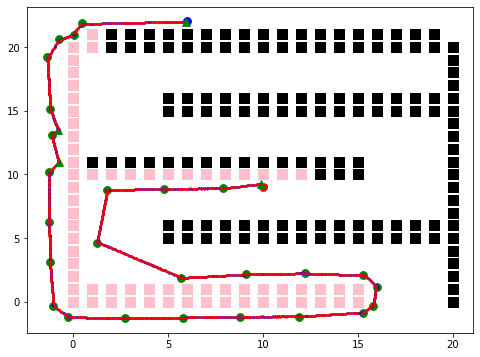

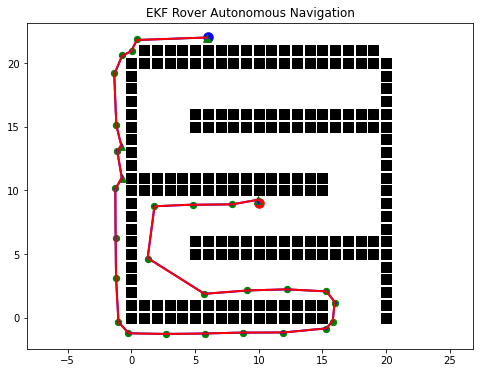

In [ ]:
start_state = array([[10.0, 9.0, 0.0]]).T
goal_state = array([[6.0, 22.0]]).T
init_var = [0.1, 0.1, 0.01]   # initial std for state variables x, y and theta

# prism = [[3,4], [2,2], [4,2], [8,2], [10,2], [9,4]]
# detected_obstacles_map = {2:{2}, 3:{3,4}, 4:{2}, 8:{2}, 9:{3,4}, 10:{2},12:{-2,-1,0,1,2,3,4,5,6}}
# circle_obstacles = [[12,6],[12,5],[12,4],[12,3],[12,2], [12,1], [12,0], [12,-1], [12,-2]]

# noices
std_vel = 0.1
std_steer = 0.01
std_range = 0.1
std_bearing = 0.01
tol = 0.1

# std_vel = 0.5
# std_steer = 0.05
# std_range = 0.5
# std_bearing = 0.05
# tol = 0.3

# std_vel = 1.0
# std_steer = 0.1
# std_range = 1.0
# std_bearing = 0.1
# tol = 0.5


dt = 0.1
speed = 1.0   # speed of rover
camera_max_range = 5.0   # max range of camera
rover_radius = 0.5    # wrap rover in a circle
bf_step_size = 1.0   # tangent line boundary following step size
detected_obstacles_map = {}   # map of obstacles maintained by planner, data from vision
# detected_obstacles_map = {2:{2}, 3:{3,4}, 4:{2}}

rover = RobotEKF(dt, std_vel=std_vel, std_steer=std_steer, init_var=init_var, std_range=std_range, std_bearing=std_bearing)
rover.x = start_state

path_planning(rover, start_state, goal_state, detected_obstacles_map, speed, camera_max_range, rover_radius, bf_step_size, tol=tol)
# circle_radius = 3.0
# run_circle(rover, goal_state.T[0], prism, detected_obstacles_map, tol, ideal_track, ekf_track)
# ideal_track = np.array(ideal_track)
# ekf_track = np.array(ekf_track)
# plt.figure(figsize=(8.,8.))
# plt.xlim(-10,20)
# plt.ylim(-10,20)
# # plt.set_aspect('equal', 'box')
# plt.scatter(start_state[0], start_state[1], c='red', marker='o', s=90)
# plt.scatter(goal_state[0], goal_state[1], c='blue', marker='o', s=90)
# for p in range(len(prism)):
#     plt.scatter(prism[p][0], prism[p][1], c='green', marker='o', s=90)
# for o in range(len(circle_obstacles)):
#     plt.scatter(circle_obstacles[o][0], circle_obstacles[o][1], c='black', marker='s', s=90)
# plt.plot(ideal_track[:,0], ideal_track[:,1], color='b', lw=2)
# plt.plot(ekf_track[:, 0], ekf_track[:,1], color='r', lw=2)

# plt.show()

In [ ]:
import random
test = random.choice([-1, 1])
print(test)

1
